In [19]:
from tensorflow.keras import datasets

(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [20]:
import torch
from torch.utils.data import DataLoader

train_images = torch.tensor(train_images / 255, dtype=torch.float32)
test_images = torch.tensor(test_images / 255, dtype=torch.float32)

train_images = train_images.unsqueeze(1)
test_images = test_images.unsqueeze(1)

train_loader = DataLoader(train_images, batch_size=9192, shuffle=True)
test_loader = DataLoader(test_images, batch_size=9192, shuffle=False)

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.linear1 = nn.Linear(64 * 3 * 3, latent_dim)
        self.linear2 = nn.Linear(64 * 3 * 3, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        return mu, logvar

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(latent_dim, 64 * 3 * 3)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, 5, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(16, 1, 5, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 64, 3, 3)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

In [23]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

In [36]:
vae = VAE(latent_dim=16).to('cuda')

In [37]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()

    def forward(self, x_hat, x, mu, logvar):
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_loss, recon_loss, kl_loss

In [38]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def train(model, train_loader, epochs, lr, device):
    writer = SummaryWriter()
    model.to(device)
    criterion = VAELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, min_lr=0.00001)
    prev_lr = lr
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        recon_loss = 0.0
        kl_loss = 0.0
        train_bar = tqdm(train_loader, desc="Training", leave=False)
        for batch_idx, data in enumerate(train_bar):
            data = data.to(device)
            optimizer.zero_grad()
            x_hat, mu, logvar = model(data)
            loss, recon, kl = criterion(x_hat, data, mu, logvar)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            recon_loss += recon.item()
            kl_loss += kl.item()
            train_bar.set_postfix(loss=running_loss / (batch_idx + 1), recon=recon.item(), kl=kl.item())
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {running_loss / len(train_loader)}, Recon Loss: {recon_loss / len(train_loader)}, KL Loss: {kl_loss / len(train_loader)}")
        writer.add_scalar("Loss/Train", running_loss / len(train_loader), epoch)
        writer.add_scalar("Loss/TrainRecon", recon, epoch)
        writer.add_scalar("Loss/TrainKL", kl, epoch)

        model.eval()
        running_loss = 0.0
        recon_loss = 0.0
        kl_loss = 0.0
        val_bar = tqdm(test_loader, desc="Validation", leave=False)
        for batch_idx, data in enumerate(val_bar):
            data = data.to(device)
            x_hat, mu, logvar = model(data)
            loss, recon, kl = criterion(x_hat, data, mu, logvar)
            running_loss += loss.item()
            recon_loss += recon.item()
            kl_loss += kl.item()
            val_bar.set_postfix(loss=running_loss / (batch_idx + 1), recon=recon.item(), kl=kl.item())
        print(f"Epoch {epoch + 1}/{epochs}, Val Loss: {running_loss / len(test_loader)}, Recon Loss: {recon_loss / len(test_loader)}, KL Loss: {kl_loss / len(test_loader)}")
        writer.add_scalar("Loss/Val", running_loss / len(test_loader), epoch)
        writer.add_scalar("Loss/ValRecon", recon, epoch)
        writer.add_scalar("Loss/ValKL", kl, epoch)
        scheduler.step(running_loss)
        if prev_lr != scheduler.optimizer.param_groups[0]['lr']:
            prev_lr = scheduler.optimizer.param_groups[0]['lr']
            print(f"Learning rate changed to {prev_lr}")
            writer.add_scalar("Learning Rate", prev_lr, epoch)
    writer.close()

In [39]:
train(vae, train_loader, 1000, 0.01, "cuda")

Epoch 1/1000, Train Loss: 5096496.107142857, Recon Loss: 4821063.142857143, KL Loss: 275433.0002621242


Epoch 1/1000, Val Loss: 2359628.4375, Recon Loss: 2359413.828125, KL Loss: 214.60630416870117


Epoch 2/1000, Train Loss: 3546771.464285714, Recon Loss: 3544908.0178571427, KL Loss: 1863.473427908761


Epoch 2/1000, Val Loss: 1803182.3125, Recon Loss: 1798588.234375, KL Loss: 4594.020233154297


Epoch 3/1000, Train Loss: 2653879.910714286, Recon Loss: 2632060.375, KL Loss: 21819.501116071428


Epoch 3/1000, Val Loss: 1326352.09375, Recon Loss: 1290330.421875, KL Loss: 36021.61962890625


Epoch 4/1000, Train Loss: 2182276.8214285714, Recon Loss: 2097371.785714286, KL Loss: 84905.0390625


Epoch 4/1000, Val Loss: 1200391.34375, Recon Loss: 1150874.78125, KL Loss: 49516.533935546875


Epoch 5/1000, Train Loss: 1994944.625, Recon Loss: 1921756.75, KL Loss: 73187.84040178571


Epoch 5/1000, Val Loss: 1124950.609375, Recon Loss: 1094346.2734375, KL Loss: 30604.35205078125


Epoch 6/1000, Train Loss: 1901030.392857143, Recon Loss: 1864236.3214285714, KL Loss: 36794.06584821428


Epoch 6/1000, Val Loss: 1090691.8125, Recon Loss: 1076438.421875, KL Loss: 14253.393798828125


Epoch 7/1000, Train Loss: 1864180.455357143, Recon Loss: 1840703.517857143, KL Loss: 23476.93973214286


Epoch 7/1000, Val Loss: 1078113.328125, Recon Loss: 1064513.53125, KL Loss: 13599.764526367188


Epoch 8/1000, Train Loss: 1842767.0892857143, Recon Loss: 1818673.4642857143, KL Loss: 24093.61886160714


Epoch 8/1000, Val Loss: 1069106.7578125, Recon Loss: 1054205.25, KL Loss: 14901.505126953125


Epoch 9/1000, Train Loss: 1831373.6339285714, Recon Loss: 1805736.8392857143, KL Loss: 25636.78348214286


Epoch 9/1000, Val Loss: 1064240.0546875, Recon Loss: 1050001.953125, KL Loss: 14238.0966796875


Epoch 10/1000, Train Loss: 1822673.125, Recon Loss: 1799464.3839285714, KL Loss: 23208.75613839286


Epoch 10/1000, Val Loss: 1060522.5390625, Recon Loss: 1047539.6640625, KL Loss: 12982.869995117188


Epoch 11/1000, Train Loss: 1817607.3839285714, Recon Loss: 1795175.232142857, KL Loss: 22432.13546316964


Epoch 11/1000, Val Loss: 1057955.671875, Recon Loss: 1044677.375, KL Loss: 13278.31494140625


Epoch 12/1000, Train Loss: 1813636.8392857143, Recon Loss: 1790998.0357142857, KL Loss: 22638.815987723214


Epoch 12/1000, Val Loss: 1055205.5859375, Recon Loss: 1042058.1875, KL Loss: 13147.394287109375


Epoch 13/1000, Train Loss: 1810240.125, Recon Loss: 1787995.6785714286, KL Loss: 22244.436104910714


Epoch 13/1000, Val Loss: 1053984.9765625, Recon Loss: 1041428.03125, KL Loss: 12556.9765625


Epoch 14/1000, Train Loss: 1806974.142857143, Recon Loss: 1785815.625, KL Loss: 21158.536690848214


Epoch 14/1000, Val Loss: 1052106.4609375, Recon Loss: 1040158.6640625, KL Loss: 11947.8037109375


Epoch 15/1000, Train Loss: 1804774.5535714286, Recon Loss: 1784493.857142857, KL Loss: 20280.70535714286


Epoch 15/1000, Val Loss: 1051158.515625, Recon Loss: 1039450.1171875, KL Loss: 11708.430358886719


Epoch 16/1000, Train Loss: 1802433.9017857143, Recon Loss: 1782606.357142857, KL Loss: 19827.54073660714


Epoch 16/1000, Val Loss: 1050294.140625, Recon Loss: 1039121.59375, KL Loss: 11172.572143554688


Epoch 17/1000, Train Loss: 1800630.5625, Recon Loss: 1781867.4285714286, KL Loss: 18763.135881696428


Epoch 17/1000, Val Loss: 1049205.8984375, Recon Loss: 1038489.578125, KL Loss: 10716.323486328125


Epoch 18/1000, Train Loss: 1798745.9910714286, Recon Loss: 1780540.1964285714, KL Loss: 18205.788504464286


Epoch 18/1000, Val Loss: 1048077.859375, Recon Loss: 1037756.3125, KL Loss: 10321.522338867188


Epoch 19/1000, Train Loss: 1797461.0089285714, Recon Loss: 1780095.1785714286, KL Loss: 17365.82840401786


Epoch 19/1000, Val Loss: 1047043.203125, Recon Loss: 1037100.25, KL Loss: 9942.927795410156


Epoch 20/1000, Train Loss: 1795472.267857143, Recon Loss: 1778745.1875, KL Loss: 16727.09347098214


Epoch 20/1000, Val Loss: 1045799.1796875, Recon Loss: 1036400.109375, KL Loss: 9399.048217773438


Epoch 21/1000, Train Loss: 1793693.1785714286, Recon Loss: 1778102.1785714286, KL Loss: 15590.988699776786


Epoch 21/1000, Val Loss: 1044870.7421875, Recon Loss: 1036158.6796875, KL Loss: 8712.072326660156


Epoch 22/1000, Train Loss: 1792527.125, Recon Loss: 1777771.2857142857, KL Loss: 14755.850864955357


Epoch 22/1000, Val Loss: 1044050.8359375, Recon Loss: 1035514.953125, KL Loss: 8535.890258789062


Epoch 23/1000, Train Loss: 1790532.6517857143, Recon Loss: 1776241.7857142857, KL Loss: 14290.850306919643


Epoch 23/1000, Val Loss: 1043242.3984375, Recon Loss: 1035456.96875, KL Loss: 7785.417175292969


Epoch 24/1000, Train Loss: 1789433.357142857, Recon Loss: 1776576.267857143, KL Loss: 12857.080496651786


Epoch 24/1000, Val Loss: 1042589.296875, Recon Loss: 1035426.640625, KL Loss: 7162.634216308594


Epoch 25/1000, Train Loss: 1787756.982142857, Recon Loss: 1775829.1607142857, KL Loss: 11927.819893973214


Epoch 25/1000, Val Loss: 1041615.515625, Recon Loss: 1034909.4765625, KL Loss: 6706.021728515625


Epoch 26/1000, Train Loss: 1786774.642857143, Recon Loss: 1775530.5535714286, KL Loss: 11244.089146205357


Epoch 26/1000, Val Loss: 1041004.0625, Recon Loss: 1034668.7734375, KL Loss: 6335.314422607422


Epoch 27/1000, Train Loss: 1785258.5357142857, Recon Loss: 1774794.9107142857, KL Loss: 10463.621372767857


Epoch 27/1000, Val Loss: 1040234.5078125, Recon Loss: 1034534.828125, KL Loss: 5699.661682128906


Epoch 28/1000, Train Loss: 1783561.7589285714, Recon Loss: 1774292.982142857, KL Loss: 9268.786342075893


Epoch 28/1000, Val Loss: 1039420.1640625, Recon Loss: 1034496.8203125, KL Loss: 4923.364044189453


Epoch 29/1000, Train Loss: 1782629.919642857, Recon Loss: 1774604.5089285714, KL Loss: 8025.407784598215


Epoch 29/1000, Val Loss: 1038348.90625, Recon Loss: 1033896.890625, KL Loss: 4452.0391845703125


Epoch 30/1000, Train Loss: 1780762.9285714286, Recon Loss: 1773368.6875, KL Loss: 7394.24103655134


Epoch 30/1000, Val Loss: 1037223.875, Recon Loss: 1033091.328125, KL Loss: 4132.5712890625


Epoch 31/1000, Train Loss: 1779135.2857142857, Recon Loss: 1772194.267857143, KL Loss: 6941.024867466518


Epoch 31/1000, Val Loss: 1036426.6171875, Recon Loss: 1032350.0546875, KL Loss: 4076.5696411132812


Epoch 32/1000, Train Loss: 1775803.5982142857, Recon Loss: 1768592.0, KL Loss: 7211.60498046875


Epoch 32/1000, Val Loss: 1032031.2421875, Recon Loss: 1026893.265625, KL Loss: 5137.955810546875


Epoch 33/1000, Train Loss: 1759456.4017857143, Recon Loss: 1746963.5535714286, KL Loss: 12492.845493861607


Epoch 33/1000, Val Loss: 1016242.203125, Recon Loss: 1006799.640625, KL Loss: 9442.569946289062


Epoch 34/1000, Train Loss: 1737829.25, Recon Loss: 1717604.794642857, KL Loss: 20224.47530691964


Epoch 34/1000, Val Loss: 1000760.6015625, Recon Loss: 987744.6875, KL Loss: 13015.885498046875


Epoch 35/1000, Train Loss: 1702752.392857143, Recon Loss: 1675079.2857142857, KL Loss: 27673.133649553572


Epoch 35/1000, Val Loss: 976828.21875, Recon Loss: 958961.9921875, KL Loss: 17866.248168945312


Epoch 36/1000, Train Loss: 1647215.0535714286, Recon Loss: 1597811.4285714286, KL Loss: 49403.63727678572


Epoch 36/1000, Val Loss: 945927.6328125, Recon Loss: 921970.6796875, KL Loss: 23956.95947265625


Epoch 37/1000, Train Loss: 1597352.3035714286, Recon Loss: 1543093.0, KL Loss: 54259.2890625


Epoch 37/1000, Val Loss: 924546.25, Recon Loss: 891965.1875, KL Loss: 32581.082763671875


Epoch 38/1000, Train Loss: 1562077.3839285714, Recon Loss: 1493789.4107142857, KL Loss: 68287.98214285714


Epoch 38/1000, Val Loss: 898859.6484375, Recon Loss: 866929.5234375, KL Loss: 31930.135009765625


Epoch 39/1000, Train Loss: 1514596.232142857, Recon Loss: 1445206.017857143, KL Loss: 69390.22209821429


Epoch 39/1000, Val Loss: 866387.171875, Recon Loss: 824049.6640625, KL Loss: 42337.5419921875


Epoch 40/1000, Train Loss: 1469294.5357142857, Recon Loss: 1391333.0267857143, KL Loss: 77961.51450892857


Epoch 40/1000, Val Loss: 845602.9453125, Recon Loss: 797887.0, KL Loss: 47715.94482421875


Epoch 41/1000, Train Loss: 1441103.25, Recon Loss: 1352373.1160714286, KL Loss: 88730.1640625


Epoch 41/1000, Val Loss: 838008.734375, Recon Loss: 780074.22265625, KL Loss: 57934.5


Epoch 42/1000, Train Loss: 1417117.6160714286, Recon Loss: 1323332.0892857143, KL Loss: 93785.52734375


Epoch 42/1000, Val Loss: 825052.7421875, Recon Loss: 763385.78125, KL Loss: 61666.962890625


Epoch 43/1000, Train Loss: 1386317.1160714286, Recon Loss: 1287212.5089285714, KL Loss: 99104.60379464286


Epoch 43/1000, Val Loss: 792225.703125, Recon Loss: 733732.9609375, KL Loss: 58492.73388671875


Epoch 44/1000, Train Loss: 1342468.294642857, Recon Loss: 1238770.9017857143, KL Loss: 103697.38671875


Epoch 44/1000, Val Loss: 769172.921875, Recon Loss: 706659.8046875, KL Loss: 62513.1181640625


Epoch 45/1000, Train Loss: 1307355.0625, Recon Loss: 1196146.5267857143, KL Loss: 111208.53850446429


Epoch 45/1000, Val Loss: 749431.5625, Recon Loss: 682966.359375, KL Loss: 66465.19384765625


Epoch 46/1000, Train Loss: 1298741.1875, Recon Loss: 1181146.482142857, KL Loss: 117594.6796875


Epoch 46/1000, Val Loss: 774014.5703125, Recon Loss: 700662.4375, KL Loss: 73352.13232421875


Epoch 47/1000, Train Loss: 1309795.982142857, Recon Loss: 1188726.482142857, KL Loss: 121069.5234375


Epoch 47/1000, Val Loss: 739175.05078125, Recon Loss: 668066.28125, KL Loss: 71108.7509765625


Epoch 48/1000, Train Loss: 1254450.169642857, Recon Loss: 1131996.2857142857, KL Loss: 122453.88058035714


Epoch 48/1000, Val Loss: 722104.53125, Recon Loss: 651861.109375, KL Loss: 70243.451171875


Epoch 49/1000, Train Loss: 1227195.607142857, Recon Loss: 1101111.9285714286, KL Loss: 126083.69196428571


Epoch 49/1000, Val Loss: 706255.86328125, Recon Loss: 633307.203125, KL Loss: 72948.63720703125


Epoch 50/1000, Train Loss: 1205928.1339285714, Recon Loss: 1076702.830357143, KL Loss: 129225.3125


Epoch 50/1000, Val Loss: 694362.93359375, Recon Loss: 618534.4296875, KL Loss: 75828.5283203125


Epoch 51/1000, Train Loss: 1186083.6964285714, Recon Loss: 1053874.4285714286, KL Loss: 132209.27232142858


Epoch 51/1000, Val Loss: 684924.4375, Recon Loss: 606220.53125, KL Loss: 78703.9130859375


Epoch 52/1000, Train Loss: 1170158.9375, Recon Loss: 1034317.1071428572, KL Loss: 135841.8392857143


Epoch 52/1000, Val Loss: 676756.921875, Recon Loss: 598589.1015625, KL Loss: 78167.7890625


Epoch 53/1000, Train Loss: 1194887.580357143, Recon Loss: 1057075.6964285714, KL Loss: 137811.8828125


Epoch 53/1000, Val Loss: 735578.7265625, Recon Loss: 650815.5625, KL Loss: 84763.1416015625


Epoch 54/1000, Train Loss: 1208162.1339285714, Recon Loss: 1069748.1785714286, KL Loss: 138413.95535714287


Epoch 54/1000, Val Loss: 702011.65625, Recon Loss: 623706.66796875, KL Loss: 78304.986328125


Epoch 55/1000, Train Loss: 1178057.2142857143, Recon Loss: 1041001.8214285715, KL Loss: 137055.375


Epoch 55/1000, Val Loss: 666865.5859375, Recon Loss: 585159.3203125, KL Loss: 81706.28076171875


Epoch 56/1000, Train Loss: 1144397.267857143, Recon Loss: 1002463.625, KL Loss: 141933.6361607143


Epoch 56/1000, Val Loss: 663316.140625, Recon Loss: 581541.234375, KL Loss: 81774.93896484375


Epoch 57/1000, Train Loss: 1130745.1517857143, Recon Loss: 986041.3214285715, KL Loss: 144703.83482142858


Epoch 57/1000, Val Loss: 653282.63671875, Recon Loss: 569237.7890625, KL Loss: 84044.8232421875


Epoch 58/1000, Train Loss: 1120201.8839285714, Recon Loss: 973044.5, KL Loss: 147157.3950892857


Epoch 58/1000, Val Loss: 642993.6875, Recon Loss: 557687.4296875, KL Loss: 85306.244140625


Epoch 59/1000, Train Loss: 1106674.5714285714, Recon Loss: 958145.5892857143, KL Loss: 148529.0044642857


Epoch 59/1000, Val Loss: 638415.5625, Recon Loss: 551112.98046875, KL Loss: 87302.552734375


Epoch 60/1000, Train Loss: 1095581.107142857, Recon Loss: 944087.4553571428, KL Loss: 151493.66964285713


Epoch 60/1000, Val Loss: 629529.859375, Recon Loss: 540293.53515625, KL Loss: 89236.29443359375


Epoch 61/1000, Train Loss: 1083555.267857143, Recon Loss: 929495.8035714285, KL Loss: 154059.47098214287


Epoch 61/1000, Val Loss: 625509.0703125, Recon Loss: 534335.7109375, KL Loss: 91173.3369140625


Epoch 62/1000, Train Loss: 1088450.8660714286, Recon Loss: 932070.7589285715, KL Loss: 156380.11607142858


Epoch 62/1000, Val Loss: 621974.41015625, Recon Loss: 531185.796875, KL Loss: 90788.58203125


Epoch 63/1000, Train Loss: 1075109.607142857, Recon Loss: 918724.9196428572, KL Loss: 156384.6752232143


Epoch 63/1000, Val Loss: 620635.03125, Recon Loss: 528507.328125, KL Loss: 92127.7333984375


Epoch 64/1000, Train Loss: 1079511.5089285714, Recon Loss: 921496.1830357143, KL Loss: 158015.3359375


Epoch 64/1000, Val Loss: 627919.67578125, Recon Loss: 533815.921875, KL Loss: 94103.72900390625


Epoch 65/1000, Train Loss: 1078582.4464285714, Recon Loss: 920209.7946428572, KL Loss: 158372.64285714287


Epoch 65/1000, Val Loss: 621459.34375, Recon Loss: 526960.2421875, KL Loss: 94499.083984375


Epoch 66/1000, Train Loss: 1068392.0, Recon Loss: 909211.9553571428, KL Loss: 159180.04799107142


Epoch 66/1000, Val Loss: 614059.3515625, Recon Loss: 520529.7421875, KL Loss: 93529.63330078125


Epoch 67/1000, Train Loss: 1055574.9642857143, Recon Loss: 895354.2410714285, KL Loss: 160220.7075892857


Epoch 67/1000, Val Loss: 608829.5390625, Recon Loss: 512943.07421875, KL Loss: 95886.470703125


Epoch 68/1000, Train Loss: 1048108.1071428572, Recon Loss: 886126.125, KL Loss: 161981.99776785713


Epoch 68/1000, Val Loss: 605618.5625, Recon Loss: 510193.93359375, KL Loss: 95424.61328125


Epoch 69/1000, Train Loss: 1057927.7857142857, Recon Loss: 894381.1607142857, KL Loss: 163546.625


Epoch 69/1000, Val Loss: 610832.91015625, Recon Loss: 514825.171875, KL Loss: 96007.72265625


Epoch 70/1000, Train Loss: 1059136.7232142857, Recon Loss: 895943.4241071428, KL Loss: 163193.3013392857


Epoch 70/1000, Val Loss: 607023.7890625, Recon Loss: 511792.21484375, KL Loss: 95231.5654296875


Epoch 71/1000, Train Loss: 1043969.9375, Recon Loss: 880114.0446428572, KL Loss: 163855.89285714287


Epoch 71/1000, Val Loss: 602546.3203125, Recon Loss: 506223.2109375, KL Loss: 96323.111328125


Epoch 72/1000, Train Loss: 1035594.4107142857, Recon Loss: 870141.4910714285, KL Loss: 165452.9185267857


Epoch 72/1000, Val Loss: 597584.6953125, Recon Loss: 498270.59765625, KL Loss: 99314.11376953125


Epoch 73/1000, Train Loss: 1028633.6964285715, Recon Loss: 861107.5089285715, KL Loss: 167526.20535714287


Epoch 73/1000, Val Loss: 593629.40625, Recon Loss: 494946.8125, KL Loss: 98682.5693359375


Epoch 74/1000, Train Loss: 1033277.4464285715, Recon Loss: 864108.2678571428, KL Loss: 169169.171875


Epoch 74/1000, Val Loss: 592573.8125, Recon Loss: 491888.4765625, KL Loss: 100685.3525390625


Epoch 75/1000, Train Loss: 1025981.6696428572, Recon Loss: 855785.8616071428, KL Loss: 170195.8013392857


Epoch 75/1000, Val Loss: 595688.328125, Recon Loss: 495684.1953125, KL Loss: 100004.119140625


Epoch 76/1000, Train Loss: 1038123.1517857143, Recon Loss: 866609.1473214285, KL Loss: 171514.0033482143


Epoch 76/1000, Val Loss: 598842.3671875, Recon Loss: 497617.671875, KL Loss: 101224.671875


Epoch 77/1000, Train Loss: 1025659.8482142857, Recon Loss: 854495.0089285715, KL Loss: 171164.8125


Epoch 77/1000, Val Loss: 591712.7421875, Recon Loss: 490049.640625, KL Loss: 101663.078125


Epoch 78/1000, Train Loss: 1015619.3125, Recon Loss: 842339.2767857143, KL Loss: 173280.03683035713


Epoch 78/1000, Val Loss: 586387.28125, Recon Loss: 483031.58984375, KL Loss: 103355.666015625


Epoch 79/1000, Train Loss: 1012423.9821428572, Recon Loss: 837495.8392857143, KL Loss: 174928.17410714287


Epoch 79/1000, Val Loss: 580601.1171875, Recon Loss: 477093.69921875, KL Loss: 103507.4423828125


Epoch 80/1000, Train Loss: 1013007.875, Recon Loss: 837577.4776785715, KL Loss: 175430.38392857142


Epoch 80/1000, Val Loss: 588901.40234375, Recon Loss: 486385.27734375, KL Loss: 102516.09375


Epoch 81/1000, Train Loss: 1023425.8571428572, Recon Loss: 848119.7142857143, KL Loss: 175306.140625


Epoch 81/1000, Val Loss: 581936.265625, Recon Loss: 478748.69140625, KL Loss: 103187.607421875


Epoch 82/1000, Train Loss: 1007232.5535714285, Recon Loss: 830861.5669642857, KL Loss: 176371.00892857142


Epoch 82/1000, Val Loss: 577426.1875, Recon Loss: 473800.3125, KL Loss: 103625.849609375


Epoch 83/1000, Train Loss: 1001724.8392857143, Recon Loss: 823742.1607142857, KL Loss: 177982.6841517857


Epoch 83/1000, Val Loss: 582913.3125, Recon Loss: 475745.28515625, KL Loss: 107168.00390625


Epoch 84/1000, Train Loss: 1001673.5178571428, Recon Loss: 823704.21875, KL Loss: 177969.3169642857


Epoch 84/1000, Val Loss: 576959.36328125, Recon Loss: 472486.3671875, KL Loss: 104473.00390625


Epoch 85/1000, Train Loss: 995028.6160714285, Recon Loss: 816159.8169642857, KL Loss: 178868.8125


Epoch 85/1000, Val Loss: 580287.65625, Recon Loss: 473258.5703125, KL Loss: 107029.064453125


Epoch 86/1000, Train Loss: 997775.6607142857, Recon Loss: 817645.3482142857, KL Loss: 180130.31808035713


Epoch 86/1000, Val Loss: 578810.17578125, Recon Loss: 472861.59375, KL Loss: 105948.60546875


Epoch 87/1000, Train Loss: 996848.2321428572, Recon Loss: 816946.8348214285, KL Loss: 179901.41964285713


Epoch 87/1000, Val Loss: 576988.578125, Recon Loss: 470919.203125, KL Loss: 106069.3896484375


Epoch 88/1000, Train Loss: 995699.125, Recon Loss: 815425.6741071428, KL Loss: 180273.4642857143


Epoch 88/1000, Val Loss: 577224.984375, Recon Loss: 471387.04296875, KL Loss: 105837.95703125


Epoch 89/1000, Train Loss: 989214.7589285715, Recon Loss: 808098.375, KL Loss: 181116.3794642857


Epoch 89/1000, Val Loss: 570483.7890625, Recon Loss: 464212.84765625, KL Loss: 106270.943359375


Epoch 90/1000, Train Loss: 983602.7678571428, Recon Loss: 801676.2678571428, KL Loss: 181926.48660714287


Epoch 90/1000, Val Loss: 570259.84375, Recon Loss: 462528.984375, KL Loss: 107730.8603515625


Epoch 91/1000, Train Loss: 987816.8839285715, Recon Loss: 805528.4107142857, KL Loss: 182288.48325892858


Epoch 91/1000, Val Loss: 567581.3671875, Recon Loss: 462475.21875, KL Loss: 105106.1396484375


Epoch 92/1000, Train Loss: 974686.6071428572, Recon Loss: 791783.9017857143, KL Loss: 182902.71205357142


Epoch 92/1000, Val Loss: 562683.1015625, Recon Loss: 455000.2421875, KL Loss: 107682.845703125


Epoch 93/1000, Train Loss: 971110.2767857143, Recon Loss: 786179.7946428572, KL Loss: 184930.4732142857


Epoch 93/1000, Val Loss: 560280.5859375, Recon Loss: 452889.58203125, KL Loss: 107390.998046875


Epoch 94/1000, Train Loss: 967619.7946428572, Recon Loss: 783008.8125, KL Loss: 184610.9720982143


Epoch 94/1000, Val Loss: 559372.92578125, Recon Loss: 451396.234375, KL Loss: 107976.6845703125


Epoch 95/1000, Train Loss: 984940.1517857143, Recon Loss: 798740.4598214285, KL Loss: 186199.68526785713


Epoch 95/1000, Val Loss: 590659.890625, Recon Loss: 480738.8046875, KL Loss: 109921.052734375


Epoch 96/1000, Train Loss: 1035899.8839285715, Recon Loss: 855245.0803571428, KL Loss: 180654.79017857142


Epoch 96/1000, Val Loss: 610058.70703125, Recon Loss: 505182.9296875, KL Loss: 104875.8017578125


Epoch 97/1000, Train Loss: 1012894.0803571428, Recon Loss: 834000.9732142857, KL Loss: 178893.08705357142


Epoch 97/1000, Val Loss: 581128.265625, Recon Loss: 474236.5859375, KL Loss: 106891.6630859375


Epoch 98/1000, Train Loss: 987882.625, Recon Loss: 805757.6964285715, KL Loss: 182124.9252232143


Epoch 98/1000, Val Loss: 569459.046875, Recon Loss: 461178.7578125, KL Loss: 108280.28125


Epoch 99/1000, Train Loss: 975926.2410714285, Recon Loss: 791570.2991071428, KL Loss: 184355.95424107142


Epoch 99/1000, Val Loss: 564306.421875, Recon Loss: 455956.921875, KL Loss: 108349.4921875


Epoch 100/1000, Train Loss: 968471.8214285715, Recon Loss: 783394.2589285715, KL Loss: 185077.56808035713


Epoch 100/1000, Val Loss: 558776.7109375, Recon Loss: 449129.3984375, KL Loss: 109647.302734375


Epoch 101/1000, Train Loss: 962858.1071428572, Recon Loss: 777030.7991071428, KL Loss: 185827.32254464287


Epoch 101/1000, Val Loss: 556513.265625, Recon Loss: 446224.87890625, KL Loss: 110288.3857421875


Epoch 102/1000, Train Loss: 959162.5982142857, Recon Loss: 772127.71875, KL Loss: 187034.875


Epoch 102/1000, Val Loss: 555007.1484375, Recon Loss: 445254.2421875, KL Loss: 109752.908203125


Epoch 103/1000, Train Loss: 960362.8660714285, Recon Loss: 772972.6428571428, KL Loss: 187390.21205357142


Epoch 103/1000, Val Loss: 556218.74609375, Recon Loss: 446907.9765625, KL Loss: 109310.76953125


Epoch 104/1000, Train Loss: 986940.0625, Recon Loss: 801076.75, KL Loss: 185863.32924107142


Epoch 104/1000, Val Loss: 580996.91015625, Recon Loss: 470781.7578125, KL Loss: 110215.13671875


Epoch 105/1000, Train Loss: 985039.375, Recon Loss: 800263.5089285715, KL Loss: 184775.85379464287


Epoch 105/1000, Val Loss: 561807.6484375, Recon Loss: 450551.12109375, KL Loss: 111256.52734375


Epoch 106/1000, Train Loss: 978795.8839285715, Recon Loss: 793009.4196428572, KL Loss: 185786.48549107142


Epoch 106/1000, Val Loss: 559566.6015625, Recon Loss: 451525.44140625, KL Loss: 108041.166015625


Epoch 107/1000, Train Loss: 962948.5089285715, Recon Loss: 777598.6339285715, KL Loss: 185349.8828125


Epoch 107/1000, Val Loss: 554520.43359375, Recon Loss: 444656.94921875, KL Loss: 109863.4765625


Epoch 108/1000, Train Loss: 956841.8392857143, Recon Loss: 769084.2098214285, KL Loss: 187757.62276785713


Epoch 108/1000, Val Loss: 551076.640625, Recon Loss: 441968.9453125, KL Loss: 109107.708984375


Epoch 109/1000, Train Loss: 951822.5535714285, Recon Loss: 763948.7767857143, KL Loss: 187873.77455357142


Epoch 109/1000, Val Loss: 551434.3671875, Recon Loss: 441149.08984375, KL Loss: 110285.287109375


Epoch 110/1000, Train Loss: 951649.1607142857, Recon Loss: 763162.1517857143, KL Loss: 188487.00223214287


Epoch 110/1000, Val Loss: 548889.46484375, Recon Loss: 438242.609375, KL Loss: 110646.86328125


Epoch 111/1000, Train Loss: 947578.1607142857, Recon Loss: 758521.7232142857, KL Loss: 189056.43526785713


Epoch 111/1000, Val Loss: 547411.2109375, Recon Loss: 436880.140625, KL Loss: 110531.064453125


Epoch 112/1000, Train Loss: 955086.2410714285, Recon Loss: 765489.1785714285, KL Loss: 189597.0658482143


Epoch 112/1000, Val Loss: 561177.6484375, Recon Loss: 451370.3203125, KL Loss: 109807.337890625


Epoch 113/1000, Train Loss: 996670.9375, Recon Loss: 809979.4464285715, KL Loss: 186691.50892857142


Epoch 113/1000, Val Loss: 583895.9296875, Recon Loss: 476977.02734375, KL Loss: 106918.873046875


Epoch 114/1000, Train Loss: 977572.1696428572, Recon Loss: 792934.2366071428, KL Loss: 184637.93080357142


Epoch 114/1000, Val Loss: 561113.109375, Recon Loss: 452763.4453125, KL Loss: 108349.6484375


Epoch 115/1000, Train Loss: 960251.6071428572, Recon Loss: 772912.7232142857, KL Loss: 187338.89285714287


Epoch 115/1000, Val Loss: 557694.203125, Recon Loss: 446146.390625, KL Loss: 111547.8125


Epoch 116/1000, Train Loss: 952876.8571428572, Recon Loss: 764709.9285714285, KL Loss: 188166.91964285713


Epoch 116/1000, Val Loss: 550429.890625, Recon Loss: 439304.859375, KL Loss: 111125.021484375


Epoch 117/1000, Train Loss: 947980.4107142857, Recon Loss: 758687.4598214285, KL Loss: 189292.94308035713


Epoch 117/1000, Val Loss: 547339.98828125, Recon Loss: 437366.71484375, KL Loss: 109973.2734375


Epoch 118/1000, Train Loss: 944613.0892857143, Recon Loss: 755033.8482142857, KL Loss: 189579.24330357142


Epoch 118/1000, Val Loss: 546034.73046875, Recon Loss: 434491.515625, KL Loss: 111543.22265625


Epoch 119/1000, Train Loss: 941872.8125, Recon Loss: 751752.9196428572, KL Loss: 190119.88392857142


Epoch 119/1000, Val Loss: 544894.12109375, Recon Loss: 433469.84765625, KL Loss: 111424.2666015625


Epoch 120/1000, Train Loss: 944463.2053571428, Recon Loss: 754360.8214285715, KL Loss: 190102.3861607143


Epoch 120/1000, Val Loss: 545650.67578125, Recon Loss: 435377.8125, KL Loss: 110272.8486328125


Epoch 121/1000, Train Loss: 942883.1428571428, Recon Loss: 752884.125, KL Loss: 189999.00892857142


Epoch 121/1000, Val Loss: 544442.1328125, Recon Loss: 433141.828125, KL Loss: 111300.2890625


Epoch 122/1000, Train Loss: 956182.0089285715, Recon Loss: 765643.8214285715, KL Loss: 190538.1830357143


Epoch 122/1000, Val Loss: 558261.60546875, Recon Loss: 448710.8515625, KL Loss: 109550.75390625


Epoch 123/1000, Train Loss: 955271.5714285715, Recon Loss: 766625.6875, KL Loss: 188645.87276785713


Epoch 123/1000, Val Loss: 548250.08203125, Recon Loss: 436724.51953125, KL Loss: 111525.578125


Epoch 124/1000, Train Loss: 946999.2321428572, Recon Loss: 756761.5, KL Loss: 190237.7220982143


Epoch 124/1000, Val Loss: 545874.2109375, Recon Loss: 435919.9296875, KL Loss: 109954.271484375


Epoch 125/1000, Train Loss: 942029.2767857143, Recon Loss: 752029.3214285715, KL Loss: 189999.95982142858


Epoch 125/1000, Val Loss: 545414.21875, Recon Loss: 434101.24609375, KL Loss: 111312.978515625


Epoch 126/1000, Train Loss: 946583.8928571428, Recon Loss: 755828.0178571428, KL Loss: 190755.8794642857


Epoch 126/1000, Val Loss: 544923.08203125, Recon Loss: 434214.82421875, KL Loss: 110708.2734375


Epoch 127/1000, Train Loss: 938879.7946428572, Recon Loss: 748709.8392857143, KL Loss: 190169.9564732143


Epoch 127/1000, Val Loss: 543880.328125, Recon Loss: 432686.078125, KL Loss: 111194.265625


Epoch 128/1000, Train Loss: 947425.625, Recon Loss: 756216.4285714285, KL Loss: 191209.21205357142


Epoch 128/1000, Val Loss: 547658.75, Recon Loss: 437455.828125, KL Loss: 110202.912109375


Epoch 129/1000, Train Loss: 939801.4285714285, Recon Loss: 750001.5892857143, KL Loss: 189799.83370535713


Epoch 129/1000, Val Loss: 544513.390625, Recon Loss: 431853.8984375, KL Loss: 112659.509765625


Epoch 130/1000, Train Loss: 943379.2321428572, Recon Loss: 751861.5178571428, KL Loss: 191517.71205357142


Epoch 130/1000, Val Loss: 543745.5078125, Recon Loss: 432363.5390625, KL Loss: 111381.9775390625


Epoch 131/1000, Train Loss: 935314.7678571428, Recon Loss: 744603.8616071428, KL Loss: 190710.90513392858


Epoch 131/1000, Val Loss: 541565.8828125, Recon Loss: 429330.11328125, KL Loss: 112235.787109375


Epoch 132/1000, Train Loss: 933596.9196428572, Recon Loss: 741311.4821428572, KL Loss: 192285.4330357143


Epoch 132/1000, Val Loss: 540709.65625, Recon Loss: 428363.5, KL Loss: 112346.1494140625


Epoch 133/1000, Train Loss: 940134.2410714285, Recon Loss: 748700.6785714285, KL Loss: 191433.55580357142


Epoch 133/1000, Val Loss: 540607.6484375, Recon Loss: 428939.24609375, KL Loss: 111668.39453125


Epoch 134/1000, Train Loss: 934992.2633928572, Recon Loss: 743590.3169642857, KL Loss: 191401.95870535713


Epoch 134/1000, Val Loss: 540481.15625, Recon Loss: 428499.48828125, KL Loss: 111981.669921875


Epoch 135/1000, Train Loss: 933177.8928571428, Recon Loss: 740916.4375, KL Loss: 192261.45424107142


Epoch 135/1000, Val Loss: 540125.7578125, Recon Loss: 426975.73046875, KL Loss: 113150.044921875


Epoch 136/1000, Train Loss: 935630.8839285715, Recon Loss: 743415.5625, KL Loss: 192215.3125


Epoch 136/1000, Val Loss: 542895.59375, Recon Loss: 430913.4375, KL Loss: 111982.154296875


Epoch 137/1000, Train Loss: 943499.0, Recon Loss: 751961.0803571428, KL Loss: 191537.9174107143


Epoch 137/1000, Val Loss: 544411.9296875, Recon Loss: 431961.2890625, KL Loss: 112450.626953125


Epoch 138/1000, Train Loss: 944747.8571428572, Recon Loss: 753807.2767857143, KL Loss: 190940.578125


Epoch 138/1000, Val Loss: 549410.15625, Recon Loss: 438823.515625, KL Loss: 110586.634765625


Epoch 139/1000, Train Loss: 959049.8125, Recon Loss: 768394.5178571428, KL Loss: 190655.296875


Epoch 139/1000, Val Loss: 555162.58203125, Recon Loss: 444084.40625, KL Loss: 111078.17578125


Epoch 140/1000, Train Loss: 944794.7767857143, Recon Loss: 755471.8258928572, KL Loss: 189322.953125


Epoch 140/1000, Val Loss: 542326.28515625, Recon Loss: 430042.953125, KL Loss: 112283.32421875


Epoch 141/1000, Train Loss: 937001.4821428572, Recon Loss: 745432.5178571428, KL Loss: 191568.96205357142


Epoch 141/1000, Val Loss: 543318.3515625, Recon Loss: 432752.53125, KL Loss: 110565.8125
Learning rate changed to 0.008


Epoch 142/1000, Train Loss: 933843.1071428572, Recon Loss: 742536.2723214285, KL Loss: 191306.8314732143


Epoch 142/1000, Val Loss: 543019.8359375, Recon Loss: 430811.5859375, KL Loss: 112208.251953125


Epoch 143/1000, Train Loss: 933986.8125, Recon Loss: 741872.5982142857, KL Loss: 192114.2109375


Epoch 143/1000, Val Loss: 540598.98046875, Recon Loss: 428630.18359375, KL Loss: 111968.78125


Epoch 144/1000, Train Loss: 932376.1428571428, Recon Loss: 740182.7633928572, KL Loss: 192193.37611607142


Epoch 144/1000, Val Loss: 539950.5078125, Recon Loss: 427262.81640625, KL Loss: 112687.6767578125


Epoch 145/1000, Train Loss: 930203.3660714285, Recon Loss: 738108.3928571428, KL Loss: 192094.96316964287


Epoch 145/1000, Val Loss: 536901.45703125, Recon Loss: 424412.1796875, KL Loss: 112489.29296875


Epoch 146/1000, Train Loss: 928140.3482142857, Recon Loss: 735459.3303571428, KL Loss: 192681.0234375


Epoch 146/1000, Val Loss: 535516.328125, Recon Loss: 421843.9375, KL Loss: 113672.380859375


Epoch 147/1000, Train Loss: 925322.0892857143, Recon Loss: 732001.8214285715, KL Loss: 193320.25669642858


Epoch 147/1000, Val Loss: 535872.890625, Recon Loss: 422839.8359375, KL Loss: 113033.0537109375


Epoch 148/1000, Train Loss: 924216.4330357143, Recon Loss: 730574.625, KL Loss: 193641.81361607142


Epoch 148/1000, Val Loss: 535306.3046875, Recon Loss: 422087.1640625, KL Loss: 113219.146484375


Epoch 149/1000, Train Loss: 922894.6607142857, Recon Loss: 729565.9017857143, KL Loss: 193328.76785714287


Epoch 149/1000, Val Loss: 535057.2109375, Recon Loss: 421028.0078125, KL Loss: 114029.1875


Epoch 150/1000, Train Loss: 922690.3973214285, Recon Loss: 728609.21875, KL Loss: 194081.18526785713


Epoch 150/1000, Val Loss: 534665.25, Recon Loss: 420846.34375, KL Loss: 113818.90625


Epoch 151/1000, Train Loss: 922145.8660714285, Recon Loss: 728190.0491071428, KL Loss: 193955.828125


Epoch 151/1000, Val Loss: 534335.5234375, Recon Loss: 420702.515625, KL Loss: 113633.0234375


Epoch 152/1000, Train Loss: 921887.7589285715, Recon Loss: 727971.3571428572, KL Loss: 193916.39955357142


Epoch 152/1000, Val Loss: 533757.89453125, Recon Loss: 419846.859375, KL Loss: 113911.0361328125


Epoch 153/1000, Train Loss: 921751.96875, Recon Loss: 727746.5758928572, KL Loss: 194005.3794642857


Epoch 153/1000, Val Loss: 534269.29296875, Recon Loss: 420022.234375, KL Loss: 114247.0419921875


Epoch 154/1000, Train Loss: 923058.2991071428, Recon Loss: 728841.9642857143, KL Loss: 194216.31919642858


Epoch 154/1000, Val Loss: 534705.02734375, Recon Loss: 420867.46875, KL Loss: 113837.55859375


Epoch 155/1000, Train Loss: 924504.9107142857, Recon Loss: 730354.25, KL Loss: 194150.65401785713


Epoch 155/1000, Val Loss: 534660.71484375, Recon Loss: 420860.828125, KL Loss: 113799.87109375


Epoch 156/1000, Train Loss: 925466.2366071428, Recon Loss: 732078.5714285715, KL Loss: 193387.6674107143


Epoch 156/1000, Val Loss: 537213.09375, Recon Loss: 423998.3984375, KL Loss: 113214.6796875


Epoch 157/1000, Train Loss: 931320.25, Recon Loss: 737476.7366071428, KL Loss: 193843.5044642857


Epoch 157/1000, Val Loss: 544364.09375, Recon Loss: 429949.92578125, KL Loss: 114414.1689453125


Epoch 158/1000, Train Loss: 935983.3839285715, Recon Loss: 743737.9464285715, KL Loss: 192245.4453125


Epoch 158/1000, Val Loss: 535364.8671875, Recon Loss: 422503.35546875, KL Loss: 112861.50390625
Learning rate changed to 0.0064


Epoch 159/1000, Train Loss: 922046.5535714285, Recon Loss: 728766.0803571428, KL Loss: 193280.47544642858


Epoch 159/1000, Val Loss: 533326.26171875, Recon Loss: 420196.6484375, KL Loss: 113129.6201171875


Epoch 160/1000, Train Loss: 919560.3571428572, Recon Loss: 725767.8214285715, KL Loss: 193792.53683035713


Epoch 160/1000, Val Loss: 533104.11328125, Recon Loss: 420029.82421875, KL Loss: 113074.2802734375


Epoch 161/1000, Train Loss: 918577.1785714285, Recon Loss: 724834.3125, KL Loss: 193742.86830357142


Epoch 161/1000, Val Loss: 532574.015625, Recon Loss: 419216.4921875, KL Loss: 113357.5146484375


Epoch 162/1000, Train Loss: 918290.1160714285, Recon Loss: 723642.1116071428, KL Loss: 194647.99776785713


Epoch 162/1000, Val Loss: 531155.3125, Recon Loss: 417822.86328125, KL Loss: 113332.44921875


Epoch 163/1000, Train Loss: 917884.1875, Recon Loss: 723337.2678571428, KL Loss: 194546.9174107143


Epoch 163/1000, Val Loss: 530930.0234375, Recon Loss: 417635.0, KL Loss: 113295.0244140625


Epoch 164/1000, Train Loss: 916890.5446428572, Recon Loss: 722273.8035714285, KL Loss: 194616.73995535713


Epoch 164/1000, Val Loss: 530980.8828125, Recon Loss: 417604.9921875, KL Loss: 113375.8994140625


Epoch 165/1000, Train Loss: 916674.3214285715, Recon Loss: 721930.9285714285, KL Loss: 194743.40625


Epoch 165/1000, Val Loss: 531373.40625, Recon Loss: 417078.046875, KL Loss: 114295.349609375


Epoch 166/1000, Train Loss: 916300.1875, Recon Loss: 721239.8303571428, KL Loss: 195060.35714285713


Epoch 166/1000, Val Loss: 531172.3203125, Recon Loss: 417094.265625, KL Loss: 114078.0546875


Epoch 167/1000, Train Loss: 916152.6696428572, Recon Loss: 721130.7857142857, KL Loss: 195021.8705357143


Epoch 167/1000, Val Loss: 531299.8984375, Recon Loss: 417522.22265625, KL Loss: 113777.6748046875


Epoch 168/1000, Train Loss: 916801.2142857143, Recon Loss: 721726.9642857143, KL Loss: 195074.23660714287


Epoch 168/1000, Val Loss: 531781.58984375, Recon Loss: 418120.12890625, KL Loss: 113661.46875


Epoch 169/1000, Train Loss: 916368.9910714285, Recon Loss: 721239.625, KL Loss: 195129.37723214287


Epoch 169/1000, Val Loss: 531696.53515625, Recon Loss: 417446.9765625, KL Loss: 114249.5595703125
Learning rate changed to 0.00512


Epoch 170/1000, Train Loss: 916075.3125, Recon Loss: 721217.6919642857, KL Loss: 194857.6205357143


Epoch 170/1000, Val Loss: 530047.9453125, Recon Loss: 416148.93359375, KL Loss: 113899.0283203125


Epoch 171/1000, Train Loss: 915083.5714285715, Recon Loss: 719788.40625, KL Loss: 195295.1607142857


Epoch 171/1000, Val Loss: 529879.03125, Recon Loss: 416269.609375, KL Loss: 113609.419921875


Epoch 172/1000, Train Loss: 914143.3705357143, Recon Loss: 718679.3526785715, KL Loss: 195464.0189732143


Epoch 172/1000, Val Loss: 530411.55859375, Recon Loss: 416893.3203125, KL Loss: 113518.23828125


Epoch 173/1000, Train Loss: 914064.5357142857, Recon Loss: 719219.0, KL Loss: 194845.5357142857


Epoch 173/1000, Val Loss: 530093.3515625, Recon Loss: 415917.48828125, KL Loss: 114175.8544921875


Epoch 174/1000, Train Loss: 913711.1696428572, Recon Loss: 718390.0625, KL Loss: 195321.11160714287


Epoch 174/1000, Val Loss: 529448.484375, Recon Loss: 415586.21875, KL Loss: 113862.25


Epoch 175/1000, Train Loss: 913457.6919642857, Recon Loss: 718098.0535714285, KL Loss: 195359.6294642857


Epoch 175/1000, Val Loss: 529678.4296875, Recon Loss: 415474.890625, KL Loss: 114203.548828125


Epoch 176/1000, Train Loss: 913349.0, Recon Loss: 717903.4732142857, KL Loss: 195445.5267857143


Epoch 176/1000, Val Loss: 529336.76953125, Recon Loss: 414847.0625, KL Loss: 114489.72265625


Epoch 177/1000, Train Loss: 912979.7857142857, Recon Loss: 717584.2633928572, KL Loss: 195395.515625


Epoch 177/1000, Val Loss: 529695.83203125, Recon Loss: 415313.734375, KL Loss: 114382.0966796875


Epoch 178/1000, Train Loss: 913116.1339285715, Recon Loss: 717495.0580357143, KL Loss: 195621.07254464287


Epoch 178/1000, Val Loss: 529019.6875, Recon Loss: 414621.6484375, KL Loss: 114398.041015625


Epoch 179/1000, Train Loss: 912702.7008928572, Recon Loss: 716941.5223214285, KL Loss: 195761.1752232143


Epoch 179/1000, Val Loss: 528729.9296875, Recon Loss: 414818.7890625, KL Loss: 113911.126953125


Epoch 180/1000, Train Loss: 912313.6294642857, Recon Loss: 716821.7053571428, KL Loss: 195491.9263392857


Epoch 180/1000, Val Loss: 528579.7421875, Recon Loss: 414152.83984375, KL Loss: 114426.8857421875


Epoch 181/1000, Train Loss: 912111.0892857143, Recon Loss: 716550.7767857143, KL Loss: 195560.328125


Epoch 181/1000, Val Loss: 528488.6953125, Recon Loss: 413785.28515625, KL Loss: 114703.41796875


Epoch 182/1000, Train Loss: 911739.7053571428, Recon Loss: 716179.9285714285, KL Loss: 195559.78794642858


Epoch 182/1000, Val Loss: 528546.70703125, Recon Loss: 413718.28515625, KL Loss: 114828.4208984375


Epoch 183/1000, Train Loss: 911950.96875, Recon Loss: 716221.7723214285, KL Loss: 195729.18973214287


Epoch 183/1000, Val Loss: 528555.21875, Recon Loss: 414260.03125, KL Loss: 114295.189453125


Epoch 184/1000, Train Loss: 911363.1964285715, Recon Loss: 715512.5669642857, KL Loss: 195850.6294642857


Epoch 184/1000, Val Loss: 528342.84375, Recon Loss: 414283.65625, KL Loss: 114059.177734375


Epoch 185/1000, Train Loss: 911375.9553571428, Recon Loss: 715601.75, KL Loss: 195774.2142857143


Epoch 185/1000, Val Loss: 527805.5390625, Recon Loss: 413017.7265625, KL Loss: 114787.810546875


Epoch 186/1000, Train Loss: 910600.9821428572, Recon Loss: 714740.1785714285, KL Loss: 195860.8080357143


Epoch 186/1000, Val Loss: 527850.19921875, Recon Loss: 413167.2421875, KL Loss: 114682.9580078125


Epoch 187/1000, Train Loss: 910554.4107142857, Recon Loss: 714828.9107142857, KL Loss: 195725.5033482143


Epoch 187/1000, Val Loss: 527888.5703125, Recon Loss: 413137.20703125, KL Loss: 114751.36328125


Epoch 188/1000, Train Loss: 910455.3526785715, Recon Loss: 714609.7678571428, KL Loss: 195845.5736607143


Epoch 188/1000, Val Loss: 527664.78125, Recon Loss: 412796.484375, KL Loss: 114868.294921875


Epoch 189/1000, Train Loss: 910166.625, Recon Loss: 714106.8482142857, KL Loss: 196059.77901785713


Epoch 189/1000, Val Loss: 527310.125, Recon Loss: 413097.2265625, KL Loss: 114212.9130859375


Epoch 190/1000, Train Loss: 909898.1785714285, Recon Loss: 713998.4375, KL Loss: 195899.734375


Epoch 190/1000, Val Loss: 527361.0625, Recon Loss: 412345.13671875, KL Loss: 115015.923828125


Epoch 191/1000, Train Loss: 909566.125, Recon Loss: 713406.78125, KL Loss: 196159.33816964287


Epoch 191/1000, Val Loss: 526859.140625, Recon Loss: 412510.1875, KL Loss: 114348.953125


Epoch 192/1000, Train Loss: 909331.6741071428, Recon Loss: 713125.9375, KL Loss: 196205.734375


Epoch 192/1000, Val Loss: 527188.30078125, Recon Loss: 412885.1328125, KL Loss: 114303.1669921875


Epoch 193/1000, Train Loss: 909144.2589285715, Recon Loss: 713193.1160714285, KL Loss: 195951.125


Epoch 193/1000, Val Loss: 527246.609375, Recon Loss: 412525.45703125, KL Loss: 114721.15234375


Epoch 194/1000, Train Loss: 909134.3571428572, Recon Loss: 713303.0982142857, KL Loss: 195831.24330357142


Epoch 194/1000, Val Loss: 527657.6328125, Recon Loss: 413215.3984375, KL Loss: 114442.2421875


Epoch 195/1000, Train Loss: 909809.6696428572, Recon Loss: 713317.2767857143, KL Loss: 196492.40513392858


Epoch 195/1000, Val Loss: 528174.328125, Recon Loss: 413876.5546875, KL Loss: 114297.7734375


Epoch 196/1000, Train Loss: 910375.875, Recon Loss: 714307.8616071428, KL Loss: 196068.00892857142


Epoch 196/1000, Val Loss: 528043.73046875, Recon Loss: 413555.8203125, KL Loss: 114487.9169921875


Epoch 197/1000, Train Loss: 910783.7901785715, Recon Loss: 714726.0178571428, KL Loss: 196057.75892857142


Epoch 197/1000, Val Loss: 529075.25390625, Recon Loss: 414217.11328125, KL Loss: 114858.15625
Learning rate changed to 0.004096000000000001


Epoch 198/1000, Train Loss: 910954.3660714285, Recon Loss: 715079.7678571428, KL Loss: 195874.5892857143


Epoch 198/1000, Val Loss: 528570.8359375, Recon Loss: 413976.3359375, KL Loss: 114594.482421875


Epoch 199/1000, Train Loss: 910484.5, Recon Loss: 714236.5803571428, KL Loss: 196247.92745535713


Epoch 199/1000, Val Loss: 529069.98828125, Recon Loss: 414637.484375, KL Loss: 114432.50390625


Epoch 200/1000, Train Loss: 910877.0089285715, Recon Loss: 715312.7053571428, KL Loss: 195564.29910714287


Epoch 200/1000, Val Loss: 529826.5625, Recon Loss: 415319.2734375, KL Loss: 114507.279296875


Epoch 201/1000, Train Loss: 911799.625, Recon Loss: 715789.1741071428, KL Loss: 196010.46205357142


Epoch 201/1000, Val Loss: 531193.31640625, Recon Loss: 416400.515625, KL Loss: 114792.79296875


Epoch 202/1000, Train Loss: 912351.2946428572, Recon Loss: 716509.5625, KL Loss: 195841.734375


Epoch 202/1000, Val Loss: 530038.58984375, Recon Loss: 415031.59375, KL Loss: 115006.99609375


Epoch 203/1000, Train Loss: 911042.9821428572, Recon Loss: 714982.2232142857, KL Loss: 196060.76339285713


Epoch 203/1000, Val Loss: 529106.00390625, Recon Loss: 415047.375, KL Loss: 114058.6220703125
Learning rate changed to 0.0032768000000000007


Epoch 204/1000, Train Loss: 909648.8214285715, Recon Loss: 713806.09375, KL Loss: 195842.7299107143


Epoch 204/1000, Val Loss: 527154.2109375, Recon Loss: 412788.3828125, KL Loss: 114365.826171875


Epoch 205/1000, Train Loss: 908390.3839285715, Recon Loss: 712071.0357142857, KL Loss: 196319.359375


Epoch 205/1000, Val Loss: 525762.53125, Recon Loss: 411093.7734375, KL Loss: 114668.755859375


Epoch 206/1000, Train Loss: 907058.9776785715, Recon Loss: 711334.25, KL Loss: 195724.73325892858


Epoch 206/1000, Val Loss: 525906.078125, Recon Loss: 410829.30859375, KL Loss: 115076.76953125


Epoch 207/1000, Train Loss: 906500.0446428572, Recon Loss: 709888.5625, KL Loss: 196611.48660714287


Epoch 207/1000, Val Loss: 525732.9375, Recon Loss: 411811.6171875, KL Loss: 113921.3271484375


Epoch 208/1000, Train Loss: 906377.5892857143, Recon Loss: 710237.5401785715, KL Loss: 196140.0580357143


Epoch 208/1000, Val Loss: 525456.2265625, Recon Loss: 410374.76171875, KL Loss: 115081.462890625


Epoch 209/1000, Train Loss: 906717.25, Recon Loss: 710143.3928571428, KL Loss: 196573.8560267857


Epoch 209/1000, Val Loss: 525144.3984375, Recon Loss: 409733.1875, KL Loss: 115411.193359375


Epoch 210/1000, Train Loss: 905935.7321428572, Recon Loss: 709581.3660714285, KL Loss: 196354.37276785713


Epoch 210/1000, Val Loss: 525701.4453125, Recon Loss: 411204.68359375, KL Loss: 114496.76171875


Epoch 211/1000, Train Loss: 905859.9285714285, Recon Loss: 709348.3303571428, KL Loss: 196511.58705357142


Epoch 211/1000, Val Loss: 525616.6875, Recon Loss: 410645.6796875, KL Loss: 114971.0078125


Epoch 212/1000, Train Loss: 905829.2946428572, Recon Loss: 709236.5178571428, KL Loss: 196592.7857142857


Epoch 212/1000, Val Loss: 524838.3359375, Recon Loss: 410379.890625, KL Loss: 114458.435546875


Epoch 213/1000, Train Loss: 905507.7633928572, Recon Loss: 708819.3616071428, KL Loss: 196688.3984375


Epoch 213/1000, Val Loss: 525054.8203125, Recon Loss: 410310.7734375, KL Loss: 114744.037109375


Epoch 214/1000, Train Loss: 905165.9017857143, Recon Loss: 708971.59375, KL Loss: 196194.31026785713


Epoch 214/1000, Val Loss: 525112.4609375, Recon Loss: 410084.98046875, KL Loss: 115027.49609375


Epoch 215/1000, Train Loss: 905337.6964285715, Recon Loss: 708600.28125, KL Loss: 196737.40848214287


Epoch 215/1000, Val Loss: 524713.015625, Recon Loss: 409920.1328125, KL Loss: 114792.8828125


Epoch 216/1000, Train Loss: 905063.5580357143, Recon Loss: 708453.3035714285, KL Loss: 196610.2455357143


Epoch 216/1000, Val Loss: 524844.953125, Recon Loss: 410198.41796875, KL Loss: 114646.552734375


Epoch 217/1000, Train Loss: 904888.9910714285, Recon Loss: 708496.53125, KL Loss: 196392.46651785713


Epoch 217/1000, Val Loss: 524766.35546875, Recon Loss: 409948.26953125, KL Loss: 114818.0712890625


Epoch 218/1000, Train Loss: 904906.9732142857, Recon Loss: 708051.1160714285, KL Loss: 196855.859375


Epoch 218/1000, Val Loss: 524970.359375, Recon Loss: 409894.96484375, KL Loss: 115075.380859375


Epoch 219/1000, Train Loss: 904856.1964285715, Recon Loss: 708039.3973214285, KL Loss: 196816.79799107142


Epoch 219/1000, Val Loss: 524511.68359375, Recon Loss: 409843.8671875, KL Loss: 114667.80859375


Epoch 220/1000, Train Loss: 904790.1383928572, Recon Loss: 707917.0982142857, KL Loss: 196873.05357142858


Epoch 220/1000, Val Loss: 524272.99609375, Recon Loss: 408954.4765625, KL Loss: 115318.51953125


Epoch 221/1000, Train Loss: 904312.40625, Recon Loss: 707935.7098214285, KL Loss: 196376.70089285713


Epoch 221/1000, Val Loss: 524793.4765625, Recon Loss: 409994.44140625, KL Loss: 114799.041015625


Epoch 222/1000, Train Loss: 904706.5982142857, Recon Loss: 707466.375, KL Loss: 197240.2299107143


Epoch 222/1000, Val Loss: 524376.703125, Recon Loss: 409494.96875, KL Loss: 114881.736328125


Epoch 223/1000, Train Loss: 904431.3392857143, Recon Loss: 707509.6651785715, KL Loss: 196921.68191964287


Epoch 223/1000, Val Loss: 524670.78515625, Recon Loss: 409777.828125, KL Loss: 114892.9501953125


Epoch 224/1000, Train Loss: 904235.2053571428, Recon Loss: 707515.2633928572, KL Loss: 196719.9486607143


Epoch 224/1000, Val Loss: 524307.87109375, Recon Loss: 408854.765625, KL Loss: 115453.1044921875


Epoch 225/1000, Train Loss: 904097.7053571428, Recon Loss: 706931.6160714285, KL Loss: 197166.09598214287


Epoch 225/1000, Val Loss: 524283.41796875, Recon Loss: 409393.70703125, KL Loss: 114889.7041015625


Epoch 226/1000, Train Loss: 903839.2633928572, Recon Loss: 707369.2142857143, KL Loss: 196470.0435267857


Epoch 226/1000, Val Loss: 524282.1796875, Recon Loss: 409064.4296875, KL Loss: 115217.748046875
Learning rate changed to 0.002621440000000001


Epoch 227/1000, Train Loss: 903898.7053571428, Recon Loss: 706651.8035714285, KL Loss: 197246.91294642858


Epoch 227/1000, Val Loss: 524088.3359375, Recon Loss: 408944.3203125, KL Loss: 115144.0078125


Epoch 228/1000, Train Loss: 903347.1071428572, Recon Loss: 706570.7633928572, KL Loss: 196776.3325892857


Epoch 228/1000, Val Loss: 524495.5859375, Recon Loss: 409287.0, KL Loss: 115208.5869140625


Epoch 229/1000, Train Loss: 903411.5758928572, Recon Loss: 706271.15625, KL Loss: 197140.42299107142


Epoch 229/1000, Val Loss: 523884.27734375, Recon Loss: 409005.0625, KL Loss: 114879.19921875


Epoch 230/1000, Train Loss: 903319.8348214285, Recon Loss: 706344.5, KL Loss: 196975.3392857143


Epoch 230/1000, Val Loss: 523615.6953125, Recon Loss: 408437.49609375, KL Loss: 115178.2080078125


Epoch 231/1000, Train Loss: 903258.28125, Recon Loss: 705954.5982142857, KL Loss: 197303.68526785713


Epoch 231/1000, Val Loss: 523528.74609375, Recon Loss: 408217.4765625, KL Loss: 115311.2783203125


Epoch 232/1000, Train Loss: 902863.0803571428, Recon Loss: 706067.2276785715, KL Loss: 196795.85825892858


Epoch 232/1000, Val Loss: 523812.0546875, Recon Loss: 408784.2578125, KL Loss: 115027.779296875


Epoch 233/1000, Train Loss: 902863.1696428572, Recon Loss: 705604.71875, KL Loss: 197258.4341517857


Epoch 233/1000, Val Loss: 523573.85546875, Recon Loss: 408586.1171875, KL Loss: 114987.7470703125


Epoch 234/1000, Train Loss: 902940.2232142857, Recon Loss: 705766.6964285715, KL Loss: 197173.53794642858


Epoch 234/1000, Val Loss: 523437.30859375, Recon Loss: 408086.3203125, KL Loss: 115350.98828125


Epoch 235/1000, Train Loss: 902804.5625, Recon Loss: 705712.3348214285, KL Loss: 197092.2310267857


Epoch 235/1000, Val Loss: 523384.3984375, Recon Loss: 407830.8203125, KL Loss: 115553.572265625


Epoch 236/1000, Train Loss: 902483.40625, Recon Loss: 705269.0133928572, KL Loss: 197214.39285714287


Epoch 236/1000, Val Loss: 523835.1875, Recon Loss: 408932.609375, KL Loss: 114902.5859375


Epoch 237/1000, Train Loss: 902475.8035714285, Recon Loss: 705369.4285714285, KL Loss: 197106.3783482143


Epoch 237/1000, Val Loss: 523746.15625, Recon Loss: 408073.40625, KL Loss: 115672.767578125


Epoch 238/1000, Train Loss: 902331.6607142857, Recon Loss: 705227.9910714285, KL Loss: 197103.66964285713


Epoch 238/1000, Val Loss: 523706.796875, Recon Loss: 408469.7109375, KL Loss: 115237.091796875


Epoch 239/1000, Train Loss: 902760.0982142857, Recon Loss: 705182.3392857143, KL Loss: 197577.77232142858


Epoch 239/1000, Val Loss: 523645.328125, Recon Loss: 408549.84765625, KL Loss: 115095.478515625


Epoch 240/1000, Train Loss: 902595.4910714285, Recon Loss: 705051.3258928572, KL Loss: 197544.16517857142


Epoch 240/1000, Val Loss: 523531.52734375, Recon Loss: 408109.93359375, KL Loss: 115421.59375


Epoch 241/1000, Train Loss: 902616.4107142857, Recon Loss: 705311.0535714285, KL Loss: 197305.35825892858


Epoch 241/1000, Val Loss: 523067.25390625, Recon Loss: 407361.25, KL Loss: 115706.01171875


Epoch 242/1000, Train Loss: 902128.1651785715, Recon Loss: 704657.7767857143, KL Loss: 197470.38839285713


Epoch 242/1000, Val Loss: 523247.83984375, Recon Loss: 408479.453125, KL Loss: 114768.37890625


Epoch 243/1000, Train Loss: 902132.7991071428, Recon Loss: 705157.6964285715, KL Loss: 196975.10379464287


Epoch 243/1000, Val Loss: 523176.171875, Recon Loss: 407623.171875, KL Loss: 115553.017578125


Epoch 244/1000, Train Loss: 902184.3571428572, Recon Loss: 704397.8303571428, KL Loss: 197786.5200892857


Epoch 244/1000, Val Loss: 522985.3671875, Recon Loss: 407903.2890625, KL Loss: 115082.076171875


Epoch 245/1000, Train Loss: 901900.9821428572, Recon Loss: 704644.6294642857, KL Loss: 197256.36160714287


Epoch 245/1000, Val Loss: 522636.71875, Recon Loss: 407423.078125, KL Loss: 115213.654296875


Epoch 246/1000, Train Loss: 901652.6339285715, Recon Loss: 704270.6026785715, KL Loss: 197382.03683035713


Epoch 246/1000, Val Loss: 523048.2578125, Recon Loss: 407710.1640625, KL Loss: 115338.078125


Epoch 247/1000, Train Loss: 901521.9642857143, Recon Loss: 704036.8839285715, KL Loss: 197485.0892857143


Epoch 247/1000, Val Loss: 522776.7734375, Recon Loss: 407934.85546875, KL Loss: 114841.9326171875


Epoch 248/1000, Train Loss: 901466.5892857143, Recon Loss: 703951.1607142857, KL Loss: 197515.4174107143


Epoch 248/1000, Val Loss: 522295.5390625, Recon Loss: 406724.64453125, KL Loss: 115570.912109375


Epoch 249/1000, Train Loss: 901178.8794642857, Recon Loss: 704073.6875, KL Loss: 197105.1919642857


Epoch 249/1000, Val Loss: 522952.125, Recon Loss: 407626.1875, KL Loss: 115325.9521484375


Epoch 250/1000, Train Loss: 901376.8973214285, Recon Loss: 703514.4553571428, KL Loss: 197862.45424107142


Epoch 250/1000, Val Loss: 522570.0546875, Recon Loss: 407580.4453125, KL Loss: 114989.625


Epoch 251/1000, Train Loss: 901092.7366071428, Recon Loss: 703873.2946428572, KL Loss: 197219.4486607143


Epoch 251/1000, Val Loss: 522698.26171875, Recon Loss: 407171.7265625, KL Loss: 115526.5517578125


Epoch 252/1000, Train Loss: 900907.6785714285, Recon Loss: 703114.0892857143, KL Loss: 197793.58482142858


Epoch 252/1000, Val Loss: 522369.66796875, Recon Loss: 407294.4375, KL Loss: 115075.2138671875


Epoch 253/1000, Train Loss: 900960.8169642857, Recon Loss: 703581.0848214285, KL Loss: 197379.7265625


Epoch 253/1000, Val Loss: 522248.65625, Recon Loss: 406582.16015625, KL Loss: 115666.4892578125


Epoch 254/1000, Train Loss: 900829.9196428572, Recon Loss: 702867.2857142857, KL Loss: 197962.62723214287


Epoch 254/1000, Val Loss: 522417.0234375, Recon Loss: 407015.2734375, KL Loss: 115401.7509765625
Learning rate changed to 0.002097152000000001


Epoch 255/1000, Train Loss: 900850.0714285715, Recon Loss: 703204.3125, KL Loss: 197645.765625


Epoch 255/1000, Val Loss: 522118.87109375, Recon Loss: 406612.0390625, KL Loss: 115506.81640625


Epoch 256/1000, Train Loss: 900552.8392857143, Recon Loss: 702837.34375, KL Loss: 197715.5


Epoch 256/1000, Val Loss: 522237.3828125, Recon Loss: 406634.734375, KL Loss: 115602.6484375


Epoch 257/1000, Train Loss: 900423.3035714285, Recon Loss: 702833.2053571428, KL Loss: 197590.10267857142


Epoch 257/1000, Val Loss: 522057.2890625, Recon Loss: 406572.71875, KL Loss: 115484.5625


Epoch 258/1000, Train Loss: 900339.8571428572, Recon Loss: 702256.6473214285, KL Loss: 198083.21205357142


Epoch 258/1000, Val Loss: 522353.7578125, Recon Loss: 407171.8046875, KL Loss: 115181.947265625


Epoch 259/1000, Train Loss: 900326.6741071428, Recon Loss: 702810.0669642857, KL Loss: 197516.59933035713


Epoch 259/1000, Val Loss: 522310.6953125, Recon Loss: 406490.453125, KL Loss: 115820.244140625


Epoch 260/1000, Train Loss: 900101.1875, Recon Loss: 702439.8303571428, KL Loss: 197661.35379464287


Epoch 260/1000, Val Loss: 522060.3984375, Recon Loss: 406282.01953125, KL Loss: 115778.37109375


Epoch 261/1000, Train Loss: 899879.0357142857, Recon Loss: 702190.8125, KL Loss: 197688.20982142858


Epoch 261/1000, Val Loss: 522022.90625, Recon Loss: 406861.8125, KL Loss: 115161.1015625


Epoch 262/1000, Train Loss: 900091.2991071428, Recon Loss: 702171.3839285715, KL Loss: 197919.9095982143


Epoch 262/1000, Val Loss: 522025.23828125, Recon Loss: 406205.6171875, KL Loss: 115819.6279296875


Epoch 263/1000, Train Loss: 900055.0401785715, Recon Loss: 702265.6785714285, KL Loss: 197789.35379464287


Epoch 263/1000, Val Loss: 521860.1953125, Recon Loss: 406445.56640625, KL Loss: 115414.634765625


Epoch 264/1000, Train Loss: 899930.2589285715, Recon Loss: 702118.2410714285, KL Loss: 197812.02901785713


Epoch 264/1000, Val Loss: 521677.40234375, Recon Loss: 406032.3828125, KL Loss: 115645.0029296875


Epoch 265/1000, Train Loss: 899551.1339285715, Recon Loss: 701607.6696428572, KL Loss: 197943.46651785713


Epoch 265/1000, Val Loss: 521747.890625, Recon Loss: 406365.53125, KL Loss: 115382.3583984375


Epoch 266/1000, Train Loss: 899547.9955357143, Recon Loss: 702167.3214285715, KL Loss: 197380.66964285713


Epoch 266/1000, Val Loss: 521476.34375, Recon Loss: 405746.3125, KL Loss: 115730.033203125


Epoch 267/1000, Train Loss: 899497.4375, Recon Loss: 701709.1875, KL Loss: 197788.25223214287


Epoch 267/1000, Val Loss: 522161.734375, Recon Loss: 406708.89453125, KL Loss: 115452.8388671875


Epoch 268/1000, Train Loss: 899989.6116071428, Recon Loss: 701744.1071428572, KL Loss: 198245.50892857142


Epoch 268/1000, Val Loss: 521477.3359375, Recon Loss: 405736.21875, KL Loss: 115741.109375


Epoch 269/1000, Train Loss: 899487.4508928572, Recon Loss: 701597.3214285715, KL Loss: 197890.1283482143


Epoch 269/1000, Val Loss: 521498.1875, Recon Loss: 405710.88671875, KL Loss: 115787.29296875


Epoch 270/1000, Train Loss: 899294.0625, Recon Loss: 701385.8660714285, KL Loss: 197908.1919642857


Epoch 270/1000, Val Loss: 521746.09765625, Recon Loss: 406283.3984375, KL Loss: 115462.7001953125


Epoch 271/1000, Train Loss: 899275.0491071428, Recon Loss: 701087.6428571428, KL Loss: 198187.4029017857


Epoch 271/1000, Val Loss: 521529.0390625, Recon Loss: 405821.75, KL Loss: 115707.291015625


Epoch 272/1000, Train Loss: 898960.9553571428, Recon Loss: 701315.5580357143, KL Loss: 197645.39285714287


Epoch 272/1000, Val Loss: 521177.8515625, Recon Loss: 405289.03515625, KL Loss: 115888.8154296875


Epoch 273/1000, Train Loss: 898883.0803571428, Recon Loss: 700665.5178571428, KL Loss: 198217.56361607142


Epoch 273/1000, Val Loss: 521673.328125, Recon Loss: 406291.140625, KL Loss: 115382.1884765625


Epoch 274/1000, Train Loss: 898986.0446428572, Recon Loss: 700988.6160714285, KL Loss: 197997.42857142858


Epoch 274/1000, Val Loss: 521800.125, Recon Loss: 406107.5859375, KL Loss: 115692.5380859375


Epoch 275/1000, Train Loss: 898932.21875, Recon Loss: 700972.03125, KL Loss: 197960.19308035713


Epoch 275/1000, Val Loss: 521880.546875, Recon Loss: 406227.8203125, KL Loss: 115652.71875


Epoch 276/1000, Train Loss: 898773.3571428572, Recon Loss: 700880.7098214285, KL Loss: 197892.6517857143


Epoch 276/1000, Val Loss: 521824.4609375, Recon Loss: 405837.703125, KL Loss: 115986.767578125


Epoch 277/1000, Train Loss: 898702.1741071428, Recon Loss: 700687.0758928572, KL Loss: 198015.10044642858


Epoch 277/1000, Val Loss: 521572.64453125, Recon Loss: 406206.046875, KL Loss: 115366.61328125


Epoch 278/1000, Train Loss: 898602.4821428572, Recon Loss: 700603.3392857143, KL Loss: 197999.14285714287


Epoch 278/1000, Val Loss: 521080.2734375, Recon Loss: 405301.49609375, KL Loss: 115778.783203125


Epoch 279/1000, Train Loss: 898500.1116071428, Recon Loss: 700565.9732142857, KL Loss: 197934.14620535713


Epoch 279/1000, Val Loss: 521303.08984375, Recon Loss: 405511.8046875, KL Loss: 115791.28515625


Epoch 280/1000, Train Loss: 898554.4017857143, Recon Loss: 700394.2767857143, KL Loss: 198160.12276785713


Epoch 280/1000, Val Loss: 521346.2265625, Recon Loss: 405836.3203125, KL Loss: 115509.912109375


Epoch 281/1000, Train Loss: 898270.0669642857, Recon Loss: 700343.375, KL Loss: 197926.69308035713


Epoch 281/1000, Val Loss: 521320.59375, Recon Loss: 405545.1953125, KL Loss: 115775.396484375


Epoch 282/1000, Train Loss: 898690.125, Recon Loss: 700344.2633928572, KL Loss: 198345.87276785713


Epoch 282/1000, Val Loss: 521581.0390625, Recon Loss: 405536.08984375, KL Loss: 116044.95703125


Epoch 283/1000, Train Loss: 898106.1696428572, Recon Loss: 700138.5803571428, KL Loss: 197967.59151785713


Epoch 283/1000, Val Loss: 521225.47265625, Recon Loss: 405677.48828125, KL Loss: 115547.9677734375


Epoch 284/1000, Train Loss: 898315.7455357143, Recon Loss: 700130.1294642857, KL Loss: 198185.60825892858


Epoch 284/1000, Val Loss: 521168.62109375, Recon Loss: 405227.640625, KL Loss: 115940.9814453125
Learning rate changed to 0.001677721600000001


Epoch 285/1000, Train Loss: 898427.1116071428, Recon Loss: 700043.8839285715, KL Loss: 198383.22098214287


Epoch 285/1000, Val Loss: 521090.765625, Recon Loss: 405391.87890625, KL Loss: 115698.900390625


Epoch 286/1000, Train Loss: 898044.2678571428, Recon Loss: 700035.5982142857, KL Loss: 198008.66183035713


Epoch 286/1000, Val Loss: 521087.0390625, Recon Loss: 405109.4140625, KL Loss: 115977.6328125


Epoch 287/1000, Train Loss: 897864.0803571428, Recon Loss: 699638.9732142857, KL Loss: 198225.11160714287


Epoch 287/1000, Val Loss: 521242.60546875, Recon Loss: 406020.1171875, KL Loss: 115222.4970703125


Epoch 288/1000, Train Loss: 897876.0089285715, Recon Loss: 700086.0178571428, KL Loss: 197789.9888392857


Epoch 288/1000, Val Loss: 520752.84375, Recon Loss: 404882.71875, KL Loss: 115870.1083984375


Epoch 289/1000, Train Loss: 897718.9821428572, Recon Loss: 699274.8839285715, KL Loss: 198444.109375


Epoch 289/1000, Val Loss: 520468.35546875, Recon Loss: 404926.2578125, KL Loss: 115542.1064453125


Epoch 290/1000, Train Loss: 897352.1071428572, Recon Loss: 699337.5223214285, KL Loss: 198014.58482142858


Epoch 290/1000, Val Loss: 520839.5703125, Recon Loss: 405081.0625, KL Loss: 115758.4931640625


Epoch 291/1000, Train Loss: 897338.8883928572, Recon Loss: 699258.9107142857, KL Loss: 198079.96875


Epoch 291/1000, Val Loss: 520713.984375, Recon Loss: 405170.16015625, KL Loss: 115543.80859375


Epoch 292/1000, Train Loss: 897534.3571428572, Recon Loss: 699377.0089285715, KL Loss: 198157.3470982143


Epoch 292/1000, Val Loss: 520744.3203125, Recon Loss: 404918.9140625, KL Loss: 115825.4140625


Epoch 293/1000, Train Loss: 897398.7991071428, Recon Loss: 699115.0357142857, KL Loss: 198283.7578125


Epoch 293/1000, Val Loss: 520496.6484375, Recon Loss: 404800.58984375, KL Loss: 115696.064453125


Epoch 294/1000, Train Loss: 897225.0714285715, Recon Loss: 699326.5267857143, KL Loss: 197898.54017857142


Epoch 294/1000, Val Loss: 520690.93359375, Recon Loss: 405157.01171875, KL Loss: 115533.9072265625


Epoch 295/1000, Train Loss: 897456.9776785715, Recon Loss: 699081.6607142857, KL Loss: 198375.30580357142


Epoch 295/1000, Val Loss: 520664.1015625, Recon Loss: 404773.27734375, KL Loss: 115890.81640625
Learning rate changed to 0.0013421772800000008


Epoch 296/1000, Train Loss: 897353.2232142857, Recon Loss: 699009.3839285715, KL Loss: 198343.83482142858


Epoch 296/1000, Val Loss: 520812.91796875, Recon Loss: 404956.65234375, KL Loss: 115856.2666015625


Epoch 297/1000, Train Loss: 897128.0223214285, Recon Loss: 698742.7767857143, KL Loss: 198385.23995535713


Epoch 297/1000, Val Loss: 520540.5, Recon Loss: 404910.32421875, KL Loss: 115630.181640625


Epoch 298/1000, Train Loss: 897217.3169642857, Recon Loss: 698846.9910714285, KL Loss: 198370.32700892858


Epoch 298/1000, Val Loss: 520341.0234375, Recon Loss: 404521.6640625, KL Loss: 115819.349609375


Epoch 299/1000, Train Loss: 896824.7053571428, Recon Loss: 698541.3125, KL Loss: 198283.4017857143


Epoch 299/1000, Val Loss: 520184.2734375, Recon Loss: 404707.25, KL Loss: 115477.03125


Epoch 300/1000, Train Loss: 897021.4732142857, Recon Loss: 698962.2678571428, KL Loss: 198059.19642857142


Epoch 300/1000, Val Loss: 520341.76171875, Recon Loss: 404206.83984375, KL Loss: 116134.90625


Epoch 301/1000, Train Loss: 897006.4241071428, Recon Loss: 698296.71875, KL Loss: 198709.70982142858


Epoch 301/1000, Val Loss: 520413.6953125, Recon Loss: 404613.57421875, KL Loss: 115800.103515625


Epoch 302/1000, Train Loss: 896560.2455357143, Recon Loss: 698561.4821428572, KL Loss: 197998.7700892857


Epoch 302/1000, Val Loss: 520417.5234375, Recon Loss: 404970.7890625, KL Loss: 115446.732421875


Epoch 303/1000, Train Loss: 896885.59375, Recon Loss: 698605.0535714285, KL Loss: 198280.5435267857


Epoch 303/1000, Val Loss: 520443.88671875, Recon Loss: 404473.8125, KL Loss: 115970.08203125


Epoch 304/1000, Train Loss: 896816.8303571428, Recon Loss: 698298.46875, KL Loss: 198518.3638392857


Epoch 304/1000, Val Loss: 520426.7109375, Recon Loss: 404477.76171875, KL Loss: 115948.93359375


Epoch 305/1000, Train Loss: 896831.5357142857, Recon Loss: 698443.6428571428, KL Loss: 198387.8950892857


Epoch 305/1000, Val Loss: 520086.74609375, Recon Loss: 404411.62109375, KL Loss: 115675.1171875


Epoch 306/1000, Train Loss: 896827.2366071428, Recon Loss: 698379.4017857143, KL Loss: 198447.8236607143


Epoch 306/1000, Val Loss: 520445.7265625, Recon Loss: 404416.26953125, KL Loss: 116029.4482421875


Epoch 307/1000, Train Loss: 896739.125, Recon Loss: 698110.3169642857, KL Loss: 198628.80357142858


Epoch 307/1000, Val Loss: 520415.265625, Recon Loss: 404475.2421875, KL Loss: 115940.0078125


Epoch 308/1000, Train Loss: 896460.7767857143, Recon Loss: 698017.3660714285, KL Loss: 198443.41964285713


Epoch 308/1000, Val Loss: 520624.33984375, Recon Loss: 405022.2734375, KL Loss: 115602.05078125


Epoch 309/1000, Train Loss: 896439.0446428572, Recon Loss: 698491.6964285715, KL Loss: 197947.34486607142


Epoch 309/1000, Val Loss: 520251.83203125, Recon Loss: 404238.14453125, KL Loss: 116013.6884765625


Epoch 310/1000, Train Loss: 896751.7991071428, Recon Loss: 697984.4642857143, KL Loss: 198767.34263392858


Epoch 310/1000, Val Loss: 520187.6953125, Recon Loss: 404252.65625, KL Loss: 115935.0400390625


Epoch 311/1000, Train Loss: 896885.1383928572, Recon Loss: 698567.1160714285, KL Loss: 198318.0122767857


Epoch 311/1000, Val Loss: 520641.44921875, Recon Loss: 404544.640625, KL Loss: 116096.80859375
Learning rate changed to 0.0010737418240000006


Epoch 312/1000, Train Loss: 896604.8482142857, Recon Loss: 697783.0803571428, KL Loss: 198821.7689732143


Epoch 312/1000, Val Loss: 520101.62109375, Recon Loss: 404472.97265625, KL Loss: 115628.6328125


Epoch 313/1000, Train Loss: 896213.7098214285, Recon Loss: 698071.9017857143, KL Loss: 198141.81026785713


Epoch 313/1000, Val Loss: 520061.88671875, Recon Loss: 403984.09765625, KL Loss: 116077.796875


Epoch 314/1000, Train Loss: 896102.6160714285, Recon Loss: 697383.46875, KL Loss: 198719.13839285713


Epoch 314/1000, Val Loss: 520230.1875, Recon Loss: 404722.4375, KL Loss: 115507.734375


Epoch 315/1000, Train Loss: 896033.0982142857, Recon Loss: 697731.9375, KL Loss: 198301.1595982143


Epoch 315/1000, Val Loss: 519497.625, Recon Loss: 403295.83203125, KL Loss: 116201.8095703125


Epoch 316/1000, Train Loss: 896321.6383928572, Recon Loss: 697538.4642857143, KL Loss: 198783.1752232143


Epoch 316/1000, Val Loss: 520233.58984375, Recon Loss: 404401.42578125, KL Loss: 115832.1474609375


Epoch 317/1000, Train Loss: 896098.6919642857, Recon Loss: 697732.5803571428, KL Loss: 198366.10714285713


Epoch 317/1000, Val Loss: 519922.7265625, Recon Loss: 404084.078125, KL Loss: 115838.6318359375


Epoch 318/1000, Train Loss: 896074.5848214285, Recon Loss: 697512.3571428572, KL Loss: 198562.22544642858


Epoch 318/1000, Val Loss: 519912.18359375, Recon Loss: 403820.59765625, KL Loss: 116091.5859375


Epoch 319/1000, Train Loss: 895752.4732142857, Recon Loss: 697227.3794642857, KL Loss: 198525.09486607142


Epoch 319/1000, Val Loss: 520232.03125, Recon Loss: 404595.36328125, KL Loss: 115636.6533203125


Epoch 320/1000, Train Loss: 896068.0803571428, Recon Loss: 697613.125, KL Loss: 198454.96875


Epoch 320/1000, Val Loss: 520156.62109375, Recon Loss: 404076.03125, KL Loss: 116080.57421875


Epoch 321/1000, Train Loss: 896100.9553571428, Recon Loss: 697291.8616071428, KL Loss: 198809.0970982143


Epoch 321/1000, Val Loss: 520057.25, Recon Loss: 403980.0703125, KL Loss: 116077.1796875
Learning rate changed to 0.0008589934592000006


Epoch 322/1000, Train Loss: 895834.9508928572, Recon Loss: 697218.71875, KL Loss: 198616.2377232143


Epoch 322/1000, Val Loss: 519745.87109375, Recon Loss: 403889.78515625, KL Loss: 115856.0712890625


Epoch 323/1000, Train Loss: 895985.9151785715, Recon Loss: 697586.6875, KL Loss: 198399.22433035713


Epoch 323/1000, Val Loss: 519617.1953125, Recon Loss: 403647.24609375, KL Loss: 115969.9345703125


Epoch 324/1000, Train Loss: 895956.8794642857, Recon Loss: 697249.5491071428, KL Loss: 198707.33482142858


Epoch 324/1000, Val Loss: 519760.4453125, Recon Loss: 403702.3359375, KL Loss: 116058.09375


Epoch 325/1000, Train Loss: 895708.5, Recon Loss: 696948.8392857143, KL Loss: 198759.66517857142


Epoch 325/1000, Val Loss: 519725.58984375, Recon Loss: 403860.03515625, KL Loss: 115865.5556640625


Epoch 326/1000, Train Loss: 895527.2589285715, Recon Loss: 697167.6116071428, KL Loss: 198359.64732142858


Epoch 326/1000, Val Loss: 519573.25390625, Recon Loss: 403812.875, KL Loss: 115760.3798828125


Epoch 327/1000, Train Loss: 895338.6294642857, Recon Loss: 697019.0803571428, KL Loss: 198319.5502232143


Epoch 327/1000, Val Loss: 519597.125, Recon Loss: 403763.921875, KL Loss: 115833.203125
Learning rate changed to 0.0006871947673600005


Epoch 328/1000, Train Loss: 895495.7098214285, Recon Loss: 696931.1339285715, KL Loss: 198564.5859375


Epoch 328/1000, Val Loss: 519551.1640625, Recon Loss: 403629.53125, KL Loss: 115921.6337890625


Epoch 329/1000, Train Loss: 895864.2008928572, Recon Loss: 697243.5535714285, KL Loss: 198620.65513392858


Epoch 329/1000, Val Loss: 519955.87109375, Recon Loss: 403824.59375, KL Loss: 116131.28515625


Epoch 330/1000, Train Loss: 895672.9151785715, Recon Loss: 696888.75, KL Loss: 198784.16629464287


Epoch 330/1000, Val Loss: 519737.7734375, Recon Loss: 403675.25, KL Loss: 116062.53125


Epoch 331/1000, Train Loss: 895697.875, Recon Loss: 696778.1071428572, KL Loss: 198919.77901785713


Epoch 331/1000, Val Loss: 519374.80859375, Recon Loss: 403222.66796875, KL Loss: 116152.140625


Epoch 332/1000, Train Loss: 895646.1160714285, Recon Loss: 696990.7455357143, KL Loss: 198655.36049107142


Epoch 332/1000, Val Loss: 519876.76171875, Recon Loss: 403902.00390625, KL Loss: 115974.75


Epoch 333/1000, Train Loss: 895535.2857142857, Recon Loss: 696920.5669642857, KL Loss: 198614.71205357142


Epoch 333/1000, Val Loss: 519744.7421875, Recon Loss: 403721.37890625, KL Loss: 116023.37109375


Epoch 334/1000, Train Loss: 895485.3169642857, Recon Loss: 696560.5982142857, KL Loss: 198924.72879464287


Epoch 334/1000, Val Loss: 519318.74609375, Recon Loss: 403208.63671875, KL Loss: 116110.109375


Epoch 335/1000, Train Loss: 895561.9107142857, Recon Loss: 696859.0535714285, KL Loss: 198702.859375


Epoch 335/1000, Val Loss: 519223.39453125, Recon Loss: 403354.765625, KL Loss: 115868.6123046875


Epoch 336/1000, Train Loss: 895132.9017857143, Recon Loss: 696662.2321428572, KL Loss: 198470.671875


Epoch 336/1000, Val Loss: 519434.234375, Recon Loss: 403637.8671875, KL Loss: 115796.3515625


Epoch 337/1000, Train Loss: 895413.1964285715, Recon Loss: 696889.7142857143, KL Loss: 198523.48660714287


Epoch 337/1000, Val Loss: 519356.0546875, Recon Loss: 403325.2578125, KL Loss: 116030.806640625


Epoch 338/1000, Train Loss: 895035.09375, Recon Loss: 696394.7053571428, KL Loss: 198640.3861607143


Epoch 338/1000, Val Loss: 519205.28125, Recon Loss: 403308.6875, KL Loss: 115896.603515625


Epoch 339/1000, Train Loss: 895224.6383928572, Recon Loss: 696716.8214285715, KL Loss: 198507.81138392858


Epoch 339/1000, Val Loss: 519298.84765625, Recon Loss: 403344.828125, KL Loss: 115954.0205078125


Epoch 340/1000, Train Loss: 895233.2410714285, Recon Loss: 696632.1785714285, KL Loss: 198601.05580357142


Epoch 340/1000, Val Loss: 519138.2734375, Recon Loss: 403090.88671875, KL Loss: 116047.384765625


Epoch 341/1000, Train Loss: 895429.3973214285, Recon Loss: 696497.4464285715, KL Loss: 198931.95982142858


Epoch 341/1000, Val Loss: 519520.84375, Recon Loss: 403335.890625, KL Loss: 116184.958984375


Epoch 342/1000, Train Loss: 894853.4464285715, Recon Loss: 696240.0133928572, KL Loss: 198613.43526785713


Epoch 342/1000, Val Loss: 519411.61328125, Recon Loss: 403749.328125, KL Loss: 115662.28515625


Epoch 343/1000, Train Loss: 895285.2008928572, Recon Loss: 696847.0892857143, KL Loss: 198438.1049107143


Epoch 343/1000, Val Loss: 519298.48828125, Recon Loss: 403108.6796875, KL Loss: 116189.7939453125


Epoch 344/1000, Train Loss: 895021.6919642857, Recon Loss: 696075.9776785715, KL Loss: 198945.72098214287


Epoch 344/1000, Val Loss: 519341.828125, Recon Loss: 403388.859375, KL Loss: 115952.966796875


Epoch 345/1000, Train Loss: 894816.6696428572, Recon Loss: 696263.6607142857, KL Loss: 198553.00669642858


Epoch 345/1000, Val Loss: 519215.7578125, Recon Loss: 403300.2265625, KL Loss: 115915.529296875


Epoch 346/1000, Train Loss: 895121.5446428572, Recon Loss: 696444.2410714285, KL Loss: 198677.29017857142


Epoch 346/1000, Val Loss: 519101.12890625, Recon Loss: 402958.203125, KL Loss: 116142.93359375
Learning rate changed to 0.0005497558138880005


Epoch 347/1000, Train Loss: 894866.9821428572, Recon Loss: 696097.3482142857, KL Loss: 198769.6294642857


Epoch 347/1000, Val Loss: 519367.88671875, Recon Loss: 403475.421875, KL Loss: 115892.47265625


Epoch 348/1000, Train Loss: 895260.8169642857, Recon Loss: 696532.5044642857, KL Loss: 198728.3125


Epoch 348/1000, Val Loss: 518986.1484375, Recon Loss: 402784.2265625, KL Loss: 116201.9052734375


Epoch 349/1000, Train Loss: 894951.8839285715, Recon Loss: 695896.9553571428, KL Loss: 199054.92857142858


Epoch 349/1000, Val Loss: 519750.515625, Recon Loss: 403567.83984375, KL Loss: 116182.677734375


Epoch 350/1000, Train Loss: 894864.8839285715, Recon Loss: 696189.1473214285, KL Loss: 198675.734375


Epoch 350/1000, Val Loss: 518985.0546875, Recon Loss: 403024.34375, KL Loss: 115960.716796875


Epoch 351/1000, Train Loss: 895039.1741071428, Recon Loss: 696182.7589285715, KL Loss: 198856.41183035713


Epoch 351/1000, Val Loss: 519592.20703125, Recon Loss: 403408.73046875, KL Loss: 116183.4775390625


Epoch 352/1000, Train Loss: 894578.5178571428, Recon Loss: 695829.9910714285, KL Loss: 198748.53348214287


Epoch 352/1000, Val Loss: 519355.296875, Recon Loss: 403500.52734375, KL Loss: 115854.755859375


Epoch 353/1000, Train Loss: 894767.1071428572, Recon Loss: 696283.4285714285, KL Loss: 198483.6830357143


Epoch 353/1000, Val Loss: 519225.6015625, Recon Loss: 403301.5703125, KL Loss: 115924.033203125


Epoch 354/1000, Train Loss: 894947.8348214285, Recon Loss: 696318.2053571428, KL Loss: 198629.63839285713


Epoch 354/1000, Val Loss: 519082.18359375, Recon Loss: 403115.00390625, KL Loss: 115967.1650390625
Learning rate changed to 0.0004398046511104004


Epoch 355/1000, Train Loss: 894534.6071428572, Recon Loss: 695978.4776785715, KL Loss: 198556.13169642858


Epoch 355/1000, Val Loss: 519681.03125, Recon Loss: 403725.90625, KL Loss: 115955.111328125


Epoch 356/1000, Train Loss: 894950.5580357143, Recon Loss: 696080.4107142857, KL Loss: 198870.1484375


Epoch 356/1000, Val Loss: 519348.90625, Recon Loss: 403009.671875, KL Loss: 116339.240234375


Epoch 357/1000, Train Loss: 894203.7589285715, Recon Loss: 695342.7767857143, KL Loss: 198860.984375


Epoch 357/1000, Val Loss: 518943.328125, Recon Loss: 403257.609375, KL Loss: 115685.7109375


Epoch 358/1000, Train Loss: 894669.1428571428, Recon Loss: 696456.5089285715, KL Loss: 198212.63392857142


Epoch 358/1000, Val Loss: 519159.296875, Recon Loss: 403231.33203125, KL Loss: 115927.9501953125


Epoch 359/1000, Train Loss: 894824.8080357143, Recon Loss: 696015.6919642857, KL Loss: 198809.11941964287


Epoch 359/1000, Val Loss: 519236.78125, Recon Loss: 403018.42578125, KL Loss: 116218.36328125


Epoch 360/1000, Train Loss: 894513.1339285715, Recon Loss: 695595.5267857143, KL Loss: 198917.59375


Epoch 360/1000, Val Loss: 519237.57421875, Recon Loss: 403373.125, KL Loss: 115864.44140625
Learning rate changed to 0.00035184372088832035


Epoch 361/1000, Train Loss: 894215.4910714285, Recon Loss: 695896.0357142857, KL Loss: 198319.4575892857


Epoch 361/1000, Val Loss: 519219.4609375, Recon Loss: 403437.74609375, KL Loss: 115781.71484375


Epoch 362/1000, Train Loss: 894323.1875, Recon Loss: 695927.9598214285, KL Loss: 198395.23214285713


Epoch 362/1000, Val Loss: 519011.66015625, Recon Loss: 403097.2734375, KL Loss: 115914.3720703125


Epoch 363/1000, Train Loss: 894647.3571428572, Recon Loss: 696039.9642857143, KL Loss: 198607.4017857143


Epoch 363/1000, Val Loss: 519307.5859375, Recon Loss: 403254.4609375, KL Loss: 116053.1103515625


Epoch 364/1000, Train Loss: 894568.8883928572, Recon Loss: 695759.9732142857, KL Loss: 198808.9095982143


Epoch 364/1000, Val Loss: 518999.80859375, Recon Loss: 402898.8125, KL Loss: 116100.99609375


Epoch 365/1000, Train Loss: 894470.0, Recon Loss: 695525.5, KL Loss: 198944.48995535713


Epoch 365/1000, Val Loss: 519377.71875, Recon Loss: 403197.640625, KL Loss: 116180.0703125


Epoch 366/1000, Train Loss: 894647.1696428572, Recon Loss: 695722.4330357143, KL Loss: 198924.734375


Epoch 366/1000, Val Loss: 518965.3203125, Recon Loss: 402897.63671875, KL Loss: 116067.681640625
Learning rate changed to 0.0002814749767106563


Epoch 367/1000, Train Loss: 894353.2142857143, Recon Loss: 695714.2767857143, KL Loss: 198638.93526785713


Epoch 367/1000, Val Loss: 519282.5703125, Recon Loss: 403411.47265625, KL Loss: 115871.080078125


Epoch 368/1000, Train Loss: 894423.0625, Recon Loss: 695900.6160714285, KL Loss: 198522.45424107142


Epoch 368/1000, Val Loss: 518970.28125, Recon Loss: 402983.640625, KL Loss: 115986.630859375


Epoch 369/1000, Train Loss: 894292.6339285715, Recon Loss: 695573.8125, KL Loss: 198718.828125


Epoch 369/1000, Val Loss: 519128.10546875, Recon Loss: 403050.7890625, KL Loss: 116077.3095703125


Epoch 370/1000, Train Loss: 894484.0625, Recon Loss: 695627.0669642857, KL Loss: 198856.9888392857


Epoch 370/1000, Val Loss: 518731.91015625, Recon Loss: 402569.3671875, KL Loss: 116162.54296875


Epoch 371/1000, Train Loss: 894520.8214285715, Recon Loss: 695562.0446428572, KL Loss: 198958.77232142858


Epoch 371/1000, Val Loss: 518844.1640625, Recon Loss: 402675.890625, KL Loss: 116168.2568359375


Epoch 372/1000, Train Loss: 894528.4330357143, Recon Loss: 695642.1964285715, KL Loss: 198886.2299107143


Epoch 372/1000, Val Loss: 518676.09375, Recon Loss: 402613.7890625, KL Loss: 116062.3056640625


Epoch 373/1000, Train Loss: 894530.7901785715, Recon Loss: 695658.7544642857, KL Loss: 198872.0234375


Epoch 373/1000, Val Loss: 519195.8046875, Recon Loss: 403100.453125, KL Loss: 116095.34375


Epoch 374/1000, Train Loss: 894398.7589285715, Recon Loss: 695700.6517857143, KL Loss: 198698.10044642858


Epoch 374/1000, Val Loss: 518530.72265625, Recon Loss: 402623.1875, KL Loss: 115907.52734375


Epoch 375/1000, Train Loss: 894640.7410714285, Recon Loss: 695980.7991071428, KL Loss: 198659.94642857142


Epoch 375/1000, Val Loss: 519384.8359375, Recon Loss: 403229.4921875, KL Loss: 116155.328125


Epoch 376/1000, Train Loss: 894256.3035714285, Recon Loss: 695323.0535714285, KL Loss: 198933.2611607143


Epoch 376/1000, Val Loss: 518967.75390625, Recon Loss: 402915.671875, KL Loss: 116052.0966796875


Epoch 377/1000, Train Loss: 894372.59375, Recon Loss: 695789.9508928572, KL Loss: 198582.6450892857


Epoch 377/1000, Val Loss: 519297.29296875, Recon Loss: 403383.515625, KL Loss: 115913.76953125


Epoch 378/1000, Train Loss: 894423.0848214285, Recon Loss: 695748.2544642857, KL Loss: 198674.83705357142


Epoch 378/1000, Val Loss: 518551.3046875, Recon Loss: 402425.4296875, KL Loss: 116125.875


Epoch 379/1000, Train Loss: 894251.8526785715, Recon Loss: 695357.8660714285, KL Loss: 198893.98995535713


Epoch 379/1000, Val Loss: 518742.4296875, Recon Loss: 402670.359375, KL Loss: 116072.0625


Epoch 380/1000, Train Loss: 894457.9732142857, Recon Loss: 695692.7678571428, KL Loss: 198765.1986607143


Epoch 380/1000, Val Loss: 518732.046875, Recon Loss: 402655.94140625, KL Loss: 116076.0888671875
Learning rate changed to 0.00022517998136852504


Epoch 381/1000, Train Loss: 894366.2946428572, Recon Loss: 695460.625, KL Loss: 198905.68080357142


Epoch 381/1000, Val Loss: 518797.34375, Recon Loss: 402610.234375, KL Loss: 116187.095703125


Epoch 382/1000, Train Loss: 894122.7053571428, Recon Loss: 695153.0446428572, KL Loss: 198969.66964285713


Epoch 382/1000, Val Loss: 518415.6171875, Recon Loss: 402368.28125, KL Loss: 116047.318359375


Epoch 383/1000, Train Loss: 894456.1428571428, Recon Loss: 695727.5892857143, KL Loss: 198728.54910714287


Epoch 383/1000, Val Loss: 518636.76953125, Recon Loss: 402553.96875, KL Loss: 116082.79296875


Epoch 384/1000, Train Loss: 894639.2321428572, Recon Loss: 695722.7946428572, KL Loss: 198916.44642857142


Epoch 384/1000, Val Loss: 518756.66796875, Recon Loss: 402555.37890625, KL Loss: 116201.296875


Epoch 385/1000, Train Loss: 894500.2857142857, Recon Loss: 695434.0223214285, KL Loss: 199066.26004464287


Epoch 385/1000, Val Loss: 519094.94921875, Recon Loss: 402910.66015625, KL Loss: 116184.2900390625


Epoch 386/1000, Train Loss: 894047.6071428572, Recon Loss: 695221.9107142857, KL Loss: 198825.68973214287


Epoch 386/1000, Val Loss: 518866.68359375, Recon Loss: 402902.046875, KL Loss: 115964.6201171875


Epoch 387/1000, Train Loss: 894395.0625, Recon Loss: 695826.25, KL Loss: 198568.81026785713


Epoch 387/1000, Val Loss: 518679.8671875, Recon Loss: 402666.41796875, KL Loss: 116013.4560546875


Epoch 388/1000, Train Loss: 894241.5357142857, Recon Loss: 695369.8125, KL Loss: 198871.71875


Epoch 388/1000, Val Loss: 518678.90625, Recon Loss: 402489.75390625, KL Loss: 116189.146484375
Learning rate changed to 0.00018014398509482005


Epoch 389/1000, Train Loss: 894468.8214285715, Recon Loss: 695506.6964285715, KL Loss: 198962.13169642858


Epoch 389/1000, Val Loss: 518864.69140625, Recon Loss: 402692.9609375, KL Loss: 116171.71484375


Epoch 390/1000, Train Loss: 894414.3125, Recon Loss: 695439.8571428572, KL Loss: 198974.4408482143


Epoch 390/1000, Val Loss: 518581.2421875, Recon Loss: 402418.69140625, KL Loss: 116162.541015625


Epoch 391/1000, Train Loss: 894341.1383928572, Recon Loss: 695416.5892857143, KL Loss: 198924.55357142858


Epoch 391/1000, Val Loss: 518757.8125, Recon Loss: 402621.1015625, KL Loss: 116136.708984375


Epoch 392/1000, Train Loss: 894240.4464285715, Recon Loss: 695441.5982142857, KL Loss: 198798.85044642858


Epoch 392/1000, Val Loss: 518962.1484375, Recon Loss: 402941.7734375, KL Loss: 116020.3828125


Epoch 393/1000, Train Loss: 894162.1294642857, Recon Loss: 695433.9285714285, KL Loss: 198728.1919642857


Epoch 393/1000, Val Loss: 518651.81640625, Recon Loss: 402595.79296875, KL Loss: 116056.0224609375


Epoch 394/1000, Train Loss: 894295.3526785715, Recon Loss: 695488.7857142857, KL Loss: 198806.5546875


Epoch 394/1000, Val Loss: 519055.89453125, Recon Loss: 402929.15625, KL Loss: 116126.75390625
Learning rate changed to 0.00014411518807585605


Epoch 395/1000, Train Loss: 893992.9375, Recon Loss: 695105.3214285715, KL Loss: 198887.609375


Epoch 395/1000, Val Loss: 518799.859375, Recon Loss: 402703.84765625, KL Loss: 116096.0029296875


Epoch 396/1000, Train Loss: 894154.2142857143, Recon Loss: 695350.3169642857, KL Loss: 198803.89732142858


Epoch 396/1000, Val Loss: 518601.38671875, Recon Loss: 402548.73828125, KL Loss: 116052.6630859375


Epoch 397/1000, Train Loss: 894183.7589285715, Recon Loss: 695446.5089285715, KL Loss: 198737.25


Epoch 397/1000, Val Loss: 519124.92578125, Recon Loss: 403066.40625, KL Loss: 116058.5107421875


Epoch 398/1000, Train Loss: 894177.2008928572, Recon Loss: 695359.6428571428, KL Loss: 198817.5502232143


Epoch 398/1000, Val Loss: 518574.10546875, Recon Loss: 402465.2578125, KL Loss: 116108.8388671875


Epoch 399/1000, Train Loss: 894296.90625, Recon Loss: 695408.1964285715, KL Loss: 198888.70870535713


Epoch 399/1000, Val Loss: 518748.77734375, Recon Loss: 402596.953125, KL Loss: 116151.8408203125


Epoch 400/1000, Train Loss: 894058.9553571428, Recon Loss: 695111.2991071428, KL Loss: 198947.64285714287


Epoch 400/1000, Val Loss: 518899.875, Recon Loss: 402735.25, KL Loss: 116164.6240234375
Learning rate changed to 0.00011529215046068484


Epoch 401/1000, Train Loss: 894291.3035714285, Recon Loss: 695357.1071428572, KL Loss: 198934.19419642858


Epoch 401/1000, Val Loss: 518908.7421875, Recon Loss: 402774.375, KL Loss: 116134.359375


Epoch 402/1000, Train Loss: 894063.9553571428, Recon Loss: 695179.6517857143, KL Loss: 198884.3125


Epoch 402/1000, Val Loss: 518467.63671875, Recon Loss: 402359.55078125, KL Loss: 116108.078125


Epoch 403/1000, Train Loss: 894143.7857142857, Recon Loss: 695248.0758928572, KL Loss: 198895.71875


Epoch 403/1000, Val Loss: 518966.46484375, Recon Loss: 402824.9921875, KL Loss: 116141.4736328125


Epoch 404/1000, Train Loss: 894096.4107142857, Recon Loss: 695196.6785714285, KL Loss: 198899.71763392858


Epoch 404/1000, Val Loss: 518633.54296875, Recon Loss: 402515.3046875, KL Loss: 116118.2373046875


Epoch 405/1000, Train Loss: 893952.0714285715, Recon Loss: 695118.4553571428, KL Loss: 198833.6138392857


Epoch 405/1000, Val Loss: 518985.921875, Recon Loss: 402925.90234375, KL Loss: 116060.0283203125


Epoch 406/1000, Train Loss: 894432.6428571428, Recon Loss: 695644.2321428572, KL Loss: 198788.4107142857


Epoch 406/1000, Val Loss: 518619.05078125, Recon Loss: 402518.55859375, KL Loss: 116100.4912109375
Learning rate changed to 9.223372036854788e-05


Epoch 407/1000, Train Loss: 894167.4732142857, Recon Loss: 695259.6785714285, KL Loss: 198907.8046875


Epoch 407/1000, Val Loss: 519032.2109375, Recon Loss: 402868.28125, KL Loss: 116163.943359375


Epoch 408/1000, Train Loss: 894295.5669642857, Recon Loss: 695339.9910714285, KL Loss: 198955.57589285713


Epoch 408/1000, Val Loss: 518857.640625, Recon Loss: 402682.5546875, KL Loss: 116175.087890625


Epoch 409/1000, Train Loss: 894046.375, Recon Loss: 695084.6428571428, KL Loss: 198961.7232142857


Epoch 409/1000, Val Loss: 518970.640625, Recon Loss: 402828.5, KL Loss: 116142.1416015625


Epoch 410/1000, Train Loss: 893798.0580357143, Recon Loss: 694916.6741071428, KL Loss: 198881.38392857142


Epoch 410/1000, Val Loss: 518885.1484375, Recon Loss: 402808.84375, KL Loss: 116076.322265625


Epoch 411/1000, Train Loss: 893980.5178571428, Recon Loss: 695197.3973214285, KL Loss: 198783.13169642858


Epoch 411/1000, Val Loss: 518841.5, Recon Loss: 402806.6953125, KL Loss: 116034.8203125


Epoch 412/1000, Train Loss: 893966.3214285715, Recon Loss: 695227.1428571428, KL Loss: 198739.1685267857


Epoch 412/1000, Val Loss: 518787.0234375, Recon Loss: 402763.859375, KL Loss: 116023.169921875
Learning rate changed to 7.378697629483831e-05


Epoch 413/1000, Train Loss: 893826.9241071428, Recon Loss: 695124.9508928572, KL Loss: 198701.97433035713


Epoch 413/1000, Val Loss: 518559.1484375, Recon Loss: 402552.328125, KL Loss: 116006.826171875


Epoch 414/1000, Train Loss: 894205.0044642857, Recon Loss: 695490.1964285715, KL Loss: 198714.8125


Epoch 414/1000, Val Loss: 518694.96875, Recon Loss: 402638.3046875, KL Loss: 116056.65625


Epoch 415/1000, Train Loss: 894109.5357142857, Recon Loss: 695280.2276785715, KL Loss: 198829.328125


Epoch 415/1000, Val Loss: 518717.8671875, Recon Loss: 402587.2109375, KL Loss: 116130.666015625


Epoch 416/1000, Train Loss: 894094.2589285715, Recon Loss: 695179.7901785715, KL Loss: 198914.4799107143


Epoch 416/1000, Val Loss: 518540.734375, Recon Loss: 402390.86328125, KL Loss: 116149.884765625


Epoch 417/1000, Train Loss: 894185.4464285715, Recon Loss: 695260.6071428572, KL Loss: 198924.8392857143


Epoch 417/1000, Val Loss: 519084.1640625, Recon Loss: 402937.859375, KL Loss: 116146.3046875


Epoch 418/1000, Train Loss: 894536.2008928572, Recon Loss: 695563.75, KL Loss: 198972.4497767857


Epoch 418/1000, Val Loss: 518648.55078125, Recon Loss: 402432.6015625, KL Loss: 116215.93359375
Learning rate changed to 5.902958103587065e-05


Epoch 419/1000, Train Loss: 894098.8169642857, Recon Loss: 695051.0044642857, KL Loss: 199047.8125


Epoch 419/1000, Val Loss: 518590.94140625, Recon Loss: 402383.91015625, KL Loss: 116207.0166015625


Epoch 420/1000, Train Loss: 894337.4017857143, Recon Loss: 695327.5580357143, KL Loss: 199009.84486607142


Epoch 420/1000, Val Loss: 518807.9140625, Recon Loss: 402629.34375, KL Loss: 116178.5556640625


Epoch 421/1000, Train Loss: 894128.6875, Recon Loss: 695164.3794642857, KL Loss: 198964.3046875


Epoch 421/1000, Val Loss: 518711.80859375, Recon Loss: 402573.76171875, KL Loss: 116138.0390625


Epoch 422/1000, Train Loss: 894080.9330357143, Recon Loss: 695210.4910714285, KL Loss: 198870.43638392858


Epoch 422/1000, Val Loss: 518494.59375, Recon Loss: 402402.0, KL Loss: 116092.587890625


Epoch 423/1000, Train Loss: 893795.4241071428, Recon Loss: 694973.2678571428, KL Loss: 198822.14955357142


Epoch 423/1000, Val Loss: 518559.38671875, Recon Loss: 402506.640625, KL Loss: 116052.7314453125


Epoch 424/1000, Train Loss: 893964.6964285715, Recon Loss: 695223.1651785715, KL Loss: 198741.54129464287


Epoch 424/1000, Val Loss: 518426.828125, Recon Loss: 402402.4609375, KL Loss: 116024.3515625
Learning rate changed to 4.722366482869652e-05


Epoch 425/1000, Train Loss: 894039.9285714285, Recon Loss: 695313.7678571428, KL Loss: 198726.15401785713


Epoch 425/1000, Val Loss: 518814.5625, Recon Loss: 402780.31640625, KL Loss: 116034.2470703125


Epoch 426/1000, Train Loss: 893834.7366071428, Recon Loss: 695074.1875, KL Loss: 198760.53683035713


Epoch 426/1000, Val Loss: 518516.1484375, Recon Loss: 402455.91796875, KL Loss: 116060.216796875


Epoch 427/1000, Train Loss: 893810.4107142857, Recon Loss: 695032.5714285715, KL Loss: 198777.83705357142


Epoch 427/1000, Val Loss: 518841.265625, Recon Loss: 402791.1953125, KL Loss: 116050.0869140625


Epoch 428/1000, Train Loss: 893958.5, Recon Loss: 695212.6026785715, KL Loss: 198745.88839285713


Epoch 428/1000, Val Loss: 518597.25390625, Recon Loss: 402551.5234375, KL Loss: 116045.73046875


Epoch 429/1000, Train Loss: 893935.6696428572, Recon Loss: 695142.0982142857, KL Loss: 198793.58035714287


Epoch 429/1000, Val Loss: 518748.10546875, Recon Loss: 402651.6640625, KL Loss: 116096.43359375


Epoch 430/1000, Train Loss: 893736.875, Recon Loss: 694893.9285714285, KL Loss: 198842.94308035713


Epoch 430/1000, Val Loss: 518404.9765625, Recon Loss: 402317.1875, KL Loss: 116087.7978515625
Learning rate changed to 3.777893186295722e-05


Epoch 431/1000, Train Loss: 894315.9285714285, Recon Loss: 695486.3973214285, KL Loss: 198829.5234375


Epoch 431/1000, Val Loss: 518542.296875, Recon Loss: 402445.546875, KL Loss: 116096.740234375


Epoch 432/1000, Train Loss: 893985.1919642857, Recon Loss: 695134.1964285715, KL Loss: 198851.0033482143


Epoch 432/1000, Val Loss: 518826.125, Recon Loss: 402720.390625, KL Loss: 116105.7421875


Epoch 433/1000, Train Loss: 894042.9285714285, Recon Loss: 695180.875, KL Loss: 198862.06026785713


Epoch 433/1000, Val Loss: 518804.234375, Recon Loss: 402691.33203125, KL Loss: 116112.896484375


Epoch 434/1000, Train Loss: 893867.6607142857, Recon Loss: 694997.8794642857, KL Loss: 198869.796875


Epoch 434/1000, Val Loss: 518746.68359375, Recon Loss: 402632.453125, KL Loss: 116114.2314453125


Epoch 435/1000, Train Loss: 893799.5089285715, Recon Loss: 694924.75, KL Loss: 198874.75223214287


Epoch 435/1000, Val Loss: 518760.859375, Recon Loss: 402653.9921875, KL Loss: 116106.865234375


Epoch 436/1000, Train Loss: 893845.9375, Recon Loss: 694995.6473214285, KL Loss: 198850.28794642858


Epoch 436/1000, Val Loss: 518629.59375, Recon Loss: 402531.5390625, KL Loss: 116098.060546875
Learning rate changed to 3.0223145490365776e-05


Epoch 437/1000, Train Loss: 894085.6696428572, Recon Loss: 695255.3303571428, KL Loss: 198830.33705357142


Epoch 437/1000, Val Loss: 518993.47265625, Recon Loss: 402913.69921875, KL Loss: 116079.7578125


Epoch 438/1000, Train Loss: 893943.5982142857, Recon Loss: 695128.59375, KL Loss: 198815.0111607143


Epoch 438/1000, Val Loss: 518561.17578125, Recon Loss: 402474.4453125, KL Loss: 116086.7314453125


Epoch 439/1000, Train Loss: 894024.8303571428, Recon Loss: 695170.8973214285, KL Loss: 198853.92075892858


Epoch 439/1000, Val Loss: 518637.9609375, Recon Loss: 402519.91015625, KL Loss: 116118.048828125


Epoch 440/1000, Train Loss: 894268.0446428572, Recon Loss: 695373.4375, KL Loss: 198894.609375


Epoch 440/1000, Val Loss: 518338.14453125, Recon Loss: 402199.9296875, KL Loss: 116138.23046875


Epoch 441/1000, Train Loss: 893993.625, Recon Loss: 695070.5044642857, KL Loss: 198923.1138392857


Epoch 441/1000, Val Loss: 518836.0078125, Recon Loss: 402693.90625, KL Loss: 116142.0869140625


Epoch 442/1000, Train Loss: 893864.0, Recon Loss: 694958.7142857143, KL Loss: 198905.28794642858


Epoch 442/1000, Val Loss: 518390.1171875, Recon Loss: 402270.81640625, KL Loss: 116119.28515625


Epoch 443/1000, Train Loss: 893467.2767857143, Recon Loss: 694608.9910714285, KL Loss: 198858.2857142857


Epoch 443/1000, Val Loss: 519104.91015625, Recon Loss: 403023.08203125, KL Loss: 116081.828125


Epoch 444/1000, Train Loss: 893980.7276785715, Recon Loss: 695188.9776785715, KL Loss: 198791.75111607142


Epoch 444/1000, Val Loss: 518709.9140625, Recon Loss: 402651.296875, KL Loss: 116058.599609375


Epoch 445/1000, Train Loss: 893693.5758928572, Recon Loss: 694922.8660714285, KL Loss: 198770.70982142858


Epoch 445/1000, Val Loss: 519113.5, Recon Loss: 403066.515625, KL Loss: 116047.0009765625


Epoch 446/1000, Train Loss: 894303.5758928572, Recon Loss: 695531.15625, KL Loss: 198772.42299107142


Epoch 446/1000, Val Loss: 518732.79296875, Recon Loss: 402651.6953125, KL Loss: 116081.1064453125
Learning rate changed to 2.4178516392292623e-05


Epoch 447/1000, Train Loss: 894042.2723214285, Recon Loss: 695205.5803571428, KL Loss: 198836.70089285713


Epoch 447/1000, Val Loss: 518492.0859375, Recon Loss: 402379.2578125, KL Loss: 116112.837890625


Epoch 448/1000, Train Loss: 893934.1160714285, Recon Loss: 695042.2053571428, KL Loss: 198891.90848214287


Epoch 448/1000, Val Loss: 518833.08984375, Recon Loss: 402691.4609375, KL Loss: 116141.6279296875


Epoch 449/1000, Train Loss: 893833.9151785715, Recon Loss: 694906.6383928572, KL Loss: 198927.27566964287


Epoch 449/1000, Val Loss: 518386.7578125, Recon Loss: 402241.7109375, KL Loss: 116145.060546875


Epoch 450/1000, Train Loss: 893965.6696428572, Recon Loss: 695047.4017857143, KL Loss: 198918.26785714287


Epoch 450/1000, Val Loss: 518517.97265625, Recon Loss: 402379.66796875, KL Loss: 116138.3125


Epoch 451/1000, Train Loss: 893790.2232142857, Recon Loss: 694886.0089285715, KL Loss: 198904.21205357142


Epoch 451/1000, Val Loss: 518444.65625, Recon Loss: 402322.16796875, KL Loss: 116122.49609375


Epoch 452/1000, Train Loss: 893739.8035714285, Recon Loss: 694866.75, KL Loss: 198873.05357142858


Epoch 452/1000, Val Loss: 518458.203125, Recon Loss: 402357.25, KL Loss: 116100.9541015625
Learning rate changed to 1.93428131138341e-05


Epoch 453/1000, Train Loss: 893991.0446428572, Recon Loss: 695144.2410714285, KL Loss: 198846.79910714287


Epoch 453/1000, Val Loss: 519186.78515625, Recon Loss: 403087.83984375, KL Loss: 116098.9375


Epoch 454/1000, Train Loss: 893904.4866071428, Recon Loss: 695057.2678571428, KL Loss: 198847.203125


Epoch 454/1000, Val Loss: 518509.60546875, Recon Loss: 402406.2265625, KL Loss: 116103.37109375


Epoch 455/1000, Train Loss: 893748.4598214285, Recon Loss: 694888.4732142857, KL Loss: 198859.98995535713


Epoch 455/1000, Val Loss: 518560.1875, Recon Loss: 402452.4296875, KL Loss: 116107.775390625


Epoch 456/1000, Train Loss: 893901.8482142857, Recon Loss: 695044.9598214285, KL Loss: 198856.8872767857


Epoch 456/1000, Val Loss: 518718.1015625, Recon Loss: 402617.6875, KL Loss: 116100.4072265625


Epoch 457/1000, Train Loss: 893981.7142857143, Recon Loss: 695138.2946428572, KL Loss: 198843.4107142857


Epoch 457/1000, Val Loss: 518424.234375, Recon Loss: 402329.1796875, KL Loss: 116095.052734375


Epoch 458/1000, Train Loss: 893694.2946428572, Recon Loss: 694862.6339285715, KL Loss: 198831.66517857142


Epoch 458/1000, Val Loss: 518787.8515625, Recon Loss: 402707.12109375, KL Loss: 116080.74609375
Learning rate changed to 1.547425049106728e-05


Epoch 459/1000, Train Loss: 894100.7946428572, Recon Loss: 695288.1517857143, KL Loss: 198812.63950892858


Epoch 459/1000, Val Loss: 518825.80078125, Recon Loss: 402742.2265625, KL Loss: 116083.55859375


Epoch 460/1000, Train Loss: 894155.9866071428, Recon Loss: 695317.125, KL Loss: 198838.85825892858


Epoch 460/1000, Val Loss: 518452.3828125, Recon Loss: 402343.765625, KL Loss: 116108.6337890625


Epoch 461/1000, Train Loss: 894001.25, Recon Loss: 695128.1428571428, KL Loss: 198873.1138392857


Epoch 461/1000, Val Loss: 518309.859375, Recon Loss: 402186.86328125, KL Loss: 116123.01171875


Epoch 462/1000, Train Loss: 893983.1517857143, Recon Loss: 695091.1026785715, KL Loss: 198892.04910714287


Epoch 462/1000, Val Loss: 519031.7734375, Recon Loss: 402900.3046875, KL Loss: 116131.4765625


Epoch 463/1000, Train Loss: 894144.6428571428, Recon Loss: 695227.2678571428, KL Loss: 198917.36830357142


Epoch 463/1000, Val Loss: 518541.9765625, Recon Loss: 402392.21484375, KL Loss: 116149.751953125


Epoch 464/1000, Train Loss: 893962.6339285715, Recon Loss: 695023.1339285715, KL Loss: 198939.5044642857


Epoch 464/1000, Val Loss: 519067.8359375, Recon Loss: 402907.015625, KL Loss: 116160.8125
Learning rate changed to 1.2379400392853824e-05


Epoch 465/1000, Train Loss: 893685.5357142857, Recon Loss: 694733.5223214285, KL Loss: 198952.0200892857


Epoch 465/1000, Val Loss: 518396.3984375, Recon Loss: 402237.109375, KL Loss: 116159.306640625


Epoch 466/1000, Train Loss: 894089.1607142857, Recon Loss: 695144.65625, KL Loss: 198944.5


Epoch 466/1000, Val Loss: 518678.88671875, Recon Loss: 402524.3046875, KL Loss: 116154.5732421875


Epoch 467/1000, Train Loss: 894155.6294642857, Recon Loss: 695217.6071428572, KL Loss: 198938.0189732143


Epoch 467/1000, Val Loss: 518960.85546875, Recon Loss: 402806.12890625, KL Loss: 116154.7412109375


Epoch 468/1000, Train Loss: 894036.2098214285, Recon Loss: 695089.9464285715, KL Loss: 198946.2611607143


Epoch 468/1000, Val Loss: 518574.07421875, Recon Loss: 402411.8125, KL Loss: 116162.2685546875


Epoch 469/1000, Train Loss: 893704.5803571428, Recon Loss: 694753.7053571428, KL Loss: 198950.86830357142


Epoch 469/1000, Val Loss: 518718.2578125, Recon Loss: 402560.60546875, KL Loss: 116157.66796875


Epoch 470/1000, Train Loss: 893908.5223214285, Recon Loss: 694969.7678571428, KL Loss: 198938.7622767857


Epoch 470/1000, Val Loss: 518565.1171875, Recon Loss: 402417.5703125, KL Loss: 116147.53125
Learning rate changed to 1e-05


Epoch 471/1000, Train Loss: 893759.8035714285, Recon Loss: 694838.2767857143, KL Loss: 198921.51339285713


Epoch 471/1000, Val Loss: 518654.71875, Recon Loss: 402517.56640625, KL Loss: 116137.146484375


Epoch 472/1000, Train Loss: 893964.2857142857, Recon Loss: 695058.7053571428, KL Loss: 198905.58035714287


Epoch 472/1000, Val Loss: 518980.21875, Recon Loss: 402850.06640625, KL Loss: 116130.1591796875


Epoch 473/1000, Train Loss: 893800.9017857143, Recon Loss: 694904.3125, KL Loss: 198896.5859375


Epoch 473/1000, Val Loss: 518360.47265625, Recon Loss: 402234.91796875, KL Loss: 116125.5556640625


Epoch 474/1000, Train Loss: 894011.9196428572, Recon Loss: 695124.8973214285, KL Loss: 198887.03013392858


Epoch 474/1000, Val Loss: 518500.7421875, Recon Loss: 402379.1875, KL Loss: 116121.564453125


Epoch 475/1000, Train Loss: 893939.4419642857, Recon Loss: 695054.6875, KL Loss: 198884.75


Epoch 475/1000, Val Loss: 518838.5234375, Recon Loss: 402717.734375, KL Loss: 116120.7900390625


Epoch 476/1000, Train Loss: 893692.7946428572, Recon Loss: 694806.5446428572, KL Loss: 198886.25223214287


Epoch 476/1000, Val Loss: 519051.48046875, Recon Loss: 402928.9765625, KL Loss: 116122.4951171875


Epoch 477/1000, Train Loss: 894043.9553571428, Recon Loss: 695156.5357142857, KL Loss: 198887.421875


Epoch 477/1000, Val Loss: 518440.7734375, Recon Loss: 402316.6015625, KL Loss: 116124.171875


Epoch 478/1000, Train Loss: 893816.1071428572, Recon Loss: 694926.9285714285, KL Loss: 198889.17410714287


Epoch 478/1000, Val Loss: 519056.75, Recon Loss: 402932.41015625, KL Loss: 116124.341796875


Epoch 479/1000, Train Loss: 893991.3839285715, Recon Loss: 695100.5982142857, KL Loss: 198890.7734375


Epoch 479/1000, Val Loss: 518727.82421875, Recon Loss: 402600.83984375, KL Loss: 116126.9990234375


Epoch 480/1000, Train Loss: 894120.7366071428, Recon Loss: 695220.9330357143, KL Loss: 198899.7935267857


Epoch 480/1000, Val Loss: 518551.859375, Recon Loss: 402414.19921875, KL Loss: 116137.66015625


Epoch 481/1000, Train Loss: 894175.5267857143, Recon Loss: 695256.75, KL Loss: 198918.7622767857


Epoch 481/1000, Val Loss: 518572.265625, Recon Loss: 402422.28125, KL Loss: 116149.978515625


Epoch 482/1000, Train Loss: 893959.3616071428, Recon Loss: 695019.7901785715, KL Loss: 198939.5736607143


Epoch 482/1000, Val Loss: 519028.55859375, Recon Loss: 402869.84765625, KL Loss: 116158.7177734375


Epoch 483/1000, Train Loss: 893853.6785714285, Recon Loss: 694904.625, KL Loss: 198949.0546875


Epoch 483/1000, Val Loss: 518771.60546875, Recon Loss: 402612.921875, KL Loss: 116158.67578125


Epoch 484/1000, Train Loss: 894354.2321428572, Recon Loss: 695408.3035714285, KL Loss: 198945.921875


Epoch 484/1000, Val Loss: 518401.296875, Recon Loss: 402241.6953125, KL Loss: 116159.6103515625


Epoch 485/1000, Train Loss: 893915.0267857143, Recon Loss: 694962.5982142857, KL Loss: 198952.43080357142


Epoch 485/1000, Val Loss: 518545.484375, Recon Loss: 402381.8125, KL Loss: 116163.6865234375


Epoch 486/1000, Train Loss: 893909.1160714285, Recon Loss: 694954.9017857143, KL Loss: 198954.20089285713


Epoch 486/1000, Val Loss: 518762.84375, Recon Loss: 402599.3984375, KL Loss: 116163.4609375


Epoch 487/1000, Train Loss: 893817.6517857143, Recon Loss: 694863.8392857143, KL Loss: 198953.81026785713


Epoch 487/1000, Val Loss: 518728.859375, Recon Loss: 402568.41796875, KL Loss: 116160.44921875


Epoch 488/1000, Train Loss: 893991.0133928572, Recon Loss: 695043.5223214285, KL Loss: 198947.48549107142


Epoch 488/1000, Val Loss: 518694.73046875, Recon Loss: 402538.1484375, KL Loss: 116156.58203125


Epoch 489/1000, Train Loss: 894131.5357142857, Recon Loss: 695188.0357142857, KL Loss: 198943.50892857142


Epoch 489/1000, Val Loss: 518925.75, Recon Loss: 402768.73046875, KL Loss: 116157.029296875


Epoch 490/1000, Train Loss: 893714.9642857143, Recon Loss: 694776.1071428572, KL Loss: 198938.85267857142


Epoch 490/1000, Val Loss: 518908.6015625, Recon Loss: 402761.875, KL Loss: 116146.7265625


Epoch 491/1000, Train Loss: 894077.7008928572, Recon Loss: 695153.7589285715, KL Loss: 198923.93526785713


Epoch 491/1000, Val Loss: 518342.71875, Recon Loss: 402199.296875, KL Loss: 116143.421875


Epoch 492/1000, Train Loss: 893976.7410714285, Recon Loss: 695058.375, KL Loss: 198918.35267857142


Epoch 492/1000, Val Loss: 518416.48046875, Recon Loss: 402277.3515625, KL Loss: 116139.1298828125


Epoch 493/1000, Train Loss: 894050.1160714285, Recon Loss: 695137.5491071428, KL Loss: 198912.56473214287


Epoch 493/1000, Val Loss: 518727.8125, Recon Loss: 402589.453125, KL Loss: 116138.365234375


Epoch 494/1000, Train Loss: 893937.8303571428, Recon Loss: 695022.2410714285, KL Loss: 198915.59263392858


Epoch 494/1000, Val Loss: 519080.796875, Recon Loss: 402938.83203125, KL Loss: 116141.958984375


Epoch 495/1000, Train Loss: 893705.125, Recon Loss: 694783.8392857143, KL Loss: 198921.28348214287


Epoch 495/1000, Val Loss: 518374.703125, Recon Loss: 402233.4375, KL Loss: 116141.265625


Epoch 496/1000, Train Loss: 893680.6517857143, Recon Loss: 694764.5669642857, KL Loss: 198916.078125


Epoch 496/1000, Val Loss: 518857.8203125, Recon Loss: 402721.5859375, KL Loss: 116136.2333984375


Epoch 497/1000, Train Loss: 893746.6294642857, Recon Loss: 694845.5089285715, KL Loss: 198901.1216517857


Epoch 497/1000, Val Loss: 519341.6484375, Recon Loss: 403217.49609375, KL Loss: 116124.150390625


Epoch 498/1000, Train Loss: 893829.9285714285, Recon Loss: 694945.4196428572, KL Loss: 198884.50892857142


Epoch 498/1000, Val Loss: 518658.2578125, Recon Loss: 402541.1875, KL Loss: 116117.056640625


Epoch 499/1000, Train Loss: 893763.6964285715, Recon Loss: 694893.9107142857, KL Loss: 198869.79017857142


Epoch 499/1000, Val Loss: 518634.0625, Recon Loss: 402524.7578125, KL Loss: 116109.294921875


Epoch 500/1000, Train Loss: 894002.28125, Recon Loss: 695141.03125, KL Loss: 198861.24776785713


Epoch 500/1000, Val Loss: 518837.625, Recon Loss: 402730.25, KL Loss: 116107.376953125


Epoch 501/1000, Train Loss: 893943.9821428572, Recon Loss: 695083.9553571428, KL Loss: 198860.03348214287


Epoch 501/1000, Val Loss: 518589.796875, Recon Loss: 402483.296875, KL Loss: 116106.494140625


Epoch 502/1000, Train Loss: 893868.6875, Recon Loss: 695013.6428571428, KL Loss: 198855.02901785713


Epoch 502/1000, Val Loss: 518494.2890625, Recon Loss: 402393.578125, KL Loss: 116100.7177734375


Epoch 503/1000, Train Loss: 893813.4330357143, Recon Loss: 694969.0491071428, KL Loss: 198844.390625


Epoch 503/1000, Val Loss: 518995.625, Recon Loss: 402899.28125, KL Loss: 116096.341796875


Epoch 504/1000, Train Loss: 893587.5044642857, Recon Loss: 694743.25, KL Loss: 198844.2611607143


Epoch 504/1000, Val Loss: 518714.6875, Recon Loss: 402616.6015625, KL Loss: 116098.0859375


Epoch 505/1000, Train Loss: 894148.2633928572, Recon Loss: 695302.4821428572, KL Loss: 198845.78794642858


Epoch 505/1000, Val Loss: 518594.484375, Recon Loss: 402490.1953125, KL Loss: 116104.2890625


Epoch 506/1000, Train Loss: 893933.21875, Recon Loss: 695072.2544642857, KL Loss: 198860.9497767857


Epoch 506/1000, Val Loss: 518614.5859375, Recon Loss: 402503.1328125, KL Loss: 116111.455078125


Epoch 507/1000, Train Loss: 893935.7946428572, Recon Loss: 695063.1607142857, KL Loss: 198872.62611607142


Epoch 507/1000, Val Loss: 518662.0859375, Recon Loss: 402543.14453125, KL Loss: 116118.931640625


Epoch 508/1000, Train Loss: 893962.6205357143, Recon Loss: 695079.4642857143, KL Loss: 198883.1640625


Epoch 508/1000, Val Loss: 518767.484375, Recon Loss: 402642.25390625, KL Loss: 116125.2392578125


Epoch 509/1000, Train Loss: 893508.9553571428, Recon Loss: 694614.6696428572, KL Loss: 198894.28794642858


Epoch 509/1000, Val Loss: 518774.671875, Recon Loss: 402645.78515625, KL Loss: 116128.896484375


Epoch 510/1000, Train Loss: 893838.8303571428, Recon Loss: 694947.375, KL Loss: 198891.44419642858


Epoch 510/1000, Val Loss: 518484.1171875, Recon Loss: 402361.30078125, KL Loss: 116122.818359375


Epoch 511/1000, Train Loss: 893807.5803571428, Recon Loss: 694926.0089285715, KL Loss: 198881.57142857142


Epoch 511/1000, Val Loss: 518491.51171875, Recon Loss: 402376.54296875, KL Loss: 116114.9599609375


Epoch 512/1000, Train Loss: 893940.4866071428, Recon Loss: 695067.5178571428, KL Loss: 198872.9609375


Epoch 512/1000, Val Loss: 518412.5703125, Recon Loss: 402297.2109375, KL Loss: 116115.3583984375


Epoch 513/1000, Train Loss: 893834.3169642857, Recon Loss: 694953.1517857143, KL Loss: 198881.17410714287


Epoch 513/1000, Val Loss: 518464.734375, Recon Loss: 402342.02734375, KL Loss: 116122.689453125


Epoch 514/1000, Train Loss: 893842.9732142857, Recon Loss: 694955.7366071428, KL Loss: 198887.23549107142


Epoch 514/1000, Val Loss: 518794.21875, Recon Loss: 402671.9921875, KL Loss: 116122.228515625


Epoch 515/1000, Train Loss: 893900.6875, Recon Loss: 695015.3214285715, KL Loss: 198885.3705357143


Epoch 515/1000, Val Loss: 518958.875, Recon Loss: 402837.38671875, KL Loss: 116121.48828125


Epoch 516/1000, Train Loss: 894166.3526785715, Recon Loss: 695281.6785714285, KL Loss: 198884.6763392857


Epoch 516/1000, Val Loss: 518574.609375, Recon Loss: 402450.265625, KL Loss: 116124.3525390625


Epoch 517/1000, Train Loss: 893921.4017857143, Recon Loss: 695028.2232142857, KL Loss: 198893.171875


Epoch 517/1000, Val Loss: 519148.79296875, Recon Loss: 403020.33203125, KL Loss: 116128.4521484375


Epoch 518/1000, Train Loss: 894002.1383928572, Recon Loss: 695102.75, KL Loss: 198899.390625


Epoch 518/1000, Val Loss: 518491.421875, Recon Loss: 402353.65625, KL Loss: 116137.7734375


Epoch 519/1000, Train Loss: 893577.2276785715, Recon Loss: 694673.7946428572, KL Loss: 198903.43526785713


Epoch 519/1000, Val Loss: 518865.19140625, Recon Loss: 402736.640625, KL Loss: 116128.55859375


Epoch 520/1000, Train Loss: 893996.75, Recon Loss: 695090.1875, KL Loss: 198906.5625


Epoch 520/1000, Val Loss: 519063.3203125, Recon Loss: 402928.40625, KL Loss: 116134.908203125


Epoch 521/1000, Train Loss: 893951.96875, Recon Loss: 695048.125, KL Loss: 198903.84486607142


Epoch 521/1000, Val Loss: 518809.33203125, Recon Loss: 402679.7265625, KL Loss: 116129.6064453125


Epoch 522/1000, Train Loss: 893705.7633928572, Recon Loss: 694824.6741071428, KL Loss: 198881.08705357142


Epoch 522/1000, Val Loss: 518708.578125, Recon Loss: 402597.3125, KL Loss: 116111.279296875


Epoch 523/1000, Train Loss: 893758.4910714285, Recon Loss: 694900.21875, KL Loss: 198858.25892857142


Epoch 523/1000, Val Loss: 518594.48828125, Recon Loss: 402494.86328125, KL Loss: 116099.6259765625


Epoch 524/1000, Train Loss: 894145.2455357143, Recon Loss: 695299.2857142857, KL Loss: 198845.96316964287


Epoch 524/1000, Val Loss: 518858.1953125, Recon Loss: 402756.83203125, KL Loss: 116101.349609375


Epoch 525/1000, Train Loss: 893799.6875, Recon Loss: 694945.0714285715, KL Loss: 198854.61160714287


Epoch 525/1000, Val Loss: 518838.5078125, Recon Loss: 402727.5703125, KL Loss: 116110.9384765625


Epoch 526/1000, Train Loss: 893745.4464285715, Recon Loss: 694881.2321428572, KL Loss: 198864.21205357142


Epoch 526/1000, Val Loss: 518629.546875, Recon Loss: 402521.89453125, KL Loss: 116107.66015625


Epoch 527/1000, Train Loss: 893915.5803571428, Recon Loss: 695057.5, KL Loss: 198858.09151785713


Epoch 527/1000, Val Loss: 518016.5, Recon Loss: 401910.0703125, KL Loss: 116106.443359375


Epoch 528/1000, Train Loss: 893969.9151785715, Recon Loss: 695118.7544642857, KL Loss: 198851.16183035713


Epoch 528/1000, Val Loss: 519044.765625, Recon Loss: 402940.7734375, KL Loss: 116103.9833984375


Epoch 529/1000, Train Loss: 893814.4464285715, Recon Loss: 694955.9955357143, KL Loss: 198858.44754464287


Epoch 529/1000, Val Loss: 518872.91015625, Recon Loss: 402756.1796875, KL Loss: 116116.73046875


Epoch 530/1000, Train Loss: 893513.03125, Recon Loss: 694647.1785714285, KL Loss: 198865.8482142857


Epoch 530/1000, Val Loss: 518857.01953125, Recon Loss: 402756.734375, KL Loss: 116100.2841796875


Epoch 531/1000, Train Loss: 894019.9776785715, Recon Loss: 695181.4464285715, KL Loss: 198838.52566964287


Epoch 531/1000, Val Loss: 519110.39453125, Recon Loss: 403018.75390625, KL Loss: 116091.6396484375


Epoch 532/1000, Train Loss: 893679.1160714285, Recon Loss: 694848.3482142857, KL Loss: 198830.77232142858


Epoch 532/1000, Val Loss: 518253.41796875, Recon Loss: 402159.70703125, KL Loss: 116093.7177734375


Epoch 533/1000, Train Loss: 893936.7991071428, Recon Loss: 695102.8035714285, KL Loss: 198834.00558035713


Epoch 533/1000, Val Loss: 518742.62109375, Recon Loss: 402648.65234375, KL Loss: 116093.9609375


Epoch 534/1000, Train Loss: 893721.7232142857, Recon Loss: 694893.0446428572, KL Loss: 198828.6796875


Epoch 534/1000, Val Loss: 518471.390625, Recon Loss: 402385.70703125, KL Loss: 116085.69140625


Epoch 535/1000, Train Loss: 893866.8080357143, Recon Loss: 695044.9241071428, KL Loss: 198821.87611607142


Epoch 535/1000, Val Loss: 518402.375, Recon Loss: 402318.6015625, KL Loss: 116083.759765625


Epoch 536/1000, Train Loss: 893874.3125, Recon Loss: 695044.4821428572, KL Loss: 198829.83816964287


Epoch 536/1000, Val Loss: 518628.25390625, Recon Loss: 402532.2578125, KL Loss: 116096.0029296875


Epoch 537/1000, Train Loss: 893815.5, Recon Loss: 694972.3660714285, KL Loss: 198843.1450892857


Epoch 537/1000, Val Loss: 518419.8515625, Recon Loss: 402324.60546875, KL Loss: 116095.248046875


Epoch 538/1000, Train Loss: 893933.2991071428, Recon Loss: 695106.2410714285, KL Loss: 198827.05580357142


Epoch 538/1000, Val Loss: 518274.6015625, Recon Loss: 402199.203125, KL Loss: 116075.3994140625


Epoch 539/1000, Train Loss: 893568.1116071428, Recon Loss: 694767.0803571428, KL Loss: 198801.0267857143


Epoch 539/1000, Val Loss: 518946.21875, Recon Loss: 402879.3046875, KL Loss: 116066.9208984375


Epoch 540/1000, Train Loss: 893796.6785714285, Recon Loss: 695005.3035714285, KL Loss: 198791.38392857142


Epoch 540/1000, Val Loss: 518588.2421875, Recon Loss: 402522.19921875, KL Loss: 116066.02734375


Epoch 541/1000, Train Loss: 894194.1339285715, Recon Loss: 695377.15625, KL Loss: 198816.99441964287


Epoch 541/1000, Val Loss: 518575.796875, Recon Loss: 402478.65234375, KL Loss: 116097.1279296875


Epoch 542/1000, Train Loss: 894010.875, Recon Loss: 695154.9196428572, KL Loss: 198855.9642857143


Epoch 542/1000, Val Loss: 518461.82421875, Recon Loss: 402346.5078125, KL Loss: 116115.2998046875


Epoch 543/1000, Train Loss: 893724.3080357143, Recon Loss: 694855.6160714285, KL Loss: 198868.68973214287


Epoch 543/1000, Val Loss: 518532.18359375, Recon Loss: 402409.9765625, KL Loss: 116122.21484375


Epoch 544/1000, Train Loss: 893851.9464285715, Recon Loss: 694976.0446428572, KL Loss: 198875.91294642858


Epoch 544/1000, Val Loss: 518764.1484375, Recon Loss: 402658.98828125, KL Loss: 116105.166015625


Epoch 545/1000, Train Loss: 893817.40625, Recon Loss: 694952.3883928572, KL Loss: 198865.015625


Epoch 545/1000, Val Loss: 518552.5546875, Recon Loss: 402427.546875, KL Loss: 116125.0078125


Epoch 546/1000, Train Loss: 893976.4553571428, Recon Loss: 695093.5803571428, KL Loss: 198882.88504464287


Epoch 546/1000, Val Loss: 518783.3984375, Recon Loss: 402666.65625, KL Loss: 116116.728515625


Epoch 547/1000, Train Loss: 893809.6607142857, Recon Loss: 694940.3571428572, KL Loss: 198869.29910714287


Epoch 547/1000, Val Loss: 518527.56640625, Recon Loss: 402419.9609375, KL Loss: 116107.6064453125


Epoch 548/1000, Train Loss: 893635.7678571428, Recon Loss: 694785.1473214285, KL Loss: 198850.63839285713


Epoch 548/1000, Val Loss: 518771.3828125, Recon Loss: 402677.65625, KL Loss: 116093.724609375


Epoch 549/1000, Train Loss: 893743.8348214285, Recon Loss: 694897.9553571428, KL Loss: 198845.86830357142


Epoch 549/1000, Val Loss: 518723.953125, Recon Loss: 402625.6796875, KL Loss: 116098.2890625


Epoch 550/1000, Train Loss: 893846.6473214285, Recon Loss: 695002.84375, KL Loss: 198843.8002232143


Epoch 550/1000, Val Loss: 518486.09375, Recon Loss: 402386.44921875, KL Loss: 116099.662109375


Epoch 551/1000, Train Loss: 893843.9642857143, Recon Loss: 694986.8705357143, KL Loss: 198857.0892857143


Epoch 551/1000, Val Loss: 518759.3515625, Recon Loss: 402653.6015625, KL Loss: 116105.755859375


Epoch 552/1000, Train Loss: 893760.5982142857, Recon Loss: 694902.7321428572, KL Loss: 198857.8705357143


Epoch 552/1000, Val Loss: 518803.921875, Recon Loss: 402700.73828125, KL Loss: 116103.185546875


Epoch 553/1000, Train Loss: 893587.0848214285, Recon Loss: 694732.8348214285, KL Loss: 198854.25223214287


Epoch 553/1000, Val Loss: 519021.03125, Recon Loss: 402917.3046875, KL Loss: 116103.708984375


Epoch 554/1000, Train Loss: 893858.2678571428, Recon Loss: 695007.90625, KL Loss: 198850.37276785713


Epoch 554/1000, Val Loss: 518876.2578125, Recon Loss: 402784.03515625, KL Loss: 116092.20703125


Epoch 555/1000, Train Loss: 893916.3080357143, Recon Loss: 695084.3705357143, KL Loss: 198831.953125


Epoch 555/1000, Val Loss: 518517.8046875, Recon Loss: 402429.0625, KL Loss: 116088.7421875


Epoch 556/1000, Train Loss: 893927.2589285715, Recon Loss: 695084.1785714285, KL Loss: 198843.0825892857


Epoch 556/1000, Val Loss: 519036.3125, Recon Loss: 402932.1640625, KL Loss: 116104.140625


Epoch 557/1000, Train Loss: 893643.2767857143, Recon Loss: 694779.9017857143, KL Loss: 198863.3828125


Epoch 557/1000, Val Loss: 518763.82421875, Recon Loss: 402657.0859375, KL Loss: 116106.7529296875


Epoch 558/1000, Train Loss: 893998.0357142857, Recon Loss: 695135.7410714285, KL Loss: 198862.2935267857


Epoch 558/1000, Val Loss: 518194.79296875, Recon Loss: 402078.0390625, KL Loss: 116116.76953125


Epoch 559/1000, Train Loss: 893570.1473214285, Recon Loss: 694693.8839285715, KL Loss: 198876.2622767857


Epoch 559/1000, Val Loss: 518441.53515625, Recon Loss: 402330.87890625, KL Loss: 116110.6416015625


Epoch 560/1000, Train Loss: 893700.5357142857, Recon Loss: 694839.9419642857, KL Loss: 198860.6049107143


Epoch 560/1000, Val Loss: 518476.9375, Recon Loss: 402375.99609375, KL Loss: 116100.9423828125


Epoch 561/1000, Train Loss: 894174.6875, Recon Loss: 695320.7232142857, KL Loss: 198853.97544642858


Epoch 561/1000, Val Loss: 518572.5234375, Recon Loss: 402465.0, KL Loss: 116107.5234375


Epoch 562/1000, Train Loss: 893958.0, Recon Loss: 695088.5803571428, KL Loss: 198869.41183035713


Epoch 562/1000, Val Loss: 518693.2578125, Recon Loss: 402571.0703125, KL Loss: 116122.177734375


Epoch 563/1000, Train Loss: 893795.9553571428, Recon Loss: 694899.1607142857, KL Loss: 198896.79017857142


Epoch 563/1000, Val Loss: 518660.8515625, Recon Loss: 402523.4609375, KL Loss: 116137.384765625


Epoch 564/1000, Train Loss: 893634.6875, Recon Loss: 694720.0892857143, KL Loss: 198914.59486607142


Epoch 564/1000, Val Loss: 518490.921875, Recon Loss: 402354.1484375, KL Loss: 116136.787109375


Epoch 565/1000, Train Loss: 893882.9955357143, Recon Loss: 694977.4821428572, KL Loss: 198905.50892857142


Epoch 565/1000, Val Loss: 518777.14453125, Recon Loss: 402647.921875, KL Loss: 116129.22265625


Epoch 566/1000, Train Loss: 893950.6875, Recon Loss: 695047.34375, KL Loss: 198903.34151785713


Epoch 566/1000, Val Loss: 519049.45703125, Recon Loss: 402912.41796875, KL Loss: 116137.0546875


Epoch 567/1000, Train Loss: 893894.2991071428, Recon Loss: 694982.9196428572, KL Loss: 198911.3861607143


Epoch 567/1000, Val Loss: 518998.83984375, Recon Loss: 402861.55859375, KL Loss: 116137.2822265625


Epoch 568/1000, Train Loss: 893781.2589285715, Recon Loss: 694872.2098214285, KL Loss: 198909.06473214287


Epoch 568/1000, Val Loss: 518600.9765625, Recon Loss: 402473.7890625, KL Loss: 116127.185546875


Epoch 569/1000, Train Loss: 893570.0, Recon Loss: 694682.2410714285, KL Loss: 198887.75223214287


Epoch 569/1000, Val Loss: 518475.79296875, Recon Loss: 402352.26171875, KL Loss: 116123.5166015625


Epoch 570/1000, Train Loss: 893568.0714285715, Recon Loss: 694684.1607142857, KL Loss: 198883.90625


Epoch 570/1000, Val Loss: 518453.515625, Recon Loss: 402340.0546875, KL Loss: 116113.458984375


Epoch 571/1000, Train Loss: 893530.7901785715, Recon Loss: 694663.0089285715, KL Loss: 198867.7734375


Epoch 571/1000, Val Loss: 518638.9921875, Recon Loss: 402536.3984375, KL Loss: 116102.59375


Epoch 572/1000, Train Loss: 893693.3571428572, Recon Loss: 694859.8303571428, KL Loss: 198833.5122767857


Epoch 572/1000, Val Loss: 518623.25, Recon Loss: 402546.23828125, KL Loss: 116077.01953125


Epoch 573/1000, Train Loss: 893975.8526785715, Recon Loss: 695168.71875, KL Loss: 198807.13058035713


Epoch 573/1000, Val Loss: 518599.3359375, Recon Loss: 402517.59375, KL Loss: 116081.755859375


Epoch 574/1000, Train Loss: 894095.0625, Recon Loss: 695269.8035714285, KL Loss: 198825.265625


Epoch 574/1000, Val Loss: 518820.02734375, Recon Loss: 402725.91796875, KL Loss: 116094.125


Epoch 575/1000, Train Loss: 893679.4375, Recon Loss: 694839.5803571428, KL Loss: 198839.85714285713


Epoch 575/1000, Val Loss: 518557.9296875, Recon Loss: 402465.8203125, KL Loss: 116092.1171875


Epoch 576/1000, Train Loss: 893588.7678571428, Recon Loss: 694747.5982142857, KL Loss: 198841.1517857143


Epoch 576/1000, Val Loss: 518503.8671875, Recon Loss: 402407.43359375, KL Loss: 116096.439453125


Epoch 577/1000, Train Loss: 893622.5089285715, Recon Loss: 694785.0848214285, KL Loss: 198837.42857142858


Epoch 577/1000, Val Loss: 518619.34765625, Recon Loss: 402532.8359375, KL Loss: 116086.5126953125


Epoch 578/1000, Train Loss: 893696.2232142857, Recon Loss: 694875.625, KL Loss: 198820.5892857143


Epoch 578/1000, Val Loss: 518454.43359375, Recon Loss: 402372.984375, KL Loss: 116081.44921875


Epoch 579/1000, Train Loss: 893678.9732142857, Recon Loss: 694863.6875, KL Loss: 198815.28125


Epoch 579/1000, Val Loss: 518449.84375, Recon Loss: 402372.6171875, KL Loss: 116077.220703125


Epoch 580/1000, Train Loss: 893845.5625, Recon Loss: 695046.1785714285, KL Loss: 198799.3794642857


Epoch 580/1000, Val Loss: 518599.2578125, Recon Loss: 402532.5234375, KL Loss: 116066.7353515625


Epoch 581/1000, Train Loss: 893968.8303571428, Recon Loss: 695173.0267857143, KL Loss: 198795.796875


Epoch 581/1000, Val Loss: 518691.21875, Recon Loss: 402612.94921875, KL Loss: 116078.267578125


Epoch 582/1000, Train Loss: 893881.6071428572, Recon Loss: 695047.1607142857, KL Loss: 198834.4497767857


Epoch 582/1000, Val Loss: 518418.30859375, Recon Loss: 402311.85546875, KL Loss: 116106.4599609375


Epoch 583/1000, Train Loss: 893813.9285714285, Recon Loss: 694947.9508928572, KL Loss: 198865.96651785713


Epoch 583/1000, Val Loss: 518595.484375, Recon Loss: 402477.63671875, KL Loss: 116117.845703125


Epoch 584/1000, Train Loss: 893776.5223214285, Recon Loss: 694895.2633928572, KL Loss: 198881.24776785713


Epoch 584/1000, Val Loss: 518034.59375, Recon Loss: 401911.61328125, KL Loss: 116122.9814453125


Epoch 585/1000, Train Loss: 894158.25, Recon Loss: 695263.9107142857, KL Loss: 198894.33705357142


Epoch 585/1000, Val Loss: 519049.06640625, Recon Loss: 402913.97265625, KL Loss: 116135.09375


Epoch 586/1000, Train Loss: 893800.5892857143, Recon Loss: 694888.3125, KL Loss: 198912.27901785713


Epoch 586/1000, Val Loss: 518668.6875, Recon Loss: 402531.33984375, KL Loss: 116137.33203125


Epoch 587/1000, Train Loss: 893822.8392857143, Recon Loss: 694910.9419642857, KL Loss: 198911.89620535713


Epoch 587/1000, Val Loss: 518708.87890625, Recon Loss: 402574.35546875, KL Loss: 116134.5302734375


Epoch 588/1000, Train Loss: 893781.0446428572, Recon Loss: 694869.3571428572, KL Loss: 198911.67857142858


Epoch 588/1000, Val Loss: 518217.2578125, Recon Loss: 402079.984375, KL Loss: 116137.291015625


Epoch 589/1000, Train Loss: 893914.4776785715, Recon Loss: 695000.5089285715, KL Loss: 198913.9732142857


Epoch 589/1000, Val Loss: 518292.2421875, Recon Loss: 402153.17578125, KL Loss: 116139.0673828125


Epoch 590/1000, Train Loss: 893763.2946428572, Recon Loss: 694846.75, KL Loss: 198916.54464285713


Epoch 590/1000, Val Loss: 518628.4609375, Recon Loss: 402489.6796875, KL Loss: 116138.791015625


Epoch 591/1000, Train Loss: 893970.0625, Recon Loss: 695055.9910714285, KL Loss: 198914.08035714287


Epoch 591/1000, Val Loss: 518617.265625, Recon Loss: 402479.640625, KL Loss: 116137.630859375


Epoch 592/1000, Train Loss: 893782.0625, Recon Loss: 694867.1875, KL Loss: 198914.88392857142


Epoch 592/1000, Val Loss: 518659.3125, Recon Loss: 402522.1640625, KL Loss: 116137.142578125


Epoch 593/1000, Train Loss: 894097.5178571428, Recon Loss: 695185.6517857143, KL Loss: 198911.8638392857


Epoch 593/1000, Val Loss: 518748.71484375, Recon Loss: 402611.7109375, KL Loss: 116136.99609375


Epoch 594/1000, Train Loss: 893872.0982142857, Recon Loss: 694957.6607142857, KL Loss: 198914.43638392858


Epoch 594/1000, Val Loss: 518561.4921875, Recon Loss: 402424.1015625, KL Loss: 116137.380859375


Epoch 595/1000, Train Loss: 893712.1160714285, Recon Loss: 694794.5446428572, KL Loss: 198917.57142857142


Epoch 595/1000, Val Loss: 518677.3984375, Recon Loss: 402533.02734375, KL Loss: 116144.3798828125


Epoch 596/1000, Train Loss: 893847.7589285715, Recon Loss: 694919.1517857143, KL Loss: 198928.60379464287


Epoch 596/1000, Val Loss: 518397.33203125, Recon Loss: 402251.9609375, KL Loss: 116145.35546875


Epoch 597/1000, Train Loss: 893765.1071428572, Recon Loss: 694846.7857142857, KL Loss: 198918.31026785713


Epoch 597/1000, Val Loss: 518506.57421875, Recon Loss: 402369.2890625, KL Loss: 116137.2919921875


Epoch 598/1000, Train Loss: 893855.6116071428, Recon Loss: 694949.3928571428, KL Loss: 198906.2265625


Epoch 598/1000, Val Loss: 518878.26171875, Recon Loss: 402741.8203125, KL Loss: 116136.43359375


Epoch 599/1000, Train Loss: 893690.1160714285, Recon Loss: 694782.5133928572, KL Loss: 198907.6049107143


Epoch 599/1000, Val Loss: 518588.859375, Recon Loss: 402451.13671875, KL Loss: 116137.716796875


Epoch 600/1000, Train Loss: 893861.4732142857, Recon Loss: 694946.9553571428, KL Loss: 198914.52232142858


Epoch 600/1000, Val Loss: 519201.73828125, Recon Loss: 403057.28125, KL Loss: 116144.4580078125


Epoch 601/1000, Train Loss: 894060.6428571428, Recon Loss: 695131.7232142857, KL Loss: 198928.90848214287


Epoch 601/1000, Val Loss: 518521.421875, Recon Loss: 402370.8828125, KL Loss: 116150.529296875


Epoch 602/1000, Train Loss: 893862.4642857143, Recon Loss: 694927.0982142857, KL Loss: 198935.34486607142


Epoch 602/1000, Val Loss: 518768.6796875, Recon Loss: 402614.109375, KL Loss: 116154.5615234375


Epoch 603/1000, Train Loss: 893977.0714285715, Recon Loss: 695032.3660714285, KL Loss: 198944.69642857142


Epoch 603/1000, Val Loss: 518723.90625, Recon Loss: 402562.87109375, KL Loss: 116161.0263671875


Epoch 604/1000, Train Loss: 893541.0357142857, Recon Loss: 694592.9375, KL Loss: 198948.10044642858


Epoch 604/1000, Val Loss: 518574.75, Recon Loss: 402419.4296875, KL Loss: 116155.322265625


Epoch 605/1000, Train Loss: 893849.5267857143, Recon Loss: 694908.4732142857, KL Loss: 198941.04910714287


Epoch 605/1000, Val Loss: 518471.8984375, Recon Loss: 402320.26953125, KL Loss: 116151.630859375


Epoch 606/1000, Train Loss: 893704.1517857143, Recon Loss: 694772.3258928572, KL Loss: 198931.83035714287


Epoch 606/1000, Val Loss: 518399.3515625, Recon Loss: 402252.60546875, KL Loss: 116146.7548828125


Epoch 607/1000, Train Loss: 893879.0535714285, Recon Loss: 694960.71875, KL Loss: 198918.3236607143


Epoch 607/1000, Val Loss: 518662.33984375, Recon Loss: 402525.73828125, KL Loss: 116136.59375


Epoch 608/1000, Train Loss: 893895.3839285715, Recon Loss: 694987.3392857143, KL Loss: 198908.0390625


Epoch 608/1000, Val Loss: 519005.44921875, Recon Loss: 402869.21875, KL Loss: 116136.22265625


Epoch 609/1000, Train Loss: 893831.1205357143, Recon Loss: 694921.65625, KL Loss: 198909.46986607142


Epoch 609/1000, Val Loss: 518829.34375, Recon Loss: 402690.85546875, KL Loss: 116138.4951171875


Epoch 610/1000, Train Loss: 893886.9375, Recon Loss: 694973.1919642857, KL Loss: 198913.7299107143


Epoch 610/1000, Val Loss: 518761.0546875, Recon Loss: 402618.7265625, KL Loss: 116142.310546875


Epoch 611/1000, Train Loss: 894089.5535714285, Recon Loss: 695164.25, KL Loss: 198925.29910714287


Epoch 611/1000, Val Loss: 518662.8515625, Recon Loss: 402507.84765625, KL Loss: 116154.986328125


Epoch 612/1000, Train Loss: 893826.2232142857, Recon Loss: 694877.9910714285, KL Loss: 198948.2455357143


Epoch 612/1000, Val Loss: 518922.3671875, Recon Loss: 402756.40625, KL Loss: 116165.966796875


Epoch 613/1000, Train Loss: 893777.6473214285, Recon Loss: 694810.8571428572, KL Loss: 198966.77901785713


Epoch 613/1000, Val Loss: 518592.5078125, Recon Loss: 402418.8359375, KL Loss: 116173.662109375


Epoch 614/1000, Train Loss: 893646.6383928572, Recon Loss: 694674.2053571428, KL Loss: 198972.4408482143


Epoch 614/1000, Val Loss: 518290.0859375, Recon Loss: 402117.828125, KL Loss: 116172.244140625


Epoch 615/1000, Train Loss: 893758.25, Recon Loss: 694795.4642857143, KL Loss: 198962.7924107143


Epoch 615/1000, Val Loss: 518887.03515625, Recon Loss: 402727.06640625, KL Loss: 116159.9619140625


Epoch 616/1000, Train Loss: 893754.7767857143, Recon Loss: 694821.4732142857, KL Loss: 198933.3080357143


Epoch 616/1000, Val Loss: 518579.3125, Recon Loss: 402435.71875, KL Loss: 116143.587890625


Epoch 617/1000, Train Loss: 893575.2857142857, Recon Loss: 694661.4598214285, KL Loss: 198913.81919642858


Epoch 617/1000, Val Loss: 518554.75, Recon Loss: 402424.58203125, KL Loss: 116130.1748046875


Epoch 618/1000, Train Loss: 894066.9732142857, Recon Loss: 695174.2589285715, KL Loss: 198892.71986607142


Epoch 618/1000, Val Loss: 518114.17578125, Recon Loss: 401988.30859375, KL Loss: 116125.8671875


Epoch 619/1000, Train Loss: 893892.3839285715, Recon Loss: 694990.4151785715, KL Loss: 198901.9575892857


Epoch 619/1000, Val Loss: 518393.8125, Recon Loss: 402255.48046875, KL Loss: 116138.33203125


Epoch 620/1000, Train Loss: 893862.75, Recon Loss: 694941.78125, KL Loss: 198920.96651785713


Epoch 620/1000, Val Loss: 518623.24609375, Recon Loss: 402475.05859375, KL Loss: 116148.1806640625


Epoch 621/1000, Train Loss: 893986.3482142857, Recon Loss: 695051.96875, KL Loss: 198934.3828125


Epoch 621/1000, Val Loss: 518615.859375, Recon Loss: 402459.5, KL Loss: 116156.361328125


Epoch 622/1000, Train Loss: 893743.7098214285, Recon Loss: 694795.7857142857, KL Loss: 198947.9296875


Epoch 622/1000, Val Loss: 518761.07421875, Recon Loss: 402600.17578125, KL Loss: 116160.890625


Epoch 623/1000, Train Loss: 893974.9375, Recon Loss: 695016.2946428572, KL Loss: 198958.63950892858


Epoch 623/1000, Val Loss: 518768.6796875, Recon Loss: 402599.4296875, KL Loss: 116169.2568359375


Epoch 624/1000, Train Loss: 893779.7053571428, Recon Loss: 694810.5982142857, KL Loss: 198969.10267857142


Epoch 624/1000, Val Loss: 518866.97265625, Recon Loss: 402695.3359375, KL Loss: 116171.6455078125


Epoch 625/1000, Train Loss: 893874.7232142857, Recon Loss: 694911.2455357143, KL Loss: 198963.48660714287


Epoch 625/1000, Val Loss: 518944.6640625, Recon Loss: 402781.1953125, KL Loss: 116163.451171875


Epoch 626/1000, Train Loss: 894079.4419642857, Recon Loss: 695127.8303571428, KL Loss: 198951.6060267857


Epoch 626/1000, Val Loss: 518773.0, Recon Loss: 402611.90625, KL Loss: 116161.080078125


Epoch 627/1000, Train Loss: 893915.0892857143, Recon Loss: 694961.3571428572, KL Loss: 198953.7299107143


Epoch 627/1000, Val Loss: 518539.609375, Recon Loss: 402376.47265625, KL Loss: 116163.12890625


Epoch 628/1000, Train Loss: 893647.8303571428, Recon Loss: 694687.2544642857, KL Loss: 198960.578125


Epoch 628/1000, Val Loss: 518370.9453125, Recon Loss: 402205.203125, KL Loss: 116165.724609375


Epoch 629/1000, Train Loss: 893912.5714285715, Recon Loss: 694950.75, KL Loss: 198961.82700892858


Epoch 629/1000, Val Loss: 518595.26171875, Recon Loss: 402424.91015625, KL Loss: 116170.3505859375


Epoch 630/1000, Train Loss: 893739.15625, Recon Loss: 694767.5982142857, KL Loss: 198971.55245535713


Epoch 630/1000, Val Loss: 518168.890625, Recon Loss: 401998.140625, KL Loss: 116170.75


Epoch 631/1000, Train Loss: 893895.5535714285, Recon Loss: 694934.2857142857, KL Loss: 198961.2611607143


Epoch 631/1000, Val Loss: 518598.828125, Recon Loss: 402441.109375, KL Loss: 116157.712890625


Epoch 632/1000, Train Loss: 893897.5625, Recon Loss: 694952.2767857143, KL Loss: 198945.28348214287


Epoch 632/1000, Val Loss: 518421.7421875, Recon Loss: 402268.5234375, KL Loss: 116153.2119140625


Epoch 633/1000, Train Loss: 893704.6696428572, Recon Loss: 694769.9285714285, KL Loss: 198934.7455357143


Epoch 633/1000, Val Loss: 518691.05078125, Recon Loss: 402547.91015625, KL Loss: 116143.1328125


Epoch 634/1000, Train Loss: 893485.2053571428, Recon Loss: 694573.6473214285, KL Loss: 198911.56026785713


Epoch 634/1000, Val Loss: 518477.54296875, Recon Loss: 402352.7421875, KL Loss: 116124.81640625


Epoch 635/1000, Train Loss: 893851.1607142857, Recon Loss: 694972.6651785715, KL Loss: 198878.49441964287


Epoch 635/1000, Val Loss: 518943.0, Recon Loss: 402834.734375, KL Loss: 116108.283203125


Epoch 636/1000, Train Loss: 893821.7232142857, Recon Loss: 694962.7053571428, KL Loss: 198859.02120535713


Epoch 636/1000, Val Loss: 518143.28125, Recon Loss: 402037.95703125, KL Loss: 116105.337890625


Epoch 637/1000, Train Loss: 893862.3392857143, Recon Loss: 694999.5714285715, KL Loss: 198862.75669642858


Epoch 637/1000, Val Loss: 518859.2734375, Recon Loss: 402742.62890625, KL Loss: 116116.654296875


Epoch 638/1000, Train Loss: 893579.8794642857, Recon Loss: 694696.9464285715, KL Loss: 198882.93973214287


Epoch 638/1000, Val Loss: 518546.015625, Recon Loss: 402424.63671875, KL Loss: 116121.361328125


Epoch 639/1000, Train Loss: 893568.2946428572, Recon Loss: 694681.4196428572, KL Loss: 198886.8705357143


Epoch 639/1000, Val Loss: 518349.86328125, Recon Loss: 402228.140625, KL Loss: 116121.73046875


Epoch 640/1000, Train Loss: 894014.5178571428, Recon Loss: 695124.5178571428, KL Loss: 198890.00558035713


Epoch 640/1000, Val Loss: 518247.16796875, Recon Loss: 402118.609375, KL Loss: 116128.56640625


Epoch 641/1000, Train Loss: 893694.6339285715, Recon Loss: 694795.8482142857, KL Loss: 198898.78236607142


Epoch 641/1000, Val Loss: 518501.8671875, Recon Loss: 402375.90625, KL Loss: 116125.9443359375


Epoch 642/1000, Train Loss: 894001.0357142857, Recon Loss: 695103.2232142857, KL Loss: 198897.80580357142


Epoch 642/1000, Val Loss: 518881.42578125, Recon Loss: 402745.6796875, KL Loss: 116135.7607421875


Epoch 643/1000, Train Loss: 893619.9821428572, Recon Loss: 694704.8392857143, KL Loss: 198915.14732142858


Epoch 643/1000, Val Loss: 518814.109375, Recon Loss: 402673.10546875, KL Loss: 116141.0205078125


Epoch 644/1000, Train Loss: 894059.0982142857, Recon Loss: 695136.6919642857, KL Loss: 198922.39285714287


Epoch 644/1000, Val Loss: 519123.6640625, Recon Loss: 402975.328125, KL Loss: 116148.330078125


Epoch 645/1000, Train Loss: 893765.25, Recon Loss: 694828.1428571428, KL Loss: 198937.09598214287


Epoch 645/1000, Val Loss: 518502.4921875, Recon Loss: 402349.53125, KL Loss: 116152.962890625


Epoch 646/1000, Train Loss: 893844.2589285715, Recon Loss: 694896.8660714285, KL Loss: 198947.39620535713


Epoch 646/1000, Val Loss: 518576.3984375, Recon Loss: 402416.8828125, KL Loss: 116159.517578125


Epoch 647/1000, Train Loss: 893741.0, Recon Loss: 694792.9196428572, KL Loss: 198948.0736607143


Epoch 647/1000, Val Loss: 518765.1171875, Recon Loss: 402608.8671875, KL Loss: 116156.255859375


Epoch 648/1000, Train Loss: 893624.9375, Recon Loss: 694688.1473214285, KL Loss: 198936.79799107142


Epoch 648/1000, Val Loss: 518716.14453125, Recon Loss: 402568.65625, KL Loss: 116147.48828125


Epoch 649/1000, Train Loss: 893934.2366071428, Recon Loss: 695008.3660714285, KL Loss: 198925.86495535713


Epoch 649/1000, Val Loss: 518537.6484375, Recon Loss: 402390.84375, KL Loss: 116146.802734375


Epoch 650/1000, Train Loss: 893645.8928571428, Recon Loss: 694718.3258928572, KL Loss: 198927.5703125


Epoch 650/1000, Val Loss: 518745.515625, Recon Loss: 402602.37890625, KL Loss: 116143.1435546875


Epoch 651/1000, Train Loss: 894027.1294642857, Recon Loss: 695104.9821428572, KL Loss: 198922.14174107142


Epoch 651/1000, Val Loss: 518774.8046875, Recon Loss: 402631.390625, KL Loss: 116143.4228515625


Epoch 652/1000, Train Loss: 893886.1294642857, Recon Loss: 694962.6651785715, KL Loss: 198923.453125


Epoch 652/1000, Val Loss: 519259.859375, Recon Loss: 403114.5703125, KL Loss: 116145.302734375


Epoch 653/1000, Train Loss: 894018.5535714285, Recon Loss: 695088.5491071428, KL Loss: 198930.0044642857


Epoch 653/1000, Val Loss: 518671.8125, Recon Loss: 402516.859375, KL Loss: 116154.958984375


Epoch 654/1000, Train Loss: 894189.5982142857, Recon Loss: 695241.0267857143, KL Loss: 198948.5825892857


Epoch 654/1000, Val Loss: 518555.82421875, Recon Loss: 402385.09765625, KL Loss: 116170.7265625


Epoch 655/1000, Train Loss: 893545.8303571428, Recon Loss: 694564.6383928572, KL Loss: 198981.203125


Epoch 655/1000, Val Loss: 518386.046875, Recon Loss: 402206.58984375, KL Loss: 116179.466796875


Epoch 656/1000, Train Loss: 893671.6160714285, Recon Loss: 694687.6205357143, KL Loss: 198983.99441964287


Epoch 656/1000, Val Loss: 518799.01953125, Recon Loss: 402626.21875, KL Loss: 116172.7861328125


Epoch 657/1000, Train Loss: 893728.6517857143, Recon Loss: 694771.3660714285, KL Loss: 198957.28794642858


Epoch 657/1000, Val Loss: 518751.0859375, Recon Loss: 402599.85546875, KL Loss: 116151.21484375


Epoch 658/1000, Train Loss: 893946.7633928572, Recon Loss: 695016.1428571428, KL Loss: 198930.61607142858


Epoch 658/1000, Val Loss: 519023.19921875, Recon Loss: 402877.8203125, KL Loss: 116145.37109375


Epoch 659/1000, Train Loss: 893662.5535714285, Recon Loss: 694742.6383928572, KL Loss: 198919.9107142857


Epoch 659/1000, Val Loss: 518560.3828125, Recon Loss: 402432.08984375, KL Loss: 116128.30859375


Epoch 660/1000, Train Loss: 893804.2589285715, Recon Loss: 694913.6741071428, KL Loss: 198890.578125


Epoch 660/1000, Val Loss: 518835.84765625, Recon Loss: 402713.7734375, KL Loss: 116122.05859375


Epoch 661/1000, Train Loss: 894103.8705357143, Recon Loss: 695207.0669642857, KL Loss: 198896.79575892858


Epoch 661/1000, Val Loss: 518715.0234375, Recon Loss: 402577.74609375, KL Loss: 116137.291015625


Epoch 662/1000, Train Loss: 893581.71875, Recon Loss: 694665.28125, KL Loss: 198916.43526785713


Epoch 662/1000, Val Loss: 518664.30859375, Recon Loss: 402526.359375, KL Loss: 116137.94140625


Epoch 663/1000, Train Loss: 894042.75, Recon Loss: 695126.9910714285, KL Loss: 198915.7455357143


Epoch 663/1000, Val Loss: 518511.7109375, Recon Loss: 402368.046875, KL Loss: 116143.673828125


Epoch 664/1000, Train Loss: 893787.0892857143, Recon Loss: 694862.4821428572, KL Loss: 198924.60267857142


Epoch 664/1000, Val Loss: 518804.4375, Recon Loss: 402655.5234375, KL Loss: 116148.916015625


Epoch 665/1000, Train Loss: 893882.0401785715, Recon Loss: 694956.0580357143, KL Loss: 198925.97767857142


Epoch 665/1000, Val Loss: 518780.625, Recon Loss: 402621.47265625, KL Loss: 116159.154296875


Epoch 666/1000, Train Loss: 894099.6428571428, Recon Loss: 695134.3214285715, KL Loss: 198965.33035714287


Epoch 666/1000, Val Loss: 518428.0390625, Recon Loss: 402244.81640625, KL Loss: 116183.228515625


Epoch 667/1000, Train Loss: 893811.7991071428, Recon Loss: 694816.6830357143, KL Loss: 198995.1049107143


Epoch 667/1000, Val Loss: 518545.734375, Recon Loss: 402355.53125, KL Loss: 116190.2197265625


Epoch 668/1000, Train Loss: 893795.1517857143, Recon Loss: 694793.65625, KL Loss: 199001.49776785713


Epoch 668/1000, Val Loss: 518723.67578125, Recon Loss: 402533.6640625, KL Loss: 116189.99609375


Epoch 669/1000, Train Loss: 893440.0982142857, Recon Loss: 694445.5267857143, KL Loss: 198994.5747767857


Epoch 669/1000, Val Loss: 518270.05859375, Recon Loss: 402094.75, KL Loss: 116175.29296875


Epoch 670/1000, Train Loss: 893651.4107142857, Recon Loss: 694685.3928571428, KL Loss: 198966.00892857142


Epoch 670/1000, Val Loss: 518363.7421875, Recon Loss: 402201.328125, KL Loss: 116162.423828125


Epoch 671/1000, Train Loss: 893714.9553571428, Recon Loss: 694765.9598214285, KL Loss: 198949.00669642858


Epoch 671/1000, Val Loss: 518862.4296875, Recon Loss: 402709.82421875, KL Loss: 116152.58984375


Epoch 672/1000, Train Loss: 893819.7455357143, Recon Loss: 694892.6026785715, KL Loss: 198927.14955357142


Epoch 672/1000, Val Loss: 518583.28125, Recon Loss: 402447.5, KL Loss: 116135.7646484375


Epoch 673/1000, Train Loss: 893853.7142857143, Recon Loss: 694952.2857142857, KL Loss: 198901.42410714287


Epoch 673/1000, Val Loss: 518623.8515625, Recon Loss: 402496.87109375, KL Loss: 116126.99609375


Epoch 674/1000, Train Loss: 893839.2276785715, Recon Loss: 694943.6071428572, KL Loss: 198895.63504464287


Epoch 674/1000, Val Loss: 518615.1796875, Recon Loss: 402487.578125, KL Loss: 116127.599609375


Epoch 675/1000, Train Loss: 893600.6875, Recon Loss: 694705.0758928572, KL Loss: 198895.61830357142


Epoch 675/1000, Val Loss: 518513.54296875, Recon Loss: 402384.94921875, KL Loss: 116128.6015625


Epoch 676/1000, Train Loss: 893808.0803571428, Recon Loss: 694903.7053571428, KL Loss: 198904.3783482143


Epoch 676/1000, Val Loss: 518326.53125, Recon Loss: 402189.078125, KL Loss: 116137.470703125


Epoch 677/1000, Train Loss: 893448.0401785715, Recon Loss: 694531.8035714285, KL Loss: 198916.22767857142


Epoch 677/1000, Val Loss: 518702.609375, Recon Loss: 402560.796875, KL Loss: 116141.8203125


Epoch 678/1000, Train Loss: 893516.9553571428, Recon Loss: 694606.2633928572, KL Loss: 198910.6875


Epoch 678/1000, Val Loss: 518805.7578125, Recon Loss: 402687.06640625, KL Loss: 116118.673828125


Epoch 679/1000, Train Loss: 893701.3169642857, Recon Loss: 694833.4910714285, KL Loss: 198867.8325892857


Epoch 679/1000, Val Loss: 518685.1015625, Recon Loss: 402581.4609375, KL Loss: 116103.650390625


Epoch 680/1000, Train Loss: 893702.1071428572, Recon Loss: 694852.6964285715, KL Loss: 198849.4174107143


Epoch 680/1000, Val Loss: 518117.15625, Recon Loss: 402020.8125, KL Loss: 116096.34375


Epoch 681/1000, Train Loss: 894008.1205357143, Recon Loss: 695162.4508928572, KL Loss: 198845.6752232143


Epoch 681/1000, Val Loss: 518475.77734375, Recon Loss: 402367.0703125, KL Loss: 116108.7138671875


Epoch 682/1000, Train Loss: 893752.7678571428, Recon Loss: 694881.3392857143, KL Loss: 198871.42857142858


Epoch 682/1000, Val Loss: 519020.0625, Recon Loss: 402904.21875, KL Loss: 116115.8515625


Epoch 683/1000, Train Loss: 893940.8482142857, Recon Loss: 695054.1651785715, KL Loss: 198886.6830357143


Epoch 683/1000, Val Loss: 518833.89453125, Recon Loss: 402699.9140625, KL Loss: 116133.9873046875


Epoch 684/1000, Train Loss: 893993.2946428572, Recon Loss: 695074.0714285715, KL Loss: 198919.2142857143


Epoch 684/1000, Val Loss: 517950.87109375, Recon Loss: 401799.609375, KL Loss: 116151.2607421875


Epoch 685/1000, Train Loss: 893642.2901785715, Recon Loss: 694699.375, KL Loss: 198942.91629464287


Epoch 685/1000, Val Loss: 518792.47265625, Recon Loss: 402633.94140625, KL Loss: 116158.53125


Epoch 686/1000, Train Loss: 893946.8125, Recon Loss: 694998.2723214285, KL Loss: 198948.54129464287


Epoch 686/1000, Val Loss: 518820.46875, Recon Loss: 402657.3359375, KL Loss: 116163.134765625


Epoch 687/1000, Train Loss: 893959.3883928572, Recon Loss: 695003.7544642857, KL Loss: 198955.6283482143


Epoch 687/1000, Val Loss: 518117.5078125, Recon Loss: 401946.859375, KL Loss: 116170.65625


Epoch 688/1000, Train Loss: 893653.375, Recon Loss: 694689.625, KL Loss: 198963.74776785713


Epoch 688/1000, Val Loss: 518635.6640625, Recon Loss: 402475.6796875, KL Loss: 116159.9765625


Epoch 689/1000, Train Loss: 893650.4419642857, Recon Loss: 694704.7276785715, KL Loss: 198945.7232142857


Epoch 689/1000, Val Loss: 518379.96875, Recon Loss: 402226.40625, KL Loss: 116153.564453125


Epoch 690/1000, Train Loss: 893778.6160714285, Recon Loss: 694833.5625, KL Loss: 198945.06026785713


Epoch 690/1000, Val Loss: 518000.7109375, Recon Loss: 401838.47265625, KL Loss: 116162.2451171875


Epoch 691/1000, Train Loss: 893894.1785714285, Recon Loss: 694939.5267857143, KL Loss: 198954.6529017857


Epoch 691/1000, Val Loss: 518739.30859375, Recon Loss: 402576.69921875, KL Loss: 116162.625


Epoch 692/1000, Train Loss: 893814.8571428572, Recon Loss: 694856.4196428572, KL Loss: 198958.4263392857


Epoch 692/1000, Val Loss: 518812.4609375, Recon Loss: 402643.6953125, KL Loss: 116168.75


Epoch 693/1000, Train Loss: 893744.7991071428, Recon Loss: 694766.4910714285, KL Loss: 198978.29799107142


Epoch 693/1000, Val Loss: 518454.078125, Recon Loss: 402271.7421875, KL Loss: 116182.318359375


Epoch 694/1000, Train Loss: 893801.0491071428, Recon Loss: 694820.8214285715, KL Loss: 198980.21875


Epoch 694/1000, Val Loss: 518432.3203125, Recon Loss: 402263.79296875, KL Loss: 116168.529296875


Epoch 695/1000, Train Loss: 893876.7053571428, Recon Loss: 694916.7410714285, KL Loss: 198959.96875


Epoch 695/1000, Val Loss: 518293.65625, Recon Loss: 402125.90234375, KL Loss: 116167.76953125


Epoch 696/1000, Train Loss: 893650.0982142857, Recon Loss: 694681.6428571428, KL Loss: 198968.45424107142


Epoch 696/1000, Val Loss: 518637.3359375, Recon Loss: 402467.77734375, KL Loss: 116169.572265625


Epoch 697/1000, Train Loss: 893904.1473214285, Recon Loss: 694936.7946428572, KL Loss: 198967.3638392857


Epoch 697/1000, Val Loss: 518969.2109375, Recon Loss: 402793.9609375, KL Loss: 116175.251953125


Epoch 698/1000, Train Loss: 894029.3839285715, Recon Loss: 695042.03125, KL Loss: 198987.35379464287


Epoch 698/1000, Val Loss: 518646.75390625, Recon Loss: 402457.1328125, KL Loss: 116189.62890625


Epoch 699/1000, Train Loss: 894014.7857142857, Recon Loss: 695011.0758928572, KL Loss: 199003.7142857143


Epoch 699/1000, Val Loss: 518464.8828125, Recon Loss: 402269.79296875, KL Loss: 116195.1044921875


Epoch 700/1000, Train Loss: 893586.9107142857, Recon Loss: 694575.3214285715, KL Loss: 199011.58035714287


Epoch 700/1000, Val Loss: 518948.78515625, Recon Loss: 402756.5234375, KL Loss: 116192.2626953125


Epoch 701/1000, Train Loss: 893794.78125, Recon Loss: 694791.4910714285, KL Loss: 199003.296875


Epoch 701/1000, Val Loss: 518571.15234375, Recon Loss: 402381.16796875, KL Loss: 116189.984375


Epoch 702/1000, Train Loss: 893653.0089285715, Recon Loss: 694661.5446428572, KL Loss: 198991.45535714287


Epoch 702/1000, Val Loss: 518634.25, Recon Loss: 402459.859375, KL Loss: 116174.396484375


Epoch 703/1000, Train Loss: 893863.7946428572, Recon Loss: 694901.7723214285, KL Loss: 198962.0357142857


Epoch 703/1000, Val Loss: 518324.4140625, Recon Loss: 402163.9375, KL Loss: 116160.470703125


Epoch 704/1000, Train Loss: 893594.7098214285, Recon Loss: 694646.9419642857, KL Loss: 198947.76450892858


Epoch 704/1000, Val Loss: 518315.953125, Recon Loss: 402163.70703125, KL Loss: 116152.240234375


Epoch 705/1000, Train Loss: 893653.84375, Recon Loss: 694726.3839285715, KL Loss: 198927.4453125


Epoch 705/1000, Val Loss: 518348.5, Recon Loss: 402205.828125, KL Loss: 116142.662109375


Epoch 706/1000, Train Loss: 893705.1205357143, Recon Loss: 694790.7678571428, KL Loss: 198914.34598214287


Epoch 706/1000, Val Loss: 518442.72265625, Recon Loss: 402306.4921875, KL Loss: 116136.2294921875


Epoch 707/1000, Train Loss: 893578.0357142857, Recon Loss: 694666.15625, KL Loss: 198911.88058035713


Epoch 707/1000, Val Loss: 518860.6640625, Recon Loss: 402722.20703125, KL Loss: 116138.474609375


Epoch 708/1000, Train Loss: 893388.4910714285, Recon Loss: 694482.5982142857, KL Loss: 198905.8939732143


Epoch 708/1000, Val Loss: 518414.2890625, Recon Loss: 402286.62109375, KL Loss: 116127.68359375


Epoch 709/1000, Train Loss: 893854.8660714285, Recon Loss: 694961.5669642857, KL Loss: 198893.2924107143


Epoch 709/1000, Val Loss: 518796.9296875, Recon Loss: 402668.5390625, KL Loss: 116128.384765625


Epoch 710/1000, Train Loss: 894056.2232142857, Recon Loss: 695151.5357142857, KL Loss: 198904.6919642857


Epoch 710/1000, Val Loss: 518702.9765625, Recon Loss: 402561.39453125, KL Loss: 116141.5888671875


Epoch 711/1000, Train Loss: 893789.4821428572, Recon Loss: 694853.5535714285, KL Loss: 198935.9341517857


Epoch 711/1000, Val Loss: 518831.96875, Recon Loss: 402671.97265625, KL Loss: 116159.998046875


Epoch 712/1000, Train Loss: 893777.9107142857, Recon Loss: 694813.21875, KL Loss: 198964.6986607143


Epoch 712/1000, Val Loss: 518343.234375, Recon Loss: 402161.93359375, KL Loss: 116181.3076171875


Epoch 713/1000, Train Loss: 893706.4821428572, Recon Loss: 694718.9553571428, KL Loss: 198987.52455357142


Epoch 713/1000, Val Loss: 518338.53125, Recon Loss: 402157.984375, KL Loss: 116180.548828125


Epoch 714/1000, Train Loss: 893482.9375, Recon Loss: 694509.3928571428, KL Loss: 198973.5424107143


Epoch 714/1000, Val Loss: 518346.703125, Recon Loss: 402185.390625, KL Loss: 116161.322265625


Epoch 715/1000, Train Loss: 893660.5669642857, Recon Loss: 694719.1339285715, KL Loss: 198941.43861607142


Epoch 715/1000, Val Loss: 518301.171875, Recon Loss: 402153.5703125, KL Loss: 116147.619140625


Epoch 716/1000, Train Loss: 893676.6205357143, Recon Loss: 694751.625, KL Loss: 198924.9966517857


Epoch 716/1000, Val Loss: 518358.046875, Recon Loss: 402218.5625, KL Loss: 116139.4931640625


Epoch 717/1000, Train Loss: 893877.0625, Recon Loss: 694963.5714285715, KL Loss: 198913.49107142858


Epoch 717/1000, Val Loss: 518528.3515625, Recon Loss: 402387.63671875, KL Loss: 116140.732421875


Epoch 718/1000, Train Loss: 893722.7232142857, Recon Loss: 694799.0446428572, KL Loss: 198923.6830357143


Epoch 718/1000, Val Loss: 518536.8203125, Recon Loss: 402390.58203125, KL Loss: 116146.236328125


Epoch 719/1000, Train Loss: 893396.2767857143, Recon Loss: 694468.6116071428, KL Loss: 198927.67410714287


Epoch 719/1000, Val Loss: 518448.5546875, Recon Loss: 402311.75390625, KL Loss: 116136.80859375


Epoch 720/1000, Train Loss: 893483.0669642857, Recon Loss: 694578.7857142857, KL Loss: 198904.2890625


Epoch 720/1000, Val Loss: 518684.5625, Recon Loss: 402559.859375, KL Loss: 116124.703125


Epoch 721/1000, Train Loss: 893700.8482142857, Recon Loss: 694812.0803571428, KL Loss: 198888.77232142858


Epoch 721/1000, Val Loss: 517917.11328125, Recon Loss: 401796.1015625, KL Loss: 116120.99609375


Epoch 722/1000, Train Loss: 893575.5625, Recon Loss: 694693.5535714285, KL Loss: 198882.01339285713


Epoch 722/1000, Val Loss: 518867.37890625, Recon Loss: 402752.921875, KL Loss: 116114.44140625


Epoch 723/1000, Train Loss: 894057.3482142857, Recon Loss: 695184.2767857143, KL Loss: 198873.0669642857


Epoch 723/1000, Val Loss: 518562.8828125, Recon Loss: 402441.46875, KL Loss: 116121.40625


Epoch 724/1000, Train Loss: 893373.2767857143, Recon Loss: 694476.5178571428, KL Loss: 198896.75892857142


Epoch 724/1000, Val Loss: 518840.703125, Recon Loss: 402705.4375, KL Loss: 116135.271484375


Epoch 725/1000, Train Loss: 893840.0446428572, Recon Loss: 694925.46875, KL Loss: 198914.58370535713


Epoch 725/1000, Val Loss: 518575.015625, Recon Loss: 402427.16796875, KL Loss: 116147.845703125


Epoch 726/1000, Train Loss: 893622.1651785715, Recon Loss: 694686.03125, KL Loss: 198936.1294642857


Epoch 726/1000, Val Loss: 518840.5, Recon Loss: 402682.5234375, KL Loss: 116157.966796875


Epoch 727/1000, Train Loss: 893523.4375, Recon Loss: 694576.2678571428, KL Loss: 198947.16964285713


Epoch 727/1000, Val Loss: 518109.765625, Recon Loss: 401957.203125, KL Loss: 116152.556640625


Epoch 728/1000, Train Loss: 893965.46875, Recon Loss: 695027.6339285715, KL Loss: 198937.83370535713


Epoch 728/1000, Val Loss: 518412.4921875, Recon Loss: 402256.515625, KL Loss: 116155.974609375


Epoch 729/1000, Train Loss: 893533.6071428572, Recon Loss: 694584.03125, KL Loss: 198949.578125


Epoch 729/1000, Val Loss: 518601.703125, Recon Loss: 402443.55078125, KL Loss: 116158.1611328125


Epoch 730/1000, Train Loss: 893520.6785714285, Recon Loss: 694573.6071428572, KL Loss: 198947.0825892857


Epoch 730/1000, Val Loss: 518571.0546875, Recon Loss: 402415.546875, KL Loss: 116155.5078125


Epoch 731/1000, Train Loss: 893789.6607142857, Recon Loss: 694846.9642857143, KL Loss: 198942.6986607143


Epoch 731/1000, Val Loss: 518797.3984375, Recon Loss: 402644.76953125, KL Loss: 116152.630859375


Epoch 732/1000, Train Loss: 893856.4598214285, Recon Loss: 694909.0714285715, KL Loss: 198947.3861607143


Epoch 732/1000, Val Loss: 518470.59375, Recon Loss: 402311.58203125, KL Loss: 116159.013671875


Epoch 733/1000, Train Loss: 893647.9464285715, Recon Loss: 694690.6116071428, KL Loss: 198957.3203125


Epoch 733/1000, Val Loss: 518617.0625, Recon Loss: 402452.54296875, KL Loss: 116164.517578125


Epoch 734/1000, Train Loss: 893735.5714285715, Recon Loss: 694775.9419642857, KL Loss: 198959.6328125


Epoch 734/1000, Val Loss: 518472.0, Recon Loss: 402310.0546875, KL Loss: 116161.9619140625


Epoch 735/1000, Train Loss: 893927.4375, Recon Loss: 694969.8794642857, KL Loss: 198957.54575892858


Epoch 735/1000, Val Loss: 518386.2890625, Recon Loss: 402218.8125, KL Loss: 116167.4833984375


Epoch 736/1000, Train Loss: 893633.9553571428, Recon Loss: 694660.7589285715, KL Loss: 198973.19754464287


Epoch 736/1000, Val Loss: 518775.1328125, Recon Loss: 402599.6171875, KL Loss: 116175.513671875


Epoch 737/1000, Train Loss: 893578.3169642857, Recon Loss: 694602.3482142857, KL Loss: 198975.96651785713


Epoch 737/1000, Val Loss: 518545.078125, Recon Loss: 402380.140625, KL Loss: 116164.927734375


Epoch 738/1000, Train Loss: 893655.7857142857, Recon Loss: 694688.0, KL Loss: 198967.77901785713


Epoch 738/1000, Val Loss: 518402.12890625, Recon Loss: 402233.03125, KL Loss: 116169.1142578125


Epoch 739/1000, Train Loss: 893662.5669642857, Recon Loss: 694691.4508928572, KL Loss: 198971.10379464287


Epoch 739/1000, Val Loss: 518391.40625, Recon Loss: 402218.75, KL Loss: 116172.654296875


Epoch 740/1000, Train Loss: 893447.3973214285, Recon Loss: 694475.1026785715, KL Loss: 198972.29910714287


Epoch 740/1000, Val Loss: 518068.05859375, Recon Loss: 401900.640625, KL Loss: 116167.43359375


Epoch 741/1000, Train Loss: 893276.6785714285, Recon Loss: 694320.5, KL Loss: 198956.18526785713


Epoch 741/1000, Val Loss: 518352.2421875, Recon Loss: 402205.23828125, KL Loss: 116146.99609375


Epoch 742/1000, Train Loss: 893648.6785714285, Recon Loss: 694734.2723214285, KL Loss: 198914.4140625


Epoch 742/1000, Val Loss: 518558.953125, Recon Loss: 402434.3125, KL Loss: 116124.634765625


Epoch 743/1000, Train Loss: 893571.5089285715, Recon Loss: 694679.6294642857, KL Loss: 198891.8638392857


Epoch 743/1000, Val Loss: 518565.171875, Recon Loss: 402443.828125, KL Loss: 116121.3359375


Epoch 744/1000, Train Loss: 893538.7901785715, Recon Loss: 694641.1919642857, KL Loss: 198897.60267857142


Epoch 744/1000, Val Loss: 518515.51953125, Recon Loss: 402388.40625, KL Loss: 116127.1298828125


Epoch 745/1000, Train Loss: 894059.6160714285, Recon Loss: 695160.125, KL Loss: 198899.49107142858


Epoch 745/1000, Val Loss: 518485.75390625, Recon Loss: 402348.0078125, KL Loss: 116137.7529296875


Epoch 746/1000, Train Loss: 893396.9732142857, Recon Loss: 694480.875, KL Loss: 198916.10267857142


Epoch 746/1000, Val Loss: 518900.1875, Recon Loss: 402758.32421875, KL Loss: 116141.8623046875


Epoch 747/1000, Train Loss: 893338.1473214285, Recon Loss: 694418.7678571428, KL Loss: 198919.38839285713


Epoch 747/1000, Val Loss: 518648.34375, Recon Loss: 402509.8046875, KL Loss: 116138.5234375


Epoch 748/1000, Train Loss: 893676.0178571428, Recon Loss: 694769.4553571428, KL Loss: 198906.56919642858


Epoch 748/1000, Val Loss: 518495.4140625, Recon Loss: 402369.71875, KL Loss: 116125.705078125


Epoch 749/1000, Train Loss: 893740.9821428572, Recon Loss: 694843.5089285715, KL Loss: 198897.4810267857


Epoch 749/1000, Val Loss: 518941.453125, Recon Loss: 402809.578125, KL Loss: 116131.873046875


Epoch 750/1000, Train Loss: 893361.2857142857, Recon Loss: 694449.7589285715, KL Loss: 198911.515625


Epoch 750/1000, Val Loss: 518874.09765625, Recon Loss: 402739.52734375, KL Loss: 116134.5693359375


Epoch 751/1000, Train Loss: 893637.0892857143, Recon Loss: 694735.5982142857, KL Loss: 198901.49330357142


Epoch 751/1000, Val Loss: 518557.2890625, Recon Loss: 402433.8359375, KL Loss: 116123.453125


Epoch 752/1000, Train Loss: 893756.3883928572, Recon Loss: 694864.4910714285, KL Loss: 198891.90066964287


Epoch 752/1000, Val Loss: 518402.6328125, Recon Loss: 402277.0390625, KL Loss: 116125.583984375


Epoch 753/1000, Train Loss: 893543.4508928572, Recon Loss: 694638.6205357143, KL Loss: 198904.82254464287


Epoch 753/1000, Val Loss: 518677.0546875, Recon Loss: 402534.94140625, KL Loss: 116142.111328125


Epoch 754/1000, Train Loss: 893739.9330357143, Recon Loss: 694812.5401785715, KL Loss: 198927.4029017857


Epoch 754/1000, Val Loss: 518593.16796875, Recon Loss: 402443.8828125, KL Loss: 116149.3017578125


Epoch 755/1000, Train Loss: 893819.1294642857, Recon Loss: 694881.4151785715, KL Loss: 198937.7075892857


Epoch 755/1000, Val Loss: 518970.203125, Recon Loss: 402818.0390625, KL Loss: 116152.1640625


Epoch 756/1000, Train Loss: 893576.3303571428, Recon Loss: 694639.2544642857, KL Loss: 198937.0825892857


Epoch 756/1000, Val Loss: 519045.59375, Recon Loss: 402896.5859375, KL Loss: 116149.015625


Epoch 757/1000, Train Loss: 893783.3526785715, Recon Loss: 694846.5803571428, KL Loss: 198936.7700892857


Epoch 757/1000, Val Loss: 518572.84765625, Recon Loss: 402419.32421875, KL Loss: 116153.5234375


Epoch 758/1000, Train Loss: 893901.75, Recon Loss: 694955.1026785715, KL Loss: 198946.6517857143


Epoch 758/1000, Val Loss: 518449.1328125, Recon Loss: 402283.41015625, KL Loss: 116165.732421875


Epoch 759/1000, Train Loss: 893693.6875, Recon Loss: 694718.2946428572, KL Loss: 198975.375


Epoch 759/1000, Val Loss: 518340.76953125, Recon Loss: 402164.7265625, KL Loss: 116176.0498046875


Epoch 760/1000, Train Loss: 893790.3482142857, Recon Loss: 694817.2678571428, KL Loss: 198973.07589285713


Epoch 760/1000, Val Loss: 518954.875, Recon Loss: 402789.796875, KL Loss: 116165.0634765625


Epoch 761/1000, Train Loss: 893826.9732142857, Recon Loss: 694862.4732142857, KL Loss: 198964.5044642857


Epoch 761/1000, Val Loss: 518234.203125, Recon Loss: 402065.54296875, KL Loss: 116168.662109375


Epoch 762/1000, Train Loss: 893515.1428571428, Recon Loss: 694549.4375, KL Loss: 198965.7064732143


Epoch 762/1000, Val Loss: 518365.7578125, Recon Loss: 402199.921875, KL Loss: 116165.8359375


Epoch 763/1000, Train Loss: 893585.4776785715, Recon Loss: 694625.03125, KL Loss: 198960.43526785713


Epoch 763/1000, Val Loss: 518957.91796875, Recon Loss: 402793.734375, KL Loss: 116164.1845703125


Epoch 764/1000, Train Loss: 893484.4196428572, Recon Loss: 694532.0089285715, KL Loss: 198952.4107142857


Epoch 764/1000, Val Loss: 518490.44921875, Recon Loss: 402338.80078125, KL Loss: 116151.6416015625


Epoch 765/1000, Train Loss: 893668.3214285715, Recon Loss: 694732.5892857143, KL Loss: 198935.734375


Epoch 765/1000, Val Loss: 518558.1796875, Recon Loss: 402408.15234375, KL Loss: 116150.013671875


Epoch 766/1000, Train Loss: 893626.4866071428, Recon Loss: 694688.6383928572, KL Loss: 198937.84263392858


Epoch 766/1000, Val Loss: 518918.78125, Recon Loss: 402769.84765625, KL Loss: 116148.94921875


Epoch 767/1000, Train Loss: 893484.1607142857, Recon Loss: 694549.8482142857, KL Loss: 198934.3236607143


Epoch 767/1000, Val Loss: 519041.8515625, Recon Loss: 402893.5078125, KL Loss: 116148.345703125


Epoch 768/1000, Train Loss: 893670.6160714285, Recon Loss: 694734.5803571428, KL Loss: 198936.0357142857


Epoch 768/1000, Val Loss: 518209.5078125, Recon Loss: 402053.91796875, KL Loss: 116155.587890625


Epoch 769/1000, Train Loss: 893764.0357142857, Recon Loss: 694810.0982142857, KL Loss: 198953.9330357143


Epoch 769/1000, Val Loss: 518179.62890625, Recon Loss: 402010.2578125, KL Loss: 116169.36328125


Epoch 770/1000, Train Loss: 893512.5133928572, Recon Loss: 694549.5848214285, KL Loss: 198962.9296875


Epoch 770/1000, Val Loss: 518369.34375, Recon Loss: 402211.046875, KL Loss: 116158.302734375


Epoch 771/1000, Train Loss: 893514.2767857143, Recon Loss: 694571.4866071428, KL Loss: 198942.78125


Epoch 771/1000, Val Loss: 518534.4375, Recon Loss: 402387.19921875, KL Loss: 116147.232421875


Epoch 772/1000, Train Loss: 893454.2678571428, Recon Loss: 694539.0133928572, KL Loss: 198915.24107142858


Epoch 772/1000, Val Loss: 518634.6640625, Recon Loss: 402509.27734375, KL Loss: 116125.39453125


Epoch 773/1000, Train Loss: 893735.375, Recon Loss: 694843.6830357143, KL Loss: 198891.70870535713


Epoch 773/1000, Val Loss: 518296.69140625, Recon Loss: 402172.453125, KL Loss: 116124.2470703125


Epoch 774/1000, Train Loss: 893341.9375, Recon Loss: 694458.5491071428, KL Loss: 198883.38392857142


Epoch 774/1000, Val Loss: 518790.6484375, Recon Loss: 402678.4921875, KL Loss: 116112.15625


Epoch 775/1000, Train Loss: 893465.8705357143, Recon Loss: 694599.2857142857, KL Loss: 198866.5892857143


Epoch 775/1000, Val Loss: 518038.9921875, Recon Loss: 401929.84375, KL Loss: 116109.162109375


Epoch 776/1000, Train Loss: 893704.5535714285, Recon Loss: 694830.5, KL Loss: 198874.05580357142


Epoch 776/1000, Val Loss: 518291.3515625, Recon Loss: 402167.97265625, KL Loss: 116123.373046875


Epoch 777/1000, Train Loss: 893623.6428571428, Recon Loss: 694730.2321428572, KL Loss: 198893.40848214287


Epoch 777/1000, Val Loss: 518510.1015625, Recon Loss: 402386.94921875, KL Loss: 116123.1376953125


Epoch 778/1000, Train Loss: 893509.1696428572, Recon Loss: 694616.1607142857, KL Loss: 198893.0122767857


Epoch 778/1000, Val Loss: 518269.0546875, Recon Loss: 402144.26953125, KL Loss: 116124.80078125


Epoch 779/1000, Train Loss: 893919.9375, Recon Loss: 695022.2678571428, KL Loss: 198897.66517857142


Epoch 779/1000, Val Loss: 518098.515625, Recon Loss: 401963.34375, KL Loss: 116135.1650390625


Epoch 780/1000, Train Loss: 893572.6607142857, Recon Loss: 694643.1875, KL Loss: 198929.4765625


Epoch 780/1000, Val Loss: 518393.19921875, Recon Loss: 402246.56640625, KL Loss: 116146.6318359375


Epoch 781/1000, Train Loss: 893614.3482142857, Recon Loss: 694682.09375, KL Loss: 198932.26674107142


Epoch 781/1000, Val Loss: 518490.828125, Recon Loss: 402342.4453125, KL Loss: 116148.392578125


Epoch 782/1000, Train Loss: 893626.9017857143, Recon Loss: 694686.1830357143, KL Loss: 198940.7142857143


Epoch 782/1000, Val Loss: 518390.29296875, Recon Loss: 402233.078125, KL Loss: 116157.20703125


Epoch 783/1000, Train Loss: 893929.0, Recon Loss: 694974.0714285715, KL Loss: 198954.92299107142


Epoch 783/1000, Val Loss: 518368.55078125, Recon Loss: 402202.359375, KL Loss: 116166.1748046875


Epoch 784/1000, Train Loss: 893417.4821428572, Recon Loss: 694446.5535714285, KL Loss: 198970.9341517857


Epoch 784/1000, Val Loss: 518437.984375, Recon Loss: 402271.9375, KL Loss: 116166.056640625


Epoch 785/1000, Train Loss: 893437.0267857143, Recon Loss: 694485.9642857143, KL Loss: 198951.046875


Epoch 785/1000, Val Loss: 518554.1484375, Recon Loss: 402404.546875, KL Loss: 116149.611328125


Epoch 786/1000, Train Loss: 893380.4241071428, Recon Loss: 694455.5446428572, KL Loss: 198924.88169642858


Epoch 786/1000, Val Loss: 518544.96875, Recon Loss: 402414.6171875, KL Loss: 116130.349609375


Epoch 787/1000, Train Loss: 893746.2053571428, Recon Loss: 694851.7142857143, KL Loss: 198894.49330357142


Epoch 787/1000, Val Loss: 518994.609375, Recon Loss: 402868.5546875, KL Loss: 116126.0546875


Epoch 788/1000, Train Loss: 893501.5714285715, Recon Loss: 694603.9151785715, KL Loss: 198897.65513392858


Epoch 788/1000, Val Loss: 518668.578125, Recon Loss: 402533.6484375, KL Loss: 116134.916015625


Epoch 789/1000, Train Loss: 893392.5714285715, Recon Loss: 694480.7232142857, KL Loss: 198911.859375


Epoch 789/1000, Val Loss: 518267.32421875, Recon Loss: 402135.015625, KL Loss: 116132.32421875


Epoch 790/1000, Train Loss: 893243.4107142857, Recon Loss: 694352.0892857143, KL Loss: 198891.32142857142


Epoch 790/1000, Val Loss: 518483.12890625, Recon Loss: 402366.37109375, KL Loss: 116116.765625


Epoch 791/1000, Train Loss: 893544.8839285715, Recon Loss: 694663.2008928572, KL Loss: 198881.66964285713


Epoch 791/1000, Val Loss: 518501.734375, Recon Loss: 402374.4921875, KL Loss: 116127.259765625


Epoch 792/1000, Train Loss: 893878.3303571428, Recon Loss: 694987.3794642857, KL Loss: 198890.9486607143


Epoch 792/1000, Val Loss: 518687.0390625, Recon Loss: 402559.5703125, KL Loss: 116127.4697265625


Epoch 793/1000, Train Loss: 893315.1428571428, Recon Loss: 694419.8125, KL Loss: 198895.3314732143


Epoch 793/1000, Val Loss: 518276.765625, Recon Loss: 402149.13671875, KL Loss: 116127.634765625


Epoch 794/1000, Train Loss: 893508.9642857143, Recon Loss: 694603.0714285715, KL Loss: 198905.89732142858


Epoch 794/1000, Val Loss: 518478.578125, Recon Loss: 402340.2890625, KL Loss: 116138.2734375


Epoch 795/1000, Train Loss: 893393.1875, Recon Loss: 694463.4241071428, KL Loss: 198929.76785714287


Epoch 795/1000, Val Loss: 518683.75, Recon Loss: 402535.97265625, KL Loss: 116147.7783203125


Epoch 796/1000, Train Loss: 893569.90625, Recon Loss: 694642.2098214285, KL Loss: 198927.70535714287


Epoch 796/1000, Val Loss: 518723.66015625, Recon Loss: 402578.6796875, KL Loss: 116144.9736328125


Epoch 797/1000, Train Loss: 893352.4598214285, Recon Loss: 694439.0178571428, KL Loss: 198913.453125


Epoch 797/1000, Val Loss: 518461.87109375, Recon Loss: 402329.16796875, KL Loss: 116132.6943359375


Epoch 798/1000, Train Loss: 893422.6428571428, Recon Loss: 694524.7678571428, KL Loss: 198897.86830357142


Epoch 798/1000, Val Loss: 518050.88671875, Recon Loss: 401931.1015625, KL Loss: 116119.80078125


Epoch 799/1000, Train Loss: 893725.2767857143, Recon Loss: 694840.7410714285, KL Loss: 198884.52455357142


Epoch 799/1000, Val Loss: 518598.1484375, Recon Loss: 402478.9375, KL Loss: 116119.216796875


Epoch 800/1000, Train Loss: 893721.0491071428, Recon Loss: 694830.8214285715, KL Loss: 198890.234375


Epoch 800/1000, Val Loss: 518274.7578125, Recon Loss: 402133.328125, KL Loss: 116141.431640625


Epoch 801/1000, Train Loss: 893615.0803571428, Recon Loss: 694677.5223214285, KL Loss: 198937.55245535713


Epoch 801/1000, Val Loss: 518935.66015625, Recon Loss: 402773.046875, KL Loss: 116162.6279296875


Epoch 802/1000, Train Loss: 893371.3392857143, Recon Loss: 694424.8526785715, KL Loss: 198946.4966517857


Epoch 802/1000, Val Loss: 518323.07421875, Recon Loss: 402172.296875, KL Loss: 116150.7841796875


Epoch 803/1000, Train Loss: 893863.4553571428, Recon Loss: 694915.5625, KL Loss: 198947.90401785713


Epoch 803/1000, Val Loss: 518285.9765625, Recon Loss: 402118.921875, KL Loss: 116167.0380859375


Epoch 804/1000, Train Loss: 893637.4955357143, Recon Loss: 694657.9732142857, KL Loss: 198979.5345982143


Epoch 804/1000, Val Loss: 518443.3984375, Recon Loss: 402265.08203125, KL Loss: 116178.3173828125


Epoch 805/1000, Train Loss: 893574.3482142857, Recon Loss: 694590.9821428572, KL Loss: 198983.36830357142


Epoch 805/1000, Val Loss: 518278.390625, Recon Loss: 402103.9453125, KL Loss: 116174.443359375


Epoch 806/1000, Train Loss: 893461.5491071428, Recon Loss: 694486.0625, KL Loss: 198975.49330357142


Epoch 806/1000, Val Loss: 518592.98046875, Recon Loss: 402420.84765625, KL Loss: 116172.1318359375


Epoch 807/1000, Train Loss: 893478.0982142857, Recon Loss: 694516.6785714285, KL Loss: 198961.42857142858


Epoch 807/1000, Val Loss: 518659.390625, Recon Loss: 402497.44921875, KL Loss: 116161.955078125


Epoch 808/1000, Train Loss: 893470.8348214285, Recon Loss: 694521.5669642857, KL Loss: 198949.27232142858


Epoch 808/1000, Val Loss: 518718.48828125, Recon Loss: 402563.48828125, KL Loss: 116155.0


Epoch 809/1000, Train Loss: 893624.4464285715, Recon Loss: 694677.9776785715, KL Loss: 198946.48549107142


Epoch 809/1000, Val Loss: 518499.4140625, Recon Loss: 402340.046875, KL Loss: 116159.357421875


Epoch 810/1000, Train Loss: 893514.3973214285, Recon Loss: 694556.1964285715, KL Loss: 198958.20424107142


Epoch 810/1000, Val Loss: 518017.81640625, Recon Loss: 401845.3515625, KL Loss: 116172.4716796875


Epoch 811/1000, Train Loss: 893280.1517857143, Recon Loss: 694317.7321428572, KL Loss: 198962.41964285713


Epoch 811/1000, Val Loss: 518548.43359375, Recon Loss: 402397.76171875, KL Loss: 116150.6640625


Epoch 812/1000, Train Loss: 893717.1026785715, Recon Loss: 694785.6428571428, KL Loss: 198931.4575892857


Epoch 812/1000, Val Loss: 518766.5859375, Recon Loss: 402623.9765625, KL Loss: 116142.615234375


Epoch 813/1000, Train Loss: 893468.8214285715, Recon Loss: 694558.5982142857, KL Loss: 198910.2299107143


Epoch 813/1000, Val Loss: 518352.6484375, Recon Loss: 402226.97265625, KL Loss: 116125.68359375


Epoch 814/1000, Train Loss: 893685.9285714285, Recon Loss: 694784.9196428572, KL Loss: 198901.0189732143


Epoch 814/1000, Val Loss: 518348.8671875, Recon Loss: 402211.7578125, KL Loss: 116137.1005859375


Epoch 815/1000, Train Loss: 893535.0535714285, Recon Loss: 694621.4419642857, KL Loss: 198913.6049107143


Epoch 815/1000, Val Loss: 518616.2734375, Recon Loss: 402481.8046875, KL Loss: 116134.46875


Epoch 816/1000, Train Loss: 893553.59375, Recon Loss: 694641.5, KL Loss: 198912.09375


Epoch 816/1000, Val Loss: 518535.2890625, Recon Loss: 402396.04296875, KL Loss: 116139.255859375


Epoch 817/1000, Train Loss: 893373.4821428572, Recon Loss: 694453.7678571428, KL Loss: 198919.7075892857


Epoch 817/1000, Val Loss: 518551.9140625, Recon Loss: 402410.01953125, KL Loss: 116141.8798828125


Epoch 818/1000, Train Loss: 893815.2276785715, Recon Loss: 694887.0625, KL Loss: 198928.16294642858


Epoch 818/1000, Val Loss: 518764.4921875, Recon Loss: 402610.7734375, KL Loss: 116153.708984375


Epoch 819/1000, Train Loss: 893466.9196428572, Recon Loss: 694520.1875, KL Loss: 198946.734375


Epoch 819/1000, Val Loss: 518397.9296875, Recon Loss: 402240.84375, KL Loss: 116157.080078125


Epoch 820/1000, Train Loss: 893525.8125, Recon Loss: 694581.9642857143, KL Loss: 198943.85714285713


Epoch 820/1000, Val Loss: 518403.85546875, Recon Loss: 402254.4296875, KL Loss: 116149.43359375


Epoch 821/1000, Train Loss: 893608.8883928572, Recon Loss: 694680.03125, KL Loss: 198928.85825892858


Epoch 821/1000, Val Loss: 518103.0546875, Recon Loss: 401966.9296875, KL Loss: 116136.1259765625


Epoch 822/1000, Train Loss: 893662.8482142857, Recon Loss: 694746.4821428572, KL Loss: 198916.38169642858


Epoch 822/1000, Val Loss: 518972.58984375, Recon Loss: 402832.5625, KL Loss: 116140.02734375


Epoch 823/1000, Train Loss: 893314.59375, Recon Loss: 694396.0714285715, KL Loss: 198918.51450892858


Epoch 823/1000, Val Loss: 518277.60546875, Recon Loss: 402136.90625, KL Loss: 116140.7001953125


Epoch 824/1000, Train Loss: 893474.3303571428, Recon Loss: 694548.7678571428, KL Loss: 198925.56473214287


Epoch 824/1000, Val Loss: 518995.78515625, Recon Loss: 402851.38671875, KL Loss: 116144.3896484375


Epoch 825/1000, Train Loss: 893880.9196428572, Recon Loss: 694951.7946428572, KL Loss: 198929.11830357142


Epoch 825/1000, Val Loss: 518296.265625, Recon Loss: 402143.58984375, KL Loss: 116152.677734375


Epoch 826/1000, Train Loss: 893616.4196428572, Recon Loss: 694664.9464285715, KL Loss: 198951.46763392858


Epoch 826/1000, Val Loss: 518317.890625, Recon Loss: 402156.81640625, KL Loss: 116161.08984375


Epoch 827/1000, Train Loss: 893724.4419642857, Recon Loss: 694760.8705357143, KL Loss: 198963.56473214287


Epoch 827/1000, Val Loss: 518215.27734375, Recon Loss: 402044.421875, KL Loss: 116170.87109375


Epoch 828/1000, Train Loss: 893608.9642857143, Recon Loss: 694633.4419642857, KL Loss: 198975.5200892857


Epoch 828/1000, Val Loss: 518761.0078125, Recon Loss: 402581.3125, KL Loss: 116179.6875


Epoch 829/1000, Train Loss: 893146.7321428572, Recon Loss: 694168.8794642857, KL Loss: 198977.84375


Epoch 829/1000, Val Loss: 518469.98828125, Recon Loss: 402303.984375, KL Loss: 116166.0205078125


Epoch 830/1000, Train Loss: 893870.2232142857, Recon Loss: 694909.84375, KL Loss: 198960.3638392857


Epoch 830/1000, Val Loss: 518306.1875, Recon Loss: 402138.62109375, KL Loss: 116167.576171875


Epoch 831/1000, Train Loss: 893697.3303571428, Recon Loss: 694717.3035714285, KL Loss: 198980.0200892857


Epoch 831/1000, Val Loss: 518215.1484375, Recon Loss: 402031.40234375, KL Loss: 116183.728515625


Epoch 832/1000, Train Loss: 893215.2098214285, Recon Loss: 694213.2410714285, KL Loss: 199001.97433035713


Epoch 832/1000, Val Loss: 518223.75, Recon Loss: 402034.66015625, KL Loss: 116189.07421875


Epoch 833/1000, Train Loss: 893266.3125, Recon Loss: 694266.4464285715, KL Loss: 198999.8560267857


Epoch 833/1000, Val Loss: 518055.46875, Recon Loss: 401880.109375, KL Loss: 116175.369140625


Epoch 834/1000, Train Loss: 893529.9375, Recon Loss: 694556.0089285715, KL Loss: 198973.92857142858


Epoch 834/1000, Val Loss: 518300.4921875, Recon Loss: 402136.78125, KL Loss: 116163.693359375


Epoch 835/1000, Train Loss: 893561.8482142857, Recon Loss: 694610.4285714285, KL Loss: 198951.4174107143


Epoch 835/1000, Val Loss: 518836.1953125, Recon Loss: 402681.91796875, KL Loss: 116154.27734375


Epoch 836/1000, Train Loss: 893562.96875, Recon Loss: 694631.7321428572, KL Loss: 198931.2421875


Epoch 836/1000, Val Loss: 518356.98046875, Recon Loss: 402214.609375, KL Loss: 116142.35546875


Epoch 837/1000, Train Loss: 893353.9419642857, Recon Loss: 694428.9598214285, KL Loss: 198924.99107142858


Epoch 837/1000, Val Loss: 518056.125, Recon Loss: 401914.0859375, KL Loss: 116142.0400390625


Epoch 838/1000, Train Loss: 893298.9241071428, Recon Loss: 694378.9866071428, KL Loss: 198919.93973214287


Epoch 838/1000, Val Loss: 518304.49609375, Recon Loss: 402163.7265625, KL Loss: 116140.7626953125


Epoch 839/1000, Train Loss: 893377.25, Recon Loss: 694453.7678571428, KL Loss: 198923.47098214287


Epoch 839/1000, Val Loss: 518713.44921875, Recon Loss: 402567.5859375, KL Loss: 116145.87890625


Epoch 840/1000, Train Loss: 893520.5446428572, Recon Loss: 694604.5892857143, KL Loss: 198915.95089285713


Epoch 840/1000, Val Loss: 518404.71484375, Recon Loss: 402270.5703125, KL Loss: 116134.15234375


Epoch 841/1000, Train Loss: 893594.9017857143, Recon Loss: 694687.4017857143, KL Loss: 198907.50892857142


Epoch 841/1000, Val Loss: 518729.8515625, Recon Loss: 402598.1640625, KL Loss: 116131.6787109375


Epoch 842/1000, Train Loss: 893400.6964285715, Recon Loss: 694497.8660714285, KL Loss: 198902.82589285713


Epoch 842/1000, Val Loss: 518509.3515625, Recon Loss: 402377.97265625, KL Loss: 116131.376953125


Epoch 843/1000, Train Loss: 893548.8214285715, Recon Loss: 694639.9419642857, KL Loss: 198908.8794642857


Epoch 843/1000, Val Loss: 518275.796875, Recon Loss: 402137.25390625, KL Loss: 116138.544921875


Epoch 844/1000, Train Loss: 893526.2455357143, Recon Loss: 694609.0892857143, KL Loss: 198917.1640625


Epoch 844/1000, Val Loss: 518289.015625, Recon Loss: 402147.01953125, KL Loss: 116141.99609375


Epoch 845/1000, Train Loss: 893752.2589285715, Recon Loss: 694830.9285714285, KL Loss: 198921.3236607143


Epoch 845/1000, Val Loss: 518422.65625, Recon Loss: 402276.35546875, KL Loss: 116146.29296875


Epoch 846/1000, Train Loss: 893278.3660714285, Recon Loss: 694345.3125, KL Loss: 198933.07142857142


Epoch 846/1000, Val Loss: 518562.9140625, Recon Loss: 402412.671875, KL Loss: 116150.236328125


Epoch 847/1000, Train Loss: 893408.34375, Recon Loss: 694478.875, KL Loss: 198929.46875


Epoch 847/1000, Val Loss: 518148.3046875, Recon Loss: 402003.359375, KL Loss: 116144.953125


Epoch 848/1000, Train Loss: 893297.8571428572, Recon Loss: 694379.4285714285, KL Loss: 198918.4341517857


Epoch 848/1000, Val Loss: 518189.6171875, Recon Loss: 402057.265625, KL Loss: 116132.357421875


Epoch 849/1000, Train Loss: 893446.4821428572, Recon Loss: 694561.2321428572, KL Loss: 198885.24776785713


Epoch 849/1000, Val Loss: 518512.90625, Recon Loss: 402407.19921875, KL Loss: 116105.697265625


Epoch 850/1000, Train Loss: 893651.9732142857, Recon Loss: 694798.1339285715, KL Loss: 198853.84375


Epoch 850/1000, Val Loss: 518685.921875, Recon Loss: 402586.71875, KL Loss: 116099.2021484375


Epoch 851/1000, Train Loss: 893467.2633928572, Recon Loss: 694609.4821428572, KL Loss: 198857.7734375


Epoch 851/1000, Val Loss: 518591.2421875, Recon Loss: 402484.765625, KL Loss: 116106.4931640625


Epoch 852/1000, Train Loss: 893607.2053571428, Recon Loss: 694745.5625, KL Loss: 198861.64620535713


Epoch 852/1000, Val Loss: 518217.9296875, Recon Loss: 402101.84375, KL Loss: 116116.0927734375


Epoch 853/1000, Train Loss: 893373.3125, Recon Loss: 694481.9285714285, KL Loss: 198891.3861607143


Epoch 853/1000, Val Loss: 518575.578125, Recon Loss: 402440.015625, KL Loss: 116135.560546875


Epoch 854/1000, Train Loss: 893563.3482142857, Recon Loss: 694637.5892857143, KL Loss: 198925.7533482143


Epoch 854/1000, Val Loss: 518389.3828125, Recon Loss: 402235.76953125, KL Loss: 116153.607421875


Epoch 855/1000, Train Loss: 893606.4464285715, Recon Loss: 694651.75, KL Loss: 198954.6986607143


Epoch 855/1000, Val Loss: 518366.98828125, Recon Loss: 402198.203125, KL Loss: 116168.80078125


Epoch 856/1000, Train Loss: 893599.8214285715, Recon Loss: 694617.9375, KL Loss: 198981.88839285713


Epoch 856/1000, Val Loss: 518287.078125, Recon Loss: 402101.1015625, KL Loss: 116185.990234375


Epoch 857/1000, Train Loss: 893246.9196428572, Recon Loss: 694252.7053571428, KL Loss: 198994.21651785713


Epoch 857/1000, Val Loss: 518838.53125, Recon Loss: 402652.921875, KL Loss: 116185.595703125


Epoch 858/1000, Train Loss: 893441.8348214285, Recon Loss: 694462.4196428572, KL Loss: 198979.41183035713


Epoch 858/1000, Val Loss: 518899.921875, Recon Loss: 402729.015625, KL Loss: 116170.900390625


Epoch 859/1000, Train Loss: 893528.9285714285, Recon Loss: 694565.1116071428, KL Loss: 198963.8169642857


Epoch 859/1000, Val Loss: 518662.34765625, Recon Loss: 402499.42578125, KL Loss: 116162.921875


Epoch 860/1000, Train Loss: 893527.8035714285, Recon Loss: 694574.6071428572, KL Loss: 198953.1908482143


Epoch 860/1000, Val Loss: 518764.2109375, Recon Loss: 402602.3984375, KL Loss: 116161.818359375


Epoch 861/1000, Train Loss: 893531.0, Recon Loss: 694573.5714285715, KL Loss: 198957.41964285713


Epoch 861/1000, Val Loss: 518029.03515625, Recon Loss: 401859.296875, KL Loss: 116169.7216796875


Epoch 862/1000, Train Loss: 893824.6339285715, Recon Loss: 694861.9107142857, KL Loss: 198962.7232142857


Epoch 862/1000, Val Loss: 518109.9140625, Recon Loss: 401948.015625, KL Loss: 116161.900390625


Epoch 863/1000, Train Loss: 893798.0089285715, Recon Loss: 694834.5491071428, KL Loss: 198963.4609375


Epoch 863/1000, Val Loss: 518247.61328125, Recon Loss: 402067.6796875, KL Loss: 116179.9248046875


Epoch 864/1000, Train Loss: 893645.0446428572, Recon Loss: 694642.9285714285, KL Loss: 199002.1205357143


Epoch 864/1000, Val Loss: 518481.171875, Recon Loss: 402282.515625, KL Loss: 116198.6640625


Epoch 865/1000, Train Loss: 893279.1517857143, Recon Loss: 694253.5446428572, KL Loss: 199025.61607142858


Epoch 865/1000, Val Loss: 518404.15234375, Recon Loss: 402195.0859375, KL Loss: 116209.0654296875


Epoch 866/1000, Train Loss: 893575.7767857143, Recon Loss: 694546.7321428572, KL Loss: 199029.04464285713


Epoch 866/1000, Val Loss: 518391.5, Recon Loss: 402188.6953125, KL Loss: 116202.7890625


Epoch 867/1000, Train Loss: 893421.2589285715, Recon Loss: 694402.3169642857, KL Loss: 199018.94642857142


Epoch 867/1000, Val Loss: 518408.1328125, Recon Loss: 402216.515625, KL Loss: 116191.607421875


Epoch 868/1000, Train Loss: 893503.8392857143, Recon Loss: 694500.1741071428, KL Loss: 199003.65401785713


Epoch 868/1000, Val Loss: 518516.27734375, Recon Loss: 402327.1328125, KL Loss: 116189.1435546875


Epoch 869/1000, Train Loss: 893407.9196428572, Recon Loss: 694418.9464285715, KL Loss: 198988.97767857142


Epoch 869/1000, Val Loss: 518542.453125, Recon Loss: 402363.9140625, KL Loss: 116178.544921875


Epoch 870/1000, Train Loss: 893472.1919642857, Recon Loss: 694492.6607142857, KL Loss: 198979.5345982143


Epoch 870/1000, Val Loss: 518809.2109375, Recon Loss: 402639.203125, KL Loss: 116170.0078125


Epoch 871/1000, Train Loss: 893450.3482142857, Recon Loss: 694474.84375, KL Loss: 198975.50892857142


Epoch 871/1000, Val Loss: 518477.6015625, Recon Loss: 402311.1640625, KL Loss: 116166.439453125


Epoch 872/1000, Train Loss: 893493.1026785715, Recon Loss: 694545.6696428572, KL Loss: 198947.42857142858


Epoch 872/1000, Val Loss: 518362.984375, Recon Loss: 402209.6953125, KL Loss: 116153.296875


Epoch 873/1000, Train Loss: 893721.8169642857, Recon Loss: 694775.2991071428, KL Loss: 198946.52566964287


Epoch 873/1000, Val Loss: 518191.6484375, Recon Loss: 402030.5625, KL Loss: 116161.087890625


Epoch 874/1000, Train Loss: 893485.8660714285, Recon Loss: 694521.8839285715, KL Loss: 198963.98214285713


Epoch 874/1000, Val Loss: 518429.640625, Recon Loss: 402252.3671875, KL Loss: 116177.28125


Epoch 875/1000, Train Loss: 893622.21875, Recon Loss: 694625.8392857143, KL Loss: 198996.3828125


Epoch 875/1000, Val Loss: 519040.09375, Recon Loss: 402839.49609375, KL Loss: 116200.58984375


Epoch 876/1000, Train Loss: 893456.8928571428, Recon Loss: 694441.1517857143, KL Loss: 199015.73214285713


Epoch 876/1000, Val Loss: 518304.6171875, Recon Loss: 402112.65625, KL Loss: 116191.9775390625


Epoch 877/1000, Train Loss: 893518.9642857143, Recon Loss: 694508.1428571428, KL Loss: 199010.82254464287


Epoch 877/1000, Val Loss: 518383.5859375, Recon Loss: 402186.3515625, KL Loss: 116197.228515625


Epoch 878/1000, Train Loss: 893344.0267857143, Recon Loss: 694329.9553571428, KL Loss: 199014.06026785713


Epoch 878/1000, Val Loss: 518392.265625, Recon Loss: 402203.046875, KL Loss: 116189.2197265625


Epoch 879/1000, Train Loss: 893591.6026785715, Recon Loss: 694586.8928571428, KL Loss: 199004.7109375


Epoch 879/1000, Val Loss: 518791.4453125, Recon Loss: 402601.4921875, KL Loss: 116189.970703125


Epoch 880/1000, Train Loss: 893784.6294642857, Recon Loss: 694772.6919642857, KL Loss: 199011.93191964287


Epoch 880/1000, Val Loss: 518312.984375, Recon Loss: 402112.86328125, KL Loss: 116200.123046875


Epoch 881/1000, Train Loss: 893239.0267857143, Recon Loss: 694206.1428571428, KL Loss: 199032.88839285713


Epoch 881/1000, Val Loss: 518326.94140625, Recon Loss: 402119.3828125, KL Loss: 116207.5673828125


Epoch 882/1000, Train Loss: 893351.7232142857, Recon Loss: 694318.9285714285, KL Loss: 199032.79017857142


Epoch 882/1000, Val Loss: 518561.2109375, Recon Loss: 402355.7265625, KL Loss: 116205.4853515625


Epoch 883/1000, Train Loss: 893617.5669642857, Recon Loss: 694584.5267857143, KL Loss: 199033.04017857142


Epoch 883/1000, Val Loss: 518622.328125, Recon Loss: 402413.43359375, KL Loss: 116208.8798828125


Epoch 884/1000, Train Loss: 893600.625, Recon Loss: 694562.2946428572, KL Loss: 199038.3158482143


Epoch 884/1000, Val Loss: 518172.5859375, Recon Loss: 401965.0625, KL Loss: 116207.525390625


Epoch 885/1000, Train Loss: 893393.6473214285, Recon Loss: 694359.0803571428, KL Loss: 199034.5625


Epoch 885/1000, Val Loss: 518554.6953125, Recon Loss: 402349.28515625, KL Loss: 116205.412109375


Epoch 886/1000, Train Loss: 893382.9553571428, Recon Loss: 694355.9866071428, KL Loss: 199026.9799107143


Epoch 886/1000, Val Loss: 518438.953125, Recon Loss: 402240.875, KL Loss: 116198.078125


Epoch 887/1000, Train Loss: 893462.5089285715, Recon Loss: 694443.0, KL Loss: 199019.5


Epoch 887/1000, Val Loss: 518100.6328125, Recon Loss: 401902.4765625, KL Loss: 116198.169921875


Epoch 888/1000, Train Loss: 893158.5982142857, Recon Loss: 694145.8794642857, KL Loss: 199012.70982142858


Epoch 888/1000, Val Loss: 518294.19921875, Recon Loss: 402109.15234375, KL Loss: 116185.0390625


Epoch 889/1000, Train Loss: 893106.2589285715, Recon Loss: 694121.1205357143, KL Loss: 198985.1361607143


Epoch 889/1000, Val Loss: 518528.19921875, Recon Loss: 402363.1015625, KL Loss: 116165.11328125


Epoch 890/1000, Train Loss: 893215.7053571428, Recon Loss: 694262.5357142857, KL Loss: 198953.15848214287


Epoch 890/1000, Val Loss: 518349.86328125, Recon Loss: 402205.47265625, KL Loss: 116144.40625


Epoch 891/1000, Train Loss: 893448.2098214285, Recon Loss: 694523.4821428572, KL Loss: 198924.72098214287


Epoch 891/1000, Val Loss: 518439.62109375, Recon Loss: 402296.125, KL Loss: 116143.50390625


Epoch 892/1000, Train Loss: 893610.5625, Recon Loss: 694675.4285714285, KL Loss: 198935.13392857142


Epoch 892/1000, Val Loss: 518431.9921875, Recon Loss: 402274.11328125, KL Loss: 116157.876953125


Epoch 893/1000, Train Loss: 893752.3616071428, Recon Loss: 694783.8169642857, KL Loss: 198968.5435267857


Epoch 893/1000, Val Loss: 518368.078125, Recon Loss: 402184.984375, KL Loss: 116183.0859375


Epoch 894/1000, Train Loss: 893562.0133928572, Recon Loss: 694546.9464285715, KL Loss: 199015.07254464287


Epoch 894/1000, Val Loss: 518144.58203125, Recon Loss: 401936.7109375, KL Loss: 116207.88671875


Epoch 895/1000, Train Loss: 893582.375, Recon Loss: 694533.5357142857, KL Loss: 199048.83035714287


Epoch 895/1000, Val Loss: 518649.83984375, Recon Loss: 402428.33203125, KL Loss: 116221.4990234375


Epoch 896/1000, Train Loss: 893470.0, Recon Loss: 694404.75, KL Loss: 199065.24330357142


Epoch 896/1000, Val Loss: 518092.203125, Recon Loss: 401866.27734375, KL Loss: 116225.94140625


Epoch 897/1000, Train Loss: 893279.7232142857, Recon Loss: 694225.7857142857, KL Loss: 199053.9408482143


Epoch 897/1000, Val Loss: 518411.32421875, Recon Loss: 402209.5390625, KL Loss: 116201.79296875


Epoch 898/1000, Train Loss: 893401.1383928572, Recon Loss: 694371.1205357143, KL Loss: 199030.0200892857


Epoch 898/1000, Val Loss: 518419.3984375, Recon Loss: 402215.3984375, KL Loss: 116203.998046875


Epoch 899/1000, Train Loss: 893347.4107142857, Recon Loss: 694324.9910714285, KL Loss: 199022.4174107143


Epoch 899/1000, Val Loss: 517862.453125, Recon Loss: 401671.375, KL Loss: 116191.095703125


Epoch 900/1000, Train Loss: 893377.6964285715, Recon Loss: 694376.0446428572, KL Loss: 199001.6484375


Epoch 900/1000, Val Loss: 518544.9140625, Recon Loss: 402359.05859375, KL Loss: 116185.8623046875


Epoch 901/1000, Train Loss: 893552.8482142857, Recon Loss: 694546.5178571428, KL Loss: 199006.32589285713


Epoch 901/1000, Val Loss: 518273.3203125, Recon Loss: 402077.828125, KL Loss: 116195.484375


Epoch 902/1000, Train Loss: 893355.3258928572, Recon Loss: 694327.2455357143, KL Loss: 199028.09263392858


Epoch 902/1000, Val Loss: 518224.515625, Recon Loss: 402018.8515625, KL Loss: 116205.654296875


Epoch 903/1000, Train Loss: 893292.7142857143, Recon Loss: 694263.1830357143, KL Loss: 199029.53125


Epoch 903/1000, Val Loss: 518229.13671875, Recon Loss: 402031.171875, KL Loss: 116197.96484375


Epoch 904/1000, Train Loss: 893410.7008928572, Recon Loss: 694401.7857142857, KL Loss: 199008.921875


Epoch 904/1000, Val Loss: 518058.046875, Recon Loss: 401878.85546875, KL Loss: 116179.181640625


Epoch 905/1000, Train Loss: 893164.3839285715, Recon Loss: 694196.2053571428, KL Loss: 198968.18638392858


Epoch 905/1000, Val Loss: 518740.9296875, Recon Loss: 402590.8515625, KL Loss: 116150.091796875


Epoch 906/1000, Train Loss: 893380.3616071428, Recon Loss: 694443.9151785715, KL Loss: 198936.45200892858


Epoch 906/1000, Val Loss: 518145.4375, Recon Loss: 401999.10546875, KL Loss: 116146.32421875


Epoch 907/1000, Train Loss: 893580.2767857143, Recon Loss: 694641.0892857143, KL Loss: 198939.18526785713


Epoch 907/1000, Val Loss: 518794.02734375, Recon Loss: 402640.12890625, KL Loss: 116153.8828125


Epoch 908/1000, Train Loss: 893463.0401785715, Recon Loss: 694513.6830357143, KL Loss: 198949.34375


Epoch 908/1000, Val Loss: 518395.203125, Recon Loss: 402238.9609375, KL Loss: 116156.2421875


Epoch 909/1000, Train Loss: 893419.6517857143, Recon Loss: 694454.9241071428, KL Loss: 198964.7232142857


Epoch 909/1000, Val Loss: 518212.41015625, Recon Loss: 402048.7421875, KL Loss: 116163.65234375


Epoch 910/1000, Train Loss: 893378.9017857143, Recon Loss: 694415.2901785715, KL Loss: 198963.60267857142


Epoch 910/1000, Val Loss: 518503.66015625, Recon Loss: 402336.328125, KL Loss: 116167.33984375


Epoch 911/1000, Train Loss: 893528.0669642857, Recon Loss: 694552.4642857143, KL Loss: 198975.60044642858


Epoch 911/1000, Val Loss: 518073.2578125, Recon Loss: 401895.2578125, KL Loss: 116177.990234375


Epoch 912/1000, Train Loss: 893273.1071428572, Recon Loss: 694279.6696428572, KL Loss: 198993.43526785713


Epoch 912/1000, Val Loss: 518330.1796875, Recon Loss: 402150.72265625, KL Loss: 116179.451171875


Epoch 913/1000, Train Loss: 893357.0669642857, Recon Loss: 694375.125, KL Loss: 198981.93526785713


Epoch 913/1000, Val Loss: 518931.4453125, Recon Loss: 402757.30078125, KL Loss: 116174.126953125


Epoch 914/1000, Train Loss: 893474.2857142857, Recon Loss: 694487.3303571428, KL Loss: 198986.94419642858


Epoch 914/1000, Val Loss: 518240.3359375, Recon Loss: 402064.45703125, KL Loss: 116175.876953125


Epoch 915/1000, Train Loss: 893530.5982142857, Recon Loss: 694542.2410714285, KL Loss: 198988.35825892858


Epoch 915/1000, Val Loss: 517987.6328125, Recon Loss: 401809.921875, KL Loss: 116177.701171875


Epoch 916/1000, Train Loss: 893103.0, Recon Loss: 694124.8392857143, KL Loss: 198978.16294642858


Epoch 916/1000, Val Loss: 518216.75, Recon Loss: 402048.39453125, KL Loss: 116168.34765625


Epoch 917/1000, Train Loss: 893387.5892857143, Recon Loss: 694419.2678571428, KL Loss: 198968.32142857142


Epoch 917/1000, Val Loss: 518250.953125, Recon Loss: 402085.4140625, KL Loss: 116165.5244140625


Epoch 918/1000, Train Loss: 893542.4285714285, Recon Loss: 694565.0669642857, KL Loss: 198977.359375


Epoch 918/1000, Val Loss: 518180.34765625, Recon Loss: 401992.9453125, KL Loss: 116187.4013671875


Epoch 919/1000, Train Loss: 893399.4017857143, Recon Loss: 694394.1160714285, KL Loss: 199005.27901785713


Epoch 919/1000, Val Loss: 518224.65625, Recon Loss: 402035.0078125, KL Loss: 116189.658203125


Epoch 920/1000, Train Loss: 893603.0892857143, Recon Loss: 694590.1428571428, KL Loss: 199012.9486607143


Epoch 920/1000, Val Loss: 518326.3125, Recon Loss: 402124.078125, KL Loss: 116202.220703125


Epoch 921/1000, Train Loss: 893218.71875, Recon Loss: 694181.1875, KL Loss: 199037.53683035713


Epoch 921/1000, Val Loss: 518575.42578125, Recon Loss: 402360.140625, KL Loss: 116215.29296875


Epoch 922/1000, Train Loss: 893236.5892857143, Recon Loss: 694190.3303571428, KL Loss: 199046.2544642857


Epoch 922/1000, Val Loss: 518474.671875, Recon Loss: 402259.8125, KL Loss: 116214.8671875


Epoch 923/1000, Train Loss: 893155.7053571428, Recon Loss: 694119.1428571428, KL Loss: 199036.5736607143


Epoch 923/1000, Val Loss: 518333.71484375, Recon Loss: 402135.90234375, KL Loss: 116197.8203125


Epoch 924/1000, Train Loss: 892903.7678571428, Recon Loss: 693915.4375, KL Loss: 198988.3359375


Epoch 924/1000, Val Loss: 518543.6796875, Recon Loss: 402390.9609375, KL Loss: 116152.736328125


Epoch 925/1000, Train Loss: 893106.875, Recon Loss: 694186.5982142857, KL Loss: 198920.28348214287


Epoch 925/1000, Val Loss: 518334.0390625, Recon Loss: 402208.9296875, KL Loss: 116125.109375


Epoch 926/1000, Train Loss: 893370.1696428572, Recon Loss: 694491.4553571428, KL Loss: 198878.71651785713


Epoch 926/1000, Val Loss: 518116.25390625, Recon Loss: 402004.6796875, KL Loss: 116111.5654296875


Epoch 927/1000, Train Loss: 893542.0803571428, Recon Loss: 694659.1026785715, KL Loss: 198882.9877232143


Epoch 927/1000, Val Loss: 518610.14453125, Recon Loss: 402471.7109375, KL Loss: 116138.4189453125


Epoch 928/1000, Train Loss: 893204.5669642857, Recon Loss: 694274.3660714285, KL Loss: 198930.19419642858


Epoch 928/1000, Val Loss: 518274.03125, Recon Loss: 402118.4296875, KL Loss: 116155.609375


Epoch 929/1000, Train Loss: 893558.3660714285, Recon Loss: 694607.9910714285, KL Loss: 198950.3638392857


Epoch 929/1000, Val Loss: 518647.1640625, Recon Loss: 402481.0078125, KL Loss: 116166.154296875


Epoch 930/1000, Train Loss: 893555.59375, Recon Loss: 694583.6830357143, KL Loss: 198971.9185267857


Epoch 930/1000, Val Loss: 518348.234375, Recon Loss: 402164.5234375, KL Loss: 116183.712890625


Epoch 931/1000, Train Loss: 893412.7767857143, Recon Loss: 694388.8973214285, KL Loss: 199023.89285714287


Epoch 931/1000, Val Loss: 518755.0625, Recon Loss: 402534.7734375, KL Loss: 116220.294921875


Epoch 932/1000, Train Loss: 893156.4464285715, Recon Loss: 694101.0133928572, KL Loss: 199055.43080357142


Epoch 932/1000, Val Loss: 518192.1875, Recon Loss: 401969.15625, KL Loss: 116223.048828125


Epoch 933/1000, Train Loss: 893337.2946428572, Recon Loss: 694294.1919642857, KL Loss: 199043.09933035713


Epoch 933/1000, Val Loss: 518472.21875, Recon Loss: 402267.96875, KL Loss: 116204.2568359375


Epoch 934/1000, Train Loss: 893516.8258928572, Recon Loss: 694493.125, KL Loss: 199023.6997767857


Epoch 934/1000, Val Loss: 518397.63671875, Recon Loss: 402202.640625, KL Loss: 116195.0126953125


Epoch 935/1000, Train Loss: 893262.7098214285, Recon Loss: 694235.7723214285, KL Loss: 199026.9375


Epoch 935/1000, Val Loss: 518209.05859375, Recon Loss: 401993.7265625, KL Loss: 116215.3330078125


Epoch 936/1000, Train Loss: 893756.25, Recon Loss: 694697.3660714285, KL Loss: 199058.88392857142


Epoch 936/1000, Val Loss: 518400.65625, Recon Loss: 402166.625, KL Loss: 116234.0478515625


Epoch 937/1000, Train Loss: 893307.0401785715, Recon Loss: 694211.9330357143, KL Loss: 199095.10044642858


Epoch 937/1000, Val Loss: 518195.71484375, Recon Loss: 401941.5625, KL Loss: 116254.1611328125


Epoch 938/1000, Train Loss: 893280.2232142857, Recon Loss: 694178.7589285715, KL Loss: 199101.45870535713


Epoch 938/1000, Val Loss: 518567.4765625, Recon Loss: 402323.09375, KL Loss: 116244.380859375


Epoch 939/1000, Train Loss: 893484.0357142857, Recon Loss: 694371.9017857143, KL Loss: 199112.14285714287


Epoch 939/1000, Val Loss: 518372.5625, Recon Loss: 402128.546875, KL Loss: 116244.03125


Epoch 940/1000, Train Loss: 893227.2767857143, Recon Loss: 694139.8660714285, KL Loss: 199087.39732142858


Epoch 940/1000, Val Loss: 518200.2421875, Recon Loss: 401966.390625, KL Loss: 116233.857421875


Epoch 941/1000, Train Loss: 893203.0401785715, Recon Loss: 694134.9419642857, KL Loss: 199068.11160714287


Epoch 941/1000, Val Loss: 518760.59375, Recon Loss: 402548.25390625, KL Loss: 116212.330078125


Epoch 942/1000, Train Loss: 893225.6696428572, Recon Loss: 694198.7589285715, KL Loss: 199026.90848214287


Epoch 942/1000, Val Loss: 518384.796875, Recon Loss: 402196.84375, KL Loss: 116187.9609375


Epoch 943/1000, Train Loss: 893441.5892857143, Recon Loss: 694449.1785714285, KL Loss: 198992.41183035713


Epoch 943/1000, Val Loss: 518219.640625, Recon Loss: 402032.63671875, KL Loss: 116187.0029296875


Epoch 944/1000, Train Loss: 893414.2455357143, Recon Loss: 694409.3080357143, KL Loss: 199004.9375


Epoch 944/1000, Val Loss: 518610.1796875, Recon Loss: 402422.203125, KL Loss: 116187.9755859375


Epoch 945/1000, Train Loss: 893195.9375, Recon Loss: 694188.1428571428, KL Loss: 199007.8013392857


Epoch 945/1000, Val Loss: 518352.5234375, Recon Loss: 402166.625, KL Loss: 116185.8818359375


Epoch 946/1000, Train Loss: 893322.0580357143, Recon Loss: 694318.9107142857, KL Loss: 199003.140625


Epoch 946/1000, Val Loss: 518247.1875, Recon Loss: 402049.2109375, KL Loss: 116197.966796875


Epoch 947/1000, Train Loss: 893441.5446428572, Recon Loss: 694402.6071428572, KL Loss: 199038.9330357143


Epoch 947/1000, Val Loss: 518760.6796875, Recon Loss: 402546.91015625, KL Loss: 116213.7685546875


Epoch 948/1000, Train Loss: 893438.9910714285, Recon Loss: 694399.6830357143, KL Loss: 199039.3046875


Epoch 948/1000, Val Loss: 518469.5234375, Recon Loss: 402254.21875, KL Loss: 116215.294921875


Epoch 949/1000, Train Loss: 893024.8482142857, Recon Loss: 693996.09375, KL Loss: 199028.75669642858


Epoch 949/1000, Val Loss: 518724.6953125, Recon Loss: 402531.01171875, KL Loss: 116193.69140625


Epoch 950/1000, Train Loss: 893011.1160714285, Recon Loss: 693992.5357142857, KL Loss: 199018.5747767857


Epoch 950/1000, Val Loss: 518384.7421875, Recon Loss: 402183.8984375, KL Loss: 116200.841796875


Epoch 951/1000, Train Loss: 893313.6428571428, Recon Loss: 694298.5714285715, KL Loss: 199015.06026785713


Epoch 951/1000, Val Loss: 518672.66015625, Recon Loss: 402490.12109375, KL Loss: 116182.5380859375


Epoch 952/1000, Train Loss: 893416.0178571428, Recon Loss: 694442.2767857143, KL Loss: 198973.73214285713


Epoch 952/1000, Val Loss: 517926.9140625, Recon Loss: 401765.859375, KL Loss: 116161.0703125


Epoch 953/1000, Train Loss: 893266.7366071428, Recon Loss: 694317.0982142857, KL Loss: 198949.6450892857


Epoch 953/1000, Val Loss: 518291.63671875, Recon Loss: 402127.4921875, KL Loss: 116164.15234375


Epoch 954/1000, Train Loss: 893611.4151785715, Recon Loss: 694636.7142857143, KL Loss: 198974.69754464287


Epoch 954/1000, Val Loss: 518806.9375, Recon Loss: 402612.515625, KL Loss: 116194.431640625


Epoch 955/1000, Train Loss: 893362.5625, Recon Loss: 694342.75, KL Loss: 199019.80691964287


Epoch 955/1000, Val Loss: 518277.28515625, Recon Loss: 402070.3984375, KL Loss: 116206.87109375


Epoch 956/1000, Train Loss: 893363.3035714285, Recon Loss: 694312.8258928572, KL Loss: 199050.48214285713


Epoch 956/1000, Val Loss: 518174.2265625, Recon Loss: 401948.19921875, KL Loss: 116226.01953125


Epoch 957/1000, Train Loss: 893190.6607142857, Recon Loss: 694127.6071428572, KL Loss: 199063.06026785713


Epoch 957/1000, Val Loss: 518476.21875, Recon Loss: 402268.34765625, KL Loss: 116207.865234375


Epoch 958/1000, Train Loss: 893348.6741071428, Recon Loss: 694317.7410714285, KL Loss: 199030.93080357142


Epoch 958/1000, Val Loss: 518257.8828125, Recon Loss: 402055.87109375, KL Loss: 116202.001953125


Epoch 959/1000, Train Loss: 893425.5401785715, Recon Loss: 694385.8482142857, KL Loss: 199039.68638392858


Epoch 959/1000, Val Loss: 518328.828125, Recon Loss: 402115.046875, KL Loss: 116213.798828125


Epoch 960/1000, Train Loss: 893315.2901785715, Recon Loss: 694265.2589285715, KL Loss: 199050.03013392858


Epoch 960/1000, Val Loss: 518294.19140625, Recon Loss: 402065.7890625, KL Loss: 116228.4169921875


Epoch 961/1000, Train Loss: 893155.5580357143, Recon Loss: 694085.4821428572, KL Loss: 199070.0658482143


Epoch 961/1000, Val Loss: 518428.984375, Recon Loss: 402204.17578125, KL Loss: 116224.826171875


Epoch 962/1000, Train Loss: 893272.3705357143, Recon Loss: 694215.0625, KL Loss: 199057.31473214287


Epoch 962/1000, Val Loss: 518258.10546875, Recon Loss: 402043.578125, KL Loss: 116214.54296875


Epoch 963/1000, Train Loss: 893548.7901785715, Recon Loss: 694498.2589285715, KL Loss: 199050.52455357142


Epoch 963/1000, Val Loss: 518085.9375, Recon Loss: 401853.9375, KL Loss: 116231.984375


Epoch 964/1000, Train Loss: 893217.4107142857, Recon Loss: 694134.7589285715, KL Loss: 199082.6450892857


Epoch 964/1000, Val Loss: 518400.1015625, Recon Loss: 402159.4296875, KL Loss: 116240.658203125


Epoch 965/1000, Train Loss: 893375.3883928572, Recon Loss: 694284.2857142857, KL Loss: 199091.08370535713


Epoch 965/1000, Val Loss: 518714.81640625, Recon Loss: 402478.9765625, KL Loss: 116235.8408203125


Epoch 966/1000, Train Loss: 893197.84375, Recon Loss: 694127.6428571428, KL Loss: 199070.19754464287


Epoch 966/1000, Val Loss: 518011.1953125, Recon Loss: 401787.0, KL Loss: 116224.177734375


Epoch 967/1000, Train Loss: 893209.5758928572, Recon Loss: 694146.8125, KL Loss: 199062.7622767857


Epoch 967/1000, Val Loss: 518745.21875, Recon Loss: 402529.21484375, KL Loss: 116216.001953125


Epoch 968/1000, Train Loss: 893330.0267857143, Recon Loss: 694286.7142857143, KL Loss: 199043.32254464287


Epoch 968/1000, Val Loss: 518264.0703125, Recon Loss: 402053.96875, KL Loss: 116210.1015625


Epoch 969/1000, Train Loss: 893306.2946428572, Recon Loss: 694265.3392857143, KL Loss: 199040.96205357142


Epoch 969/1000, Val Loss: 518302.6328125, Recon Loss: 402096.578125, KL Loss: 116206.0537109375


Epoch 970/1000, Train Loss: 893009.5267857143, Recon Loss: 693990.2142857143, KL Loss: 199019.3080357143


Epoch 970/1000, Val Loss: 518348.71875, Recon Loss: 402165.9296875, KL Loss: 116182.7958984375


Epoch 971/1000, Train Loss: 893073.8482142857, Recon Loss: 694095.625, KL Loss: 198978.22544642858


Epoch 971/1000, Val Loss: 518615.9921875, Recon Loss: 402459.2421875, KL Loss: 116156.748046875


Epoch 972/1000, Train Loss: 893246.3214285715, Recon Loss: 694298.1160714285, KL Loss: 198948.20535714287


Epoch 972/1000, Val Loss: 518270.71875, Recon Loss: 402110.046875, KL Loss: 116160.6806640625


Epoch 973/1000, Train Loss: 893103.125, Recon Loss: 694144.0357142857, KL Loss: 198959.0814732143


Epoch 973/1000, Val Loss: 518344.9609375, Recon Loss: 402177.953125, KL Loss: 116167.017578125


Epoch 974/1000, Train Loss: 893182.2901785715, Recon Loss: 694214.0357142857, KL Loss: 198968.25558035713


Epoch 974/1000, Val Loss: 517866.1328125, Recon Loss: 401701.4609375, KL Loss: 116164.671875


Epoch 975/1000, Train Loss: 893007.1205357143, Recon Loss: 694048.6339285715, KL Loss: 198958.4799107143


Epoch 975/1000, Val Loss: 518518.83984375, Recon Loss: 402363.21484375, KL Loss: 116155.6396484375


Epoch 976/1000, Train Loss: 893230.2857142857, Recon Loss: 694285.4821428572, KL Loss: 198944.796875


Epoch 976/1000, Val Loss: 518414.3671875, Recon Loss: 402262.3125, KL Loss: 116152.068359375


Epoch 977/1000, Train Loss: 893203.2053571428, Recon Loss: 694262.2633928572, KL Loss: 198940.95089285713


Epoch 977/1000, Val Loss: 518431.69140625, Recon Loss: 402281.9296875, KL Loss: 116149.77734375


Epoch 978/1000, Train Loss: 892956.1428571428, Recon Loss: 694005.3303571428, KL Loss: 198950.81138392858


Epoch 978/1000, Val Loss: 518117.50390625, Recon Loss: 401948.421875, KL Loss: 116169.07421875


Epoch 979/1000, Train Loss: 893165.0535714285, Recon Loss: 694193.7410714285, KL Loss: 198971.3125


Epoch 979/1000, Val Loss: 518005.625, Recon Loss: 401835.4609375, KL Loss: 116170.162109375


Epoch 980/1000, Train Loss: 893380.1696428572, Recon Loss: 694392.0401785715, KL Loss: 198988.125


Epoch 980/1000, Val Loss: 518176.0390625, Recon Loss: 401987.0625, KL Loss: 116188.978515625


Epoch 981/1000, Train Loss: 892874.5357142857, Recon Loss: 693854.6116071428, KL Loss: 199019.92857142858


Epoch 981/1000, Val Loss: 518092.46875, Recon Loss: 401893.07421875, KL Loss: 116199.384765625


Epoch 982/1000, Train Loss: 893327.5267857143, Recon Loss: 694305.5178571428, KL Loss: 199022.02566964287


Epoch 982/1000, Val Loss: 518391.4296875, Recon Loss: 402196.73828125, KL Loss: 116194.673828125


Epoch 983/1000, Train Loss: 893313.7767857143, Recon Loss: 694298.25, KL Loss: 199015.52901785713


Epoch 983/1000, Val Loss: 518482.8828125, Recon Loss: 402287.49609375, KL Loss: 116195.400390625


Epoch 984/1000, Train Loss: 892971.0, Recon Loss: 693955.3392857143, KL Loss: 199015.6607142857


Epoch 984/1000, Val Loss: 518378.03125, Recon Loss: 402189.8125, KL Loss: 116188.2197265625


Epoch 985/1000, Train Loss: 893521.5803571428, Recon Loss: 694516.4464285715, KL Loss: 199005.14285714287


Epoch 985/1000, Val Loss: 518356.375, Recon Loss: 402161.4296875, KL Loss: 116194.939453125


Epoch 986/1000, Train Loss: 893092.4285714285, Recon Loss: 694073.0446428572, KL Loss: 199019.38392857142


Epoch 986/1000, Val Loss: 518619.58984375, Recon Loss: 402425.84765625, KL Loss: 116193.75


Epoch 987/1000, Train Loss: 893145.0892857143, Recon Loss: 694129.5803571428, KL Loss: 199015.515625


Epoch 987/1000, Val Loss: 518307.890625, Recon Loss: 402117.57421875, KL Loss: 116190.326171875


Epoch 988/1000, Train Loss: 893265.4196428572, Recon Loss: 694259.4642857143, KL Loss: 199005.95424107142


Epoch 988/1000, Val Loss: 518728.6171875, Recon Loss: 402540.05078125, KL Loss: 116188.56640625


Epoch 989/1000, Train Loss: 893291.0580357143, Recon Loss: 694286.7901785715, KL Loss: 199004.27455357142


Epoch 989/1000, Val Loss: 518549.703125, Recon Loss: 402356.62109375, KL Loss: 116193.099609375


Epoch 990/1000, Train Loss: 893200.8035714285, Recon Loss: 694180.9107142857, KL Loss: 199019.9029017857


Epoch 990/1000, Val Loss: 518150.140625, Recon Loss: 401942.68359375, KL Loss: 116207.44921875


Epoch 991/1000, Train Loss: 893185.8660714285, Recon Loss: 694144.6875, KL Loss: 199041.17410714287


Epoch 991/1000, Val Loss: 518511.828125, Recon Loss: 402312.5546875, KL Loss: 116199.28125


Epoch 992/1000, Train Loss: 893187.4285714285, Recon Loss: 694160.2633928572, KL Loss: 199027.17410714287


Epoch 992/1000, Val Loss: 518377.7890625, Recon Loss: 402180.07421875, KL Loss: 116197.708984375


Epoch 993/1000, Train Loss: 893064.8482142857, Recon Loss: 694047.8035714285, KL Loss: 199017.03794642858


Epoch 993/1000, Val Loss: 517843.3515625, Recon Loss: 401653.51953125, KL Loss: 116189.830078125


Epoch 994/1000, Train Loss: 893276.1607142857, Recon Loss: 694271.9285714285, KL Loss: 199004.23214285713


Epoch 994/1000, Val Loss: 518721.6328125, Recon Loss: 402537.59375, KL Loss: 116184.0390625


Epoch 995/1000, Train Loss: 893082.1875, Recon Loss: 694091.6651785715, KL Loss: 198990.5200892857


Epoch 995/1000, Val Loss: 518227.4453125, Recon Loss: 402051.125, KL Loss: 116176.3291015625


Epoch 996/1000, Train Loss: 893401.7142857143, Recon Loss: 694403.8705357143, KL Loss: 198997.83482142858


Epoch 996/1000, Val Loss: 517806.5078125, Recon Loss: 401610.0859375, KL Loss: 116196.4150390625


Epoch 997/1000, Train Loss: 892944.8392857143, Recon Loss: 693906.5267857143, KL Loss: 199038.30691964287


Epoch 997/1000, Val Loss: 518307.16015625, Recon Loss: 402104.0625, KL Loss: 116203.09765625


Epoch 998/1000, Train Loss: 892967.5892857143, Recon Loss: 693950.0267857143, KL Loss: 199017.5747767857


Epoch 998/1000, Val Loss: 518686.15625, Recon Loss: 402502.32421875, KL Loss: 116183.830078125


Epoch 999/1000, Train Loss: 893108.6517857143, Recon Loss: 694113.09375, KL Loss: 198995.54575892858


Epoch 999/1000, Val Loss: 518013.578125, Recon Loss: 401822.66015625, KL Loss: 116190.91796875


Epoch 1000/1000, Train Loss: 893174.5, Recon Loss: 694170.0803571428, KL Loss: 199004.42857142858


Epoch 1000/1000, Val Loss: 518320.453125, Recon Loss: 402131.80078125, KL Loss: 116188.6611328125


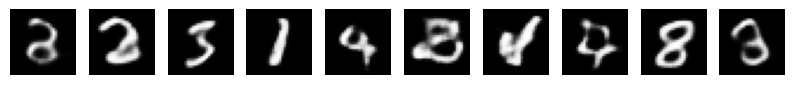

In [45]:
import matplotlib.pyplot as plt

def generate_images(model, num_samples=10, latent_dim=16, device="cuda"):
    model.eval()  
    with torch.no_grad():  
        z = torch.randn(num_samples, latent_dim).to(device)  
        generated_images = model.decoder(z)  
        generated_images = generated_images.cpu().numpy()  

    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 1.5))
    for i in range(num_samples):
        axes[i].imshow(generated_images[i, 0], cmap="gray")
        axes[i].axis("off")
    plt.show()

generate_images(vae, num_samples=10, latent_dim=16, device="cuda")

In [29]:
torch.save(vae.state_dict(), "vae.pth")